# Genetic Analysis of a Metazoan Pathway using Transcriptomic Phenotypes Supplementary and Extended Material
**David Angeles-Albores, Carmie Puckett Robinson, Brian Williams, Igot Antoshechkin, and Paul W Sternberg**

The purpose of this notebook is to serve as an extended, interactive document for our [paper](http://www.wormbase.org/).

All code in this notebook was written, documented and generated by David Angeles-Albores. In cases when code was inspired, written or shown elsewhere first, links have been provided to the source material where possible.

100% of the data, with the exception of the raw reads, is deposited in our [GitHub project](https://github.com/WormLabCaltech/mprsq). If you would like to verify our analysis, you are welcome to fork the project, although we will not allow pulls into the main branches. I hope you find this useful!

# Folder Structure

The folder structure is a little bit important if you want to replicate the findings presented here. 

Briefly, the folder structure is contained in the following major folders:

 * input - contains raw FASTQ files, kallisto_all (processed reads), genmap file, TF list, cDNA file, transcripts.idx, enrichment dictionaries and hypoxia gold standard gene files
 * sleuth - contains differential analysis (no *fog-2* included) results
 * sleuth_batch_adjusted - contains differential analysis results with *fog-2* included
 * src - all python scripts
 * output - all figures
 * tex - manuscript
 * experimental_docs - all bioanalyzer results are placed here

# Read alignment and differential expression analysis

 The raw FASTQ reads are in input/rawseq/PROJECT_NAME/. These reads are processed by running **kallisto_bash_generator.py**, then from terminal (in the main directory) *chmod +x kallisto commands.sh; sh kallisto_commands.sh*. Reads were processed using a length of **180**bp, with a standard deviation of **60** basepairs, bootstrapped 200 times. The results from this analysis are then placed in input/kallisto_all/PROJECT_NAME/.
 
 Sleuth analysis was performed by running **diff_exp_analyzer.R** in the **sleuth_adjusted_all** folder. This will perform the differential expression analysis. The results are stored within the *sleuth_adjusted/results/* folder.
 
## Details of Differential Analysis

We used a Generalized Linear Model to simultaneously estimate batch effects and the effects of varying mutations relative to a wild-type genome. Therefore, the model we used can be written:

\begin{equation}
\mathrm{log}(y_{i, j, k}) = \beta_{0, i} + \beta_{\mathrm{batch}, i}*Y_{k, i} + \beta_{\mathrm{genotype}, i}* X_{j, i}
\end{equation}
 
 Where $Y_{k, i}$ and $X_{j, i}$ are indicator variables for batch and genotype respectively.
 

# Introduction: Genetic Analysis Using Global Expression Measurements

The following sections will provide (excruciating) detail on how we performed the genetic analysis of our mutants using this data. Initially, this analysis was done blindly. For clarity, I have added all the genotype identifiers from the beginning.

To start, we should load all the python libraries that we will need:

In [128]:
# important stuff:
import os
import pandas as pd
import numpy as np
from IPython.core.display import HTML

# stats
import sklearn.decomposition
from scipy import stats as sts
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import statsmodels.api as stm

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan

# network graphics
import networkx as nx

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)

# bokeh
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html


# bayes and mcmc
import pymc3 as pm
import theano

# Display graphics in this notebook
bokeh.io.output_notebook()

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize
import genpy

Loading BokehJS ...

Next, I need to load the **phenotype_df** (please don't use this file without permission for publication purposes. This tool is unpublished [I am actively working on a paper with this] and will be available soon. I provide it here for clarity, even though it was not part of our paper), the **tissue_df** and the **tf_df**. These files contains a phenotype-gene dictionary, a tissue-gene dictionary (downloaded from TEA) and a transcription factor list (from Chris Grove). 

Additionally, I will initialize several variables whose purpose will mainly be to prettify the tables and substitute in the correct names. 

In [2]:
fname = '../input/dictionaries/phenotype_dictionary.csv'
phenotype_df = pd.read_csv(fname)
fname = '../input/dictionaries/go_dictionary.csv'
go_df = pd.read_csv(fname)
tissue_df = tea.fetch_dictionary()
tf_df = pd.read_csv('../input/tf_list.csv')
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv',
                           sep=',')

genotype_mapping = {'a': r'\emph{egl-9;vhl-1}',
                    'f': r'\emph{egl-9;hif-1}',
                    'b': r'\emph{egl-9}',
                    'c': r'\emph{hif-1}',
                    'd': r'\emph{vhl-1}',
                    'e': r'\emph{rhy-1}',
                    'g': r'\emph{fog-2}'
                    }

sort_pairs = {'eb': 1, 'be': 1,
              'ed': 2,'de': 2,
              'ec': 3,'ce': 3,
              'eg': 4,'ge': 4,
              'bd': 5,'db': 5,
              'cb': 6,'bc': 6,
              'bg': 7, 'gb': 7,
              'cd': 8,'dc': 8,
              'dg': 9,'gd': 9,
              'cg': 10,'gc': 10
             }

decode_pairs = {'eb': '\emph{rhy-1}, \emph{egl-9}',
                'be': '\emph{rhy-1}, \emph{egl-9}',
                'ed': '\emph{rhy-1}, \emph{vhl-1}',
                'de': '\emph{rhy-1}, \emph{vhl-1}',
                'ec': '\emph{rhy-1}, \emph{hif-1}',
                'ce': '\emph{rhy-1}, \emph{hif-1}',
                'eg': '\emph{rhy-1}, \emph{fog-2}',
                'ge': '\emph{rhy-1}, \emph{fog-2}',
                'bd': '\emph{egl-9}, \emph{vhl-1}',
                'db': '\emph{egl-9}, \emph{vhl-1}',
                'cb': '\emph{egl-9}, \emph{hif-1}',
                'bc': '\emph{egl-9}, \emph{hif-1}',
                'bg': '\emph{egl-9}, \emph{fog-2}',
                'gb': '\emph{egl-9}, \emph{fog-2}',
                'cd': '\emph{vhl-1}, \emph{hif-1}',
                'dc': '\emph{vhl-1}, \emph{hif-1}',
                'dg': '\emph{vhl-1}, \emph{fog-2}',
                'gd': '\emph{vhl-1}, \emph{fog-2}',
                'cg': '\emph{hif-1}, \emph{fog-2}',
                'gc': '\emph{hif-1}, \emph{fog-2}'
               }

Next, we will load up all of our files. These files will be placed within a class called morgan.hunt (funny!). All of the classes that are referenced in this tutorial are in the file morgan.py, which you are welcome to use for your own analysis. The classes are relatively well-documented and should be usable if you are careful. That said, I am not a computer scientist, so some pathologies or bugs may pop up -- if they do, please perform a pull-request on our github with a fix for the bug. Alternatively, please email me a sufficiently detailed script so I can reconstruct the failure event and correct the bug.

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
# target_id is the column with isoform specific names
# b is the name of the column with the GLM regression coefficients
# tpm is the name of the column with the TPM numbers
# qval is the name of the column with the FDR corrected q-values
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# # load all the beta values for each genotype:
# sleuth_loc = '../sleuth/'
# thomas.add_betas(sleuth_loc, 'betas.csv', combs)

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)


Next, I will filter the data, removing any genes that don't show up in all the files and removing the bottom 10% of the genes by expression level. This is an aggressive cutoff, I know. 

In [4]:
thomas.filter_data(0, 0.1)

Number of na genes: 232


# Figure 1. Dendrogram Clustering

Having performed the above analysis, let's go ahead and make the (almost finished) dendrogram figure in the paper. The only post-processing this will undergo is manually changing the letters to gene names and removing some of the labels for clarity.

4674
The first 2 principal components explain >=90% of the data


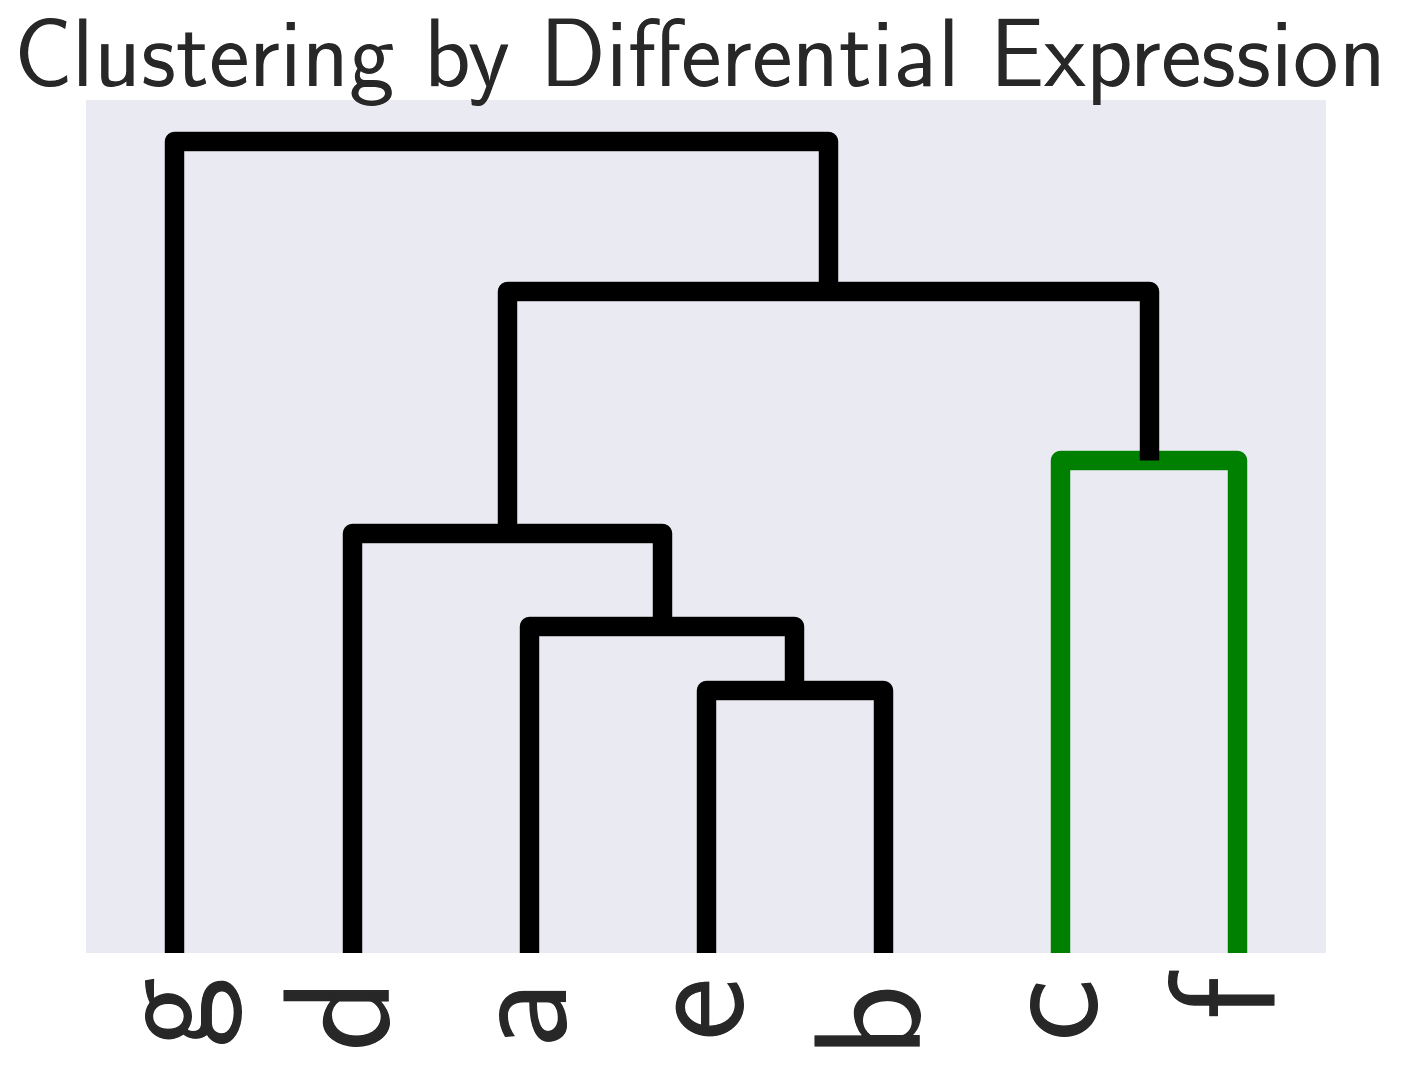

In [5]:
# find the set of all genes that are DE in any category
max_overlap = np.array([])
for df in thomas.beta_filtered.values():
    ind = df.qval < thomas.q
    if len(max_overlap) == 0:
        max_overlap = df[ind].target_id.values
    else:
        max_overlap = np.concatenate((max_overlap, 
                        df[ind].target_id.values))

max_overlap = max_overlap.tolist()
max_overlap = list(set(max_overlap))
print(len(max_overlap))

bvals = np.array([])
for df in thomas.beta_filtered.values():
    temp = df[df.target_id.isin(max_overlap)].b.values
    temp = (temp - temp.mean())/temp.std()
    if len(bvals) == 0:
        bvals = temp
    else:
        bvals = np.vstack((bvals, temp))

# Perform agglomerative clustering
sklearn_pca, n = genpy.pca(bvals)
model = hierarchy.linkage(sklearn_pca.transform(bvals), 'ward')
# extract the labels:
labels = list(thomas.beta_filtered.keys())

# rename the double mutant labels (i.e. instead of 'a' --> 'bd')
for i, label in enumerate(labels):
    if label in double_mutants:
        labels[i] = double_mutants[label]

# Linewidth parameter, temporarily set to 7
plt.rcParams['lines.linewidth'] = 7

# set colors (black; blue)
hierarchy.set_link_color_palette(['k', 'g', 'b'])

# draw the dendrogram
hierarchy.dendrogram(
    model,
    truncate_mode='level',  # show only the last p merged clusters
    labels=list(thomas.beta_filtered.keys()),
    p=21,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    above_threshold_color='k'
)

# get the current axis
ax = plt.gca()

# add in the orange and green boxes
height = ax.get_ylim()[1]*.36

plt.xticks(fontsize=55)
plt.gca().yaxis.set_major_locator(plt.NullLocator())

title = 'Clustering by Differential Expression'
plt.title(title, fontsize=ft)
plt.savefig('../output/tpm_dendrogram.pdf', bbox_inches='tight')

# return linewidth to a reasonable setting
plt.rcParams['lines.linewidth'] = 2

# Bayesian versus Spearman Regressions

Ok! Having verified that we still have plenty of power to identify these mutants, we need to go ahead and perform some statistics. Next, I will define some useful functions to make plotting easier. After that, I will begin a detailed analysis of the different prediction methods, specifically attempting to compare Spearman rank regression with a Bayesian linear regression of ranked data.

In [6]:
def pathify(title, xlabel, ylabel, xticks=True, yticks=True, **kwargs):
    """
    A function to pathify the labels, titles and ticks in a plot.
    """
    labelsize = kwargs.pop('labelsize', 20)
    titlesize = kwargs.pop('titlesize', 25)
    
    # make the labels and title into paths
    effect = [path_effects.Normal()]
    plt.ylabel(ylabel,
               fontsize=labelsize).set_path_effects(effect)
    plt.xlabel(xlabel,
               fontsize=labelsize).set_path_effects(effect)
    plt.title(title,
              fontsize=titlesize).set_path_effects(effect)

    ax = plt.gca()
    # go through each xtick or ytick and make 
    # it a path if user specified to do so.
    if xticks == True:
        for i, label in enumerate(ax.get_xticklabels()):
            ax.get_xticklabels()[i].set_path_effects(effect)
    if yticks == True:
        for i, label in enumerate(ax.get_yticklabels()):
            ax.get_yticklabels()[i].set_path_effects(effect)


## Spearman Regression Method

In order to perform the Spearman regression, this is what I will do:

 * Extract the pertinent datasets for the two genotypes I want to convert.
 * Find the genes that are altered between both conditions, regardless of direction
 * After finding this overlap, rank the genes by their $\beta$ coefficient in each dataset
 * Perform Least Squares on the ranked data, which is the Spearman Regression
 * Plot the results

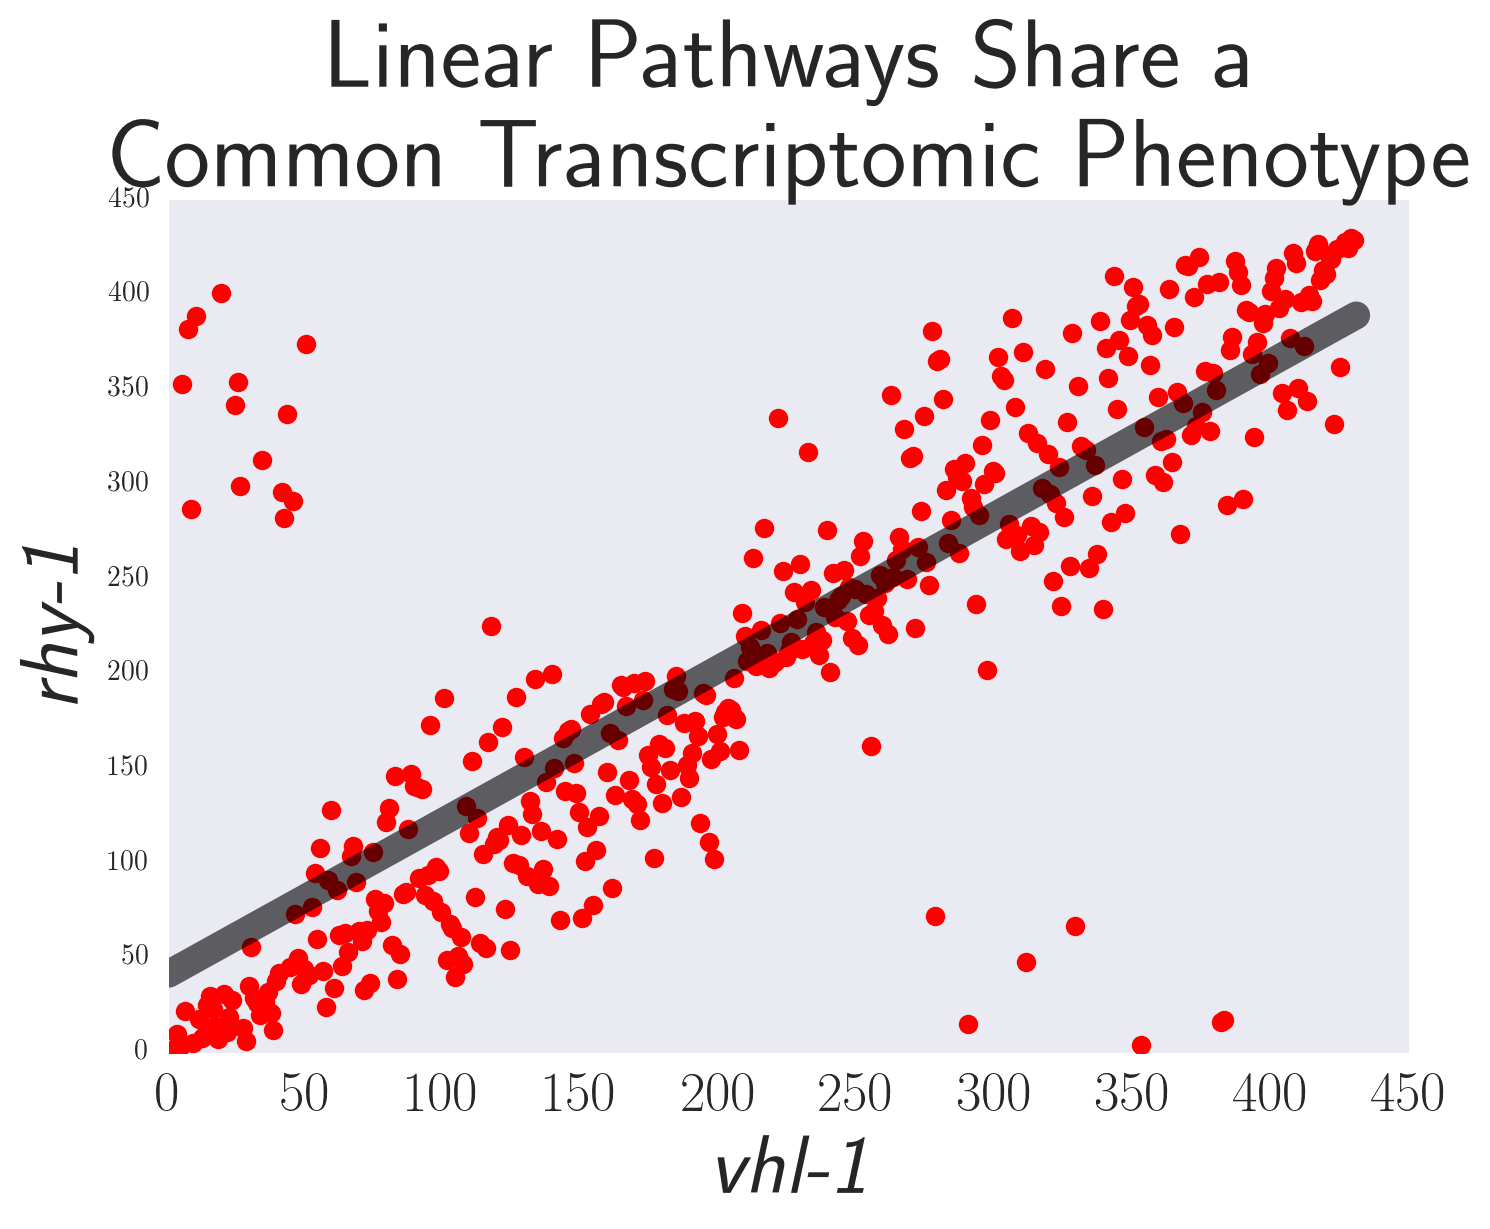

In [8]:
# lambda index function:
lind = lambda x: (x.qval < 0.1)

# As an example, let me show you what a 
# good spearman correlation looks like:
# name of the column that contains the 
# isoform names:
genes = 'target_id'

# the genotypes to compare
letters = ['d', 'e']

# extract the dataframes from the morgan.hunt object
x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

# boolean logic to find the stat. sig. diff. 
# genes that appear in both x and y
ovx = x[lind(x)]
ovy = y[lind(y) & y[genes].isin(ovx[genes])].copy()
ovx = x[lind(x) & x[genes].isin(ovy[genes])].copy()

# a function to rank order the data
def find_rank(df):
    """A function to find the rank values of a variable."""
    # make a copy of the dataframe, then sort it inplace
    d = df.copy()
    d.sort_values('b', inplace=True)
    # make a rank vector and append it to the sorted dataframe
    rank = np.linspace(0, len(d)-1, len(d))
    d['r'] = rank
    # sort by isoform name again and return the modified df
    d.sort_values('target_id', inplace=True)
    return d

# apply said function
ovx = find_rank(ovx)
ovy = find_rank(ovy)

# calculate a linear regression on ranked data, 
# which is equivalent to Spearman Ranked Regression
slope, intercept, r_value, p_value, std_err = sts.linregress(ovx.r,ovy.r)

# We make two vectors in order to draw the best fit line on a plot
X = np.linspace(0, len(ovx.r))
Y = slope*X + intercept

# Plot the genes that are significantly altered in both X and Y
plt.plot(ovx.r, ovy.r, 'ro',
         alpha=1, label='Overlapped Diff. Exp. Genes')

# Plot the best fit line
plt.plot(X, Y, 'k-', alpha=0.6,
         lw=10, label= 'Best Fit')

# prettify the plot
plt.title('Linear Pathways Share a\nCommon Transcriptomic Phenotype',
          fontsize=ft).\
            set_path_effects([path_effects.Normal()])
plt.xlabel(genotype_mapping[letters[0]],
           fontsize=30).set_path_effects([path_effects.Normal()])
plt.ylabel(genotype_mapping[letters[1]],
           fontsize=30).set_path_effects([path_effects.Normal()])
plt.xticks(fontsize=20)
plt.savefig('../output/spearmanr_{0}.pdf'.format(letters[0] + letters[1]))

Spearman R predicts a trend, but the best fit we found doesn't agree with the one I would predict with my eye. We can probably do better if we use a Bayesian regression that minimizes least squares but using a Student-T distribution, NOT a Gaussian. 

## Bayesian Robust Regression
In order to perform the Spearman regression, this is what I will do:

 * Extract the pertinent datasets for the two genotypes I want to convert.
 * Find the genes that are altered between both conditions, regardless of direction
 * After finding this overlap, rank the genes by their $\beta$ coefficient in each dataset
 * Perform Least Squares on the ranked data, but use a Student-T instead of a Gaussian prior.
   * The regression in this case is sampled using a full Monte Carlo Simulation.
 * Identify outliers to this regression, and run a second regression on outliers to see if there are complex regulatory relationships between these genes.
 * Plot the results
 
In other words, given ranked data, I will find the line that is likeliest to explain the data by finding:
\begin{equation}
P(D | \mu, \sigma) \propto \prod_i \mathrm{StudentT}(D_i(x) - \mu(x), \sigma)
\end{equation}

The Student-T distribution has considerably heavier tails than a Gaussian distribution, so it will not consider the evidence provided by outliers as informative as a Gaussian would. 

In order to perform this simulation, we will use the **pymc3** package to specify the model. This model was inspired and successfully deployed thanks to Thomas Wiecki; specifically thanks to [this blog entry](http://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/) by him. Thanks Tom!

## Figure 4. Complex Regulation Generates Detectable Patterns in Transcriptomes

The code that we will run below was used to generate the bottom panel of figure 4 in our paper. The figure as is output here was only subjected to very minor aesthetic modifications post-generation (such as moving the title a little above where it appears here). 

In [9]:
def robust_regress(data):
    """A robust regression using a StudentT distribution instead of a Gaussian model."""
    with pm.Model() as model_robust:
        # set the model. pymc is nice because
        # it will automatically choose
        # appropriate priors for us once we 
        # specify our likelihood is StudentT
        family = pm.glm.families.StudentT()
        # specify we want a generalized linear
        # model with a Student T distribution
        pm.glm.glm('y ~ x', data, family=family)
        # find the MAP as a good starting point
        start = pm.find_MAP()
        # do the simulation and return the results
        step = pm.NUTS(scaling=start)
        trace_robust = pm.sample(2000, step, progressbar=True)
        return trace_robust

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.5 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.0 sec

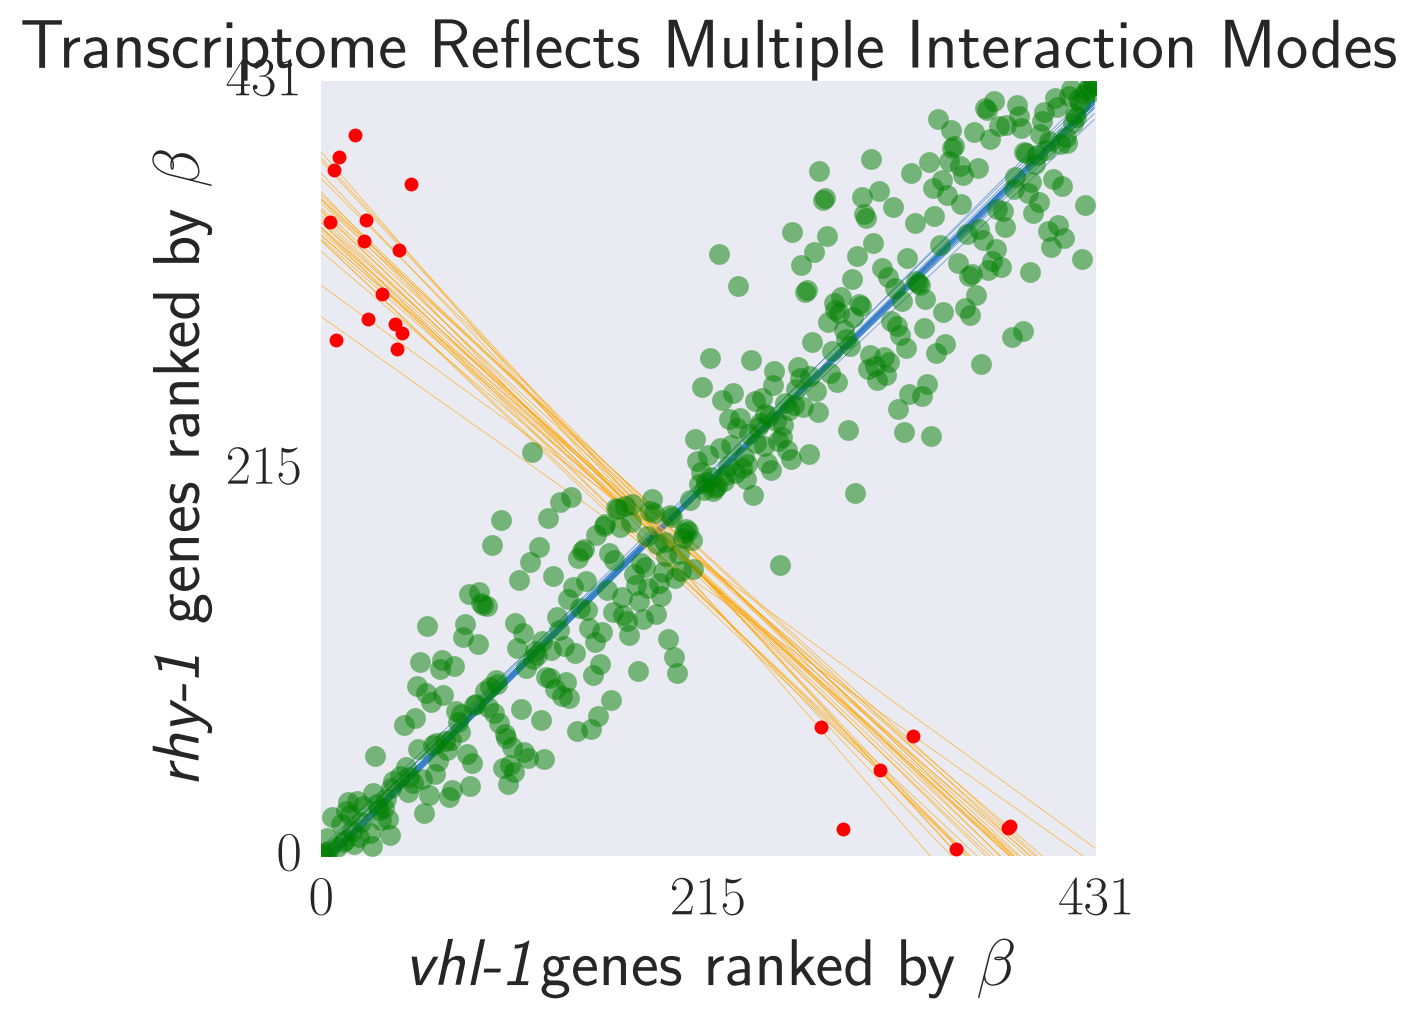

In [10]:
# Take the data from the Spearman example and put it 
# into a dictionary to feed into the robust regression
data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())

# perform the simulation
trace_robust = robust_regress(data)

# draw a figure
plt.figure(figsize=(5, 5))

# some statistics.
# normalize everything so that all points are centered around 0
# by taking the y-coordinates and subtracting
# the value of the model at the point we calculated
intercept = trace_robust.Intercept.mean()
slope = trace_robust.x.mean()
distribution = ovy.r - intercept - ovx.r*slope
# find the mean and stdev of the distribution
# (even though mean should be 0 now)
mean = distribution.mean()
std = distribution.std()

# find inliers and outliers (see text description below)
def find_inliers(distribution, mean, trace):
    """A function to identify inliers and outliers in a distribution"""
    # find the outliers:
    sel = np.abs(distribution - mean)/(trace_robust.x.std() 
                 + trace_robust.Intercept.std()+ std) < 1.5
    
    # get the outliers and inliers
    distribution_inliers = distribution[sel]
    distribution_outliers = distribution[~sel]

    # get the gene names of the outliers
    inverse = distribution_outliers + \
                          intercept + ovx.r*slope
    outliers = ovy[ovy.r.isin(inverse)].target_id
    
    return distribution_inliers, distribution_outliers, outliers

# call the function
results = find_inliers(distribution, mean, trace_robust)
distribution_inliers, distribution_outliers, outliers = results
# run a secondary regression on the outliers
data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r,
             y=ovy[ovy.target_id.isin(outliers)].r)

# run the second trace
trace_robust2 = robust_regress(data2)

# get the y-coordinate of the inliers and outliers
yri = distribution_inliers + intercept + ovx.r*slope
yro = distribution_outliers + intercept + ovx.r*slope

# plot the regression lines
label = 'posterior predictive regression lines'
pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label=label,
                                 color='#357EC7')
pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
                                 label=label,
                                 color='#FFA500')

# plot the data. Inliers are plotted as 
#large green dots, outliers as small red dots
plt.plot(ovx.r, yri, 'go', ms = 7.5, alpha=0.5)
plt.plot(ovx[yro > 0].r, yro[yro > 0], 'ro', ms = 5)

# prettify plot
plt.xlim(0, len(ovx))
plt.ylim(0, len(ovy))
plt.yticks([0, np.floor(len(ovx)/2), len(ovx)], fontsize=20)
plt.xticks([0, np.floor(len(ovx)/2), len(ovx)], fontsize=20)
pathify('Transcriptome Reflects Multiple Interaction Modes', 
        genotype_mapping[letters[0]] + r'genes ranked by $\beta$', 
        genotype_mapping[letters[1]] + r' genes ranked by $\beta$',
        labelsize=24)
comp = letters[0] + letters[1]
plt.savefig('../output/multiple_modes_{0}.pdf'.format(comp))

There, much better! Penalizing outliers allows us to estimate the primary regression slope really well (blue lines). Here, each blue line is the result of a simulation, and we can see that they are all clustered together. Having estimated the first regression, we can proceed to identify outliers. 

Now, there are multiple ways to identify outliers, and this is the point where I am going to cheat just a little bit. If we pretend that the model is gaussian (it isn't), then we can identify outliers (fairly aggressively) via the following method. Thus, if

\begin{equation}
z(i) = \frac{D_i(x) - \mu(x)}{\sigma_\mu + \sigma_{\mathrm{Intercept}} + \sigma_\mathrm{Data}} > 1
\end{equation}

then $z(i)$ is an outlier. 

After identifying these outliers, I can then pool them and run a second regression on them (orange lines). These lines are also quite clustered, and the slope is practically 1! Wow!


## Figure 2. Positive Regulatory Relationships Can Be Identified By Transcriptomic Correlation

In the above example, we saw that *rhy-1* and *hif-1* share a complex regulatory relationship as exhibited by the cross-pattern. However, an important point is whether or not this cross pattern appears in all datasets. While we cannot generalize yet (this kind of analysis is very new) we should definitely make sure that not all of our genes are exhibiting this cross pattern. Below, I show some a pair of genes that don't exhibit a cross pattern.

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.3 sec

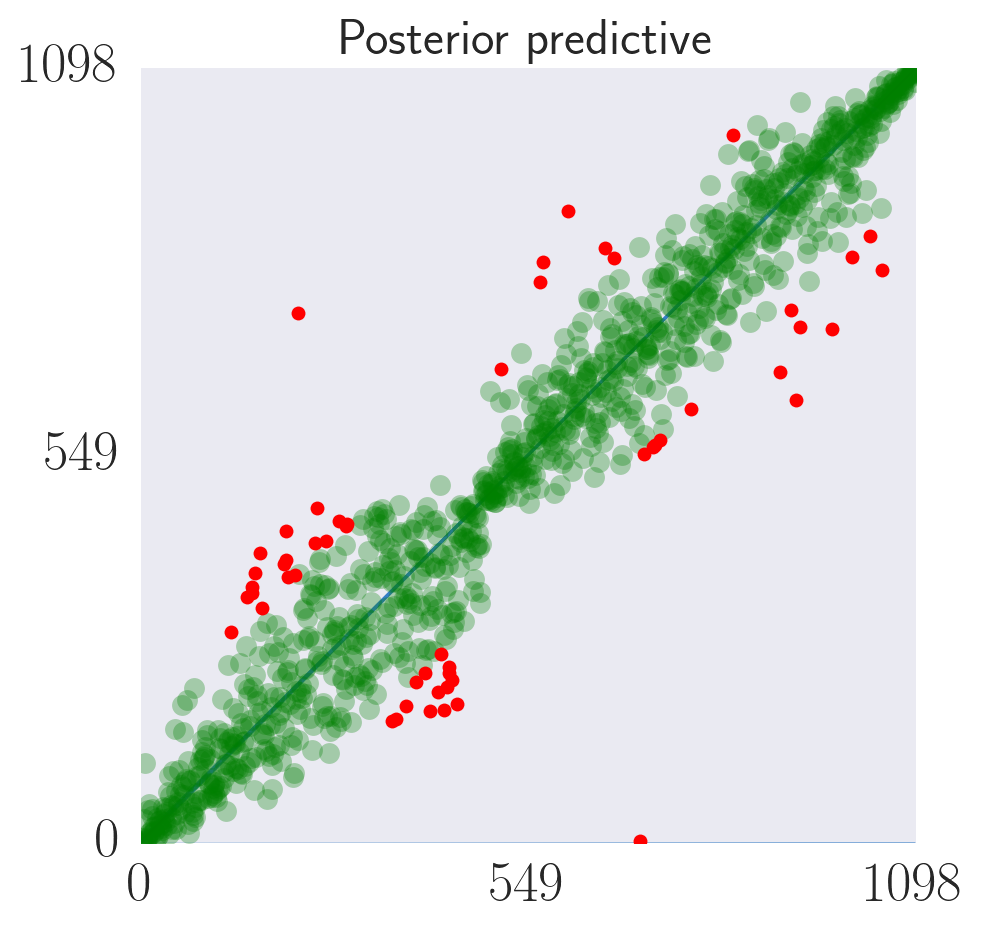

In [11]:
genes = 'target_id'
letters = ['b', 'e']

# datasets
x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

# overlap
ovx = x[lind(x)]
ovy = y[lind(y) & y[genes].isin(ovx[genes])].copy()
ovx = x[lind(x) & x[genes].isin(ovy[genes])].copy()

# find rank
ovx = find_rank(ovx)
ovy = find_rank(ovy)

# Take the data and place it
# into a dictionary to feed into the robust regression
data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())

# perform the simulation
trace_robust = robust_regress(data)

# draw a figure
plt.figure(figsize=(5, 5))

# some statistics.
# normalize everything so that all points are centered around 0
# by taking the y-coordinates and subtracting
# the value of the model at the point we calculated
intercept = trace_robust.Intercept.mean()
slope = trace_robust.x.mean()
distribution = ovy.r - intercept - ovx.r*slope

# find the mean and stdev of the distribution
# (even though mean should be 0 now)
mean = distribution.mean()
std = distribution.std()

# find inliers
results = find_inliers(distribution, mean, trace_robust)
distribution_inliers, distribution_outliers, outliers = results

# y-coordinate of outliers
yri = distribution_inliers + intercept + ovx.r*slope
yro = distribution_outliers + intercept + ovx.r*slope

# plot the regression lines
label = 'posterior predictive regression lines'
pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label=label,
                                 color='#357EC7')

# plot the data. Inliers are plotted as 
# large green dots, outliers as small red dots
plt.plot(ovx.r, yri, 'go', ms = 7.5, alpha=0.3)
plt.plot(ovx[yro > 0].r, yro[yro > 0], 'ro', ms = 5)

# prettify plot
plt.xlim(0, len(ovx))
plt.ylim(0, len(ovy))
plt.yticks([0, np.floor(len(ovx)/2), len(ovx)], fontsize=20)
plt.xticks([0, np.floor(len(ovx)/2), len(ovx)], fontsize=20)
# pathify('Positive Interaction Between Genes', 
#         genotype_mapping[letters[0]] + r'genes ranked by $\beta$', 
#         genotype_mapping[letters[1]] + r' genes ranked by $\beta$',
#         labelsize=24)
comp = letters[0] + letters[1]
plt.savefig('../output/positive_interaction{0}.pdf'.format(comp),
            bbox_inches='tight')

# Pairwise Analysis of All Genes Using Spearman Correlation

Given what we found above, we know that the spearman analysis is good to use to get a rough fast idea of how our data looks. Let's go ahead and run the analysis for all pairwise comparisons that can be made using this dataset. 

Spearman correlations and hypergeometric tests can be performed using the class morgan.brenner. 

Once I calculate the quantities of interest, I will plot them on a heatmap. However, reader beware. Do NOT **EVER** use jet. The red and blue heatmaps? Awful. They have very serious pathologies that have been well described, and they generate patterns via optical illusions. Instead, we will use the *viridis* colormap, which was used by scientists in LIGO.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text yticklabel objects>)

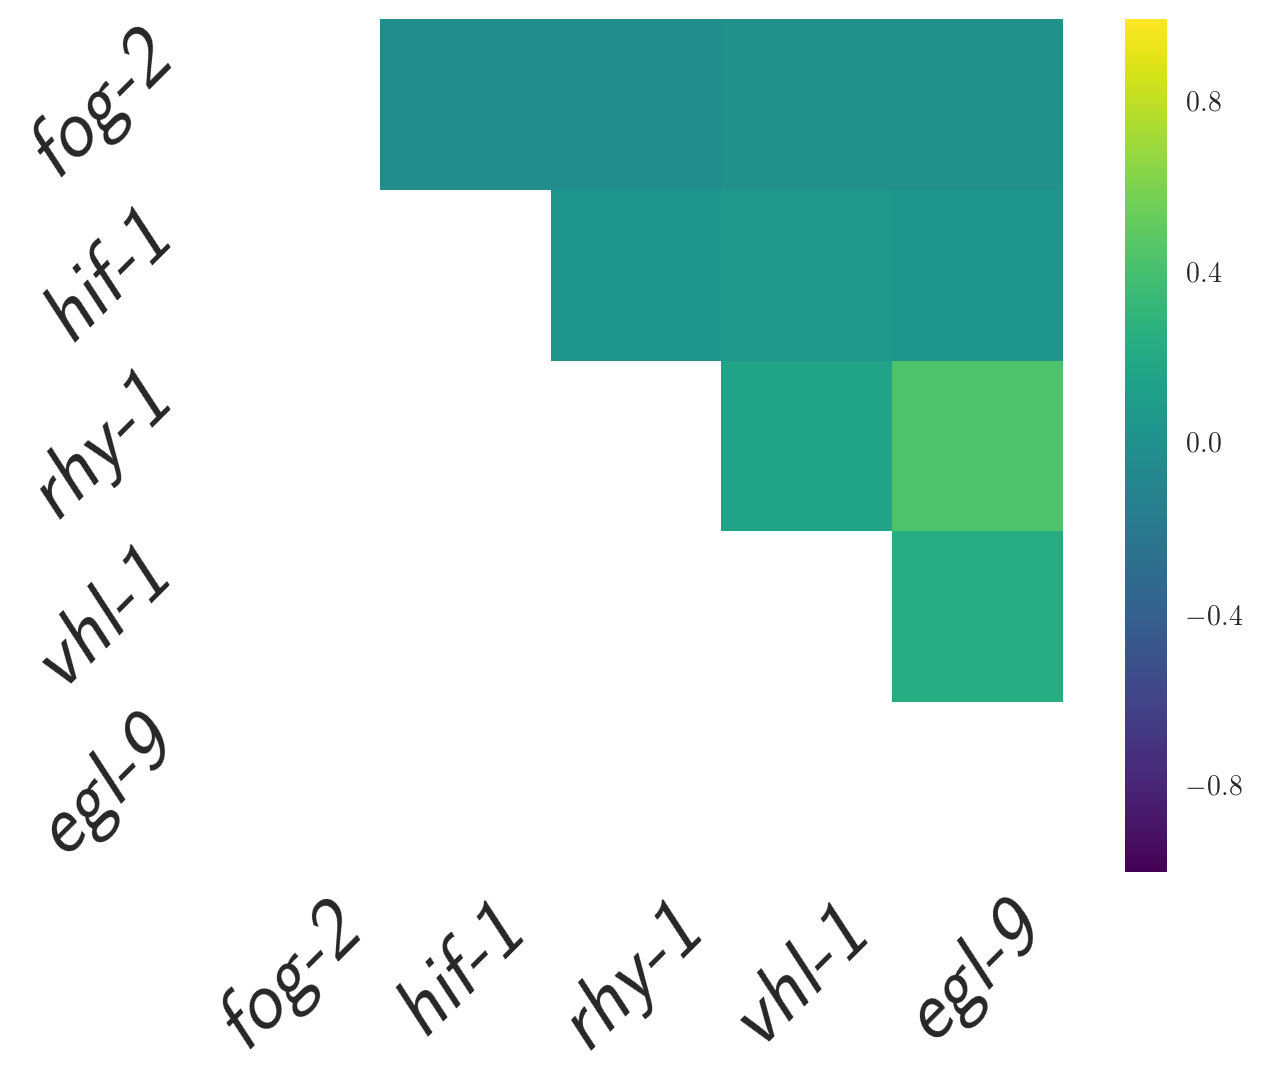

In [15]:
# Define a 'genes' variable that will be used 
# for labelling every plot from here on out:
genes = [genotype_mapping[x] for x in thomas.single_mutants]

# Define a plotting function to plot only a triangular heat map
def tri_plot(matrix, xlabels, ylabels=[]):
    """Given a matrix, draw a triangle plot."""
    # Minimum and maximum for colormap
    vmin= matrix.min().min()
    vmax= np.max(matrix).max()

    # if user didn't specify xlabels, assume ylabels 
    # are the same as xlabels
    if len(ylabels) == 0:
        ylabels = xlabels

    # make the lower triangle of the matrix,
    # since we are only dealing with 
    # symmetric matrices. Also, remove the diagonal
    mask = np.zeros_like(matrix)
    mask[np.tril_indices_from(mask)] = True

    # draw and adjust xtick size
    with sns.axes_style("white"):
        ax = sns.heatmap(matrix, xticklabels=xlabels,
                         yticklabels=ylabels, cmap='viridis',
                         mask=mask, square=True, vmin=vmin,
                         vmax=vmax)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

# Perform Correlation Analysis
sydney = morgan.brenner('spearman', thomas)
# Plot
tri_plot(sydney.rho.as_matrix(columns=thomas.single_mutants),
         genes)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

So maybe *egl-9* and *rhy-1* interact? Let's wait for the full Bayesian treatment.

# Hypergeometric Analysis:

Another method to query whether there are interactions between genes is perform an urn test of enrichment. We ask: What is the probability that the DE genes in a gene B are the same as those in A? This probability should intuitively be 1 if A and B have exactly the same DE genes; it should be 0 (or close to) if they share no genes in common. 

I approached this problem by assuming that the urn to be drawn from is exactly gene A in the above example. We define one of the two genes in the comparison to be the 'urn' (specifically, I always select the one which has more DE genes). Then, the question can be rephrased as follows: What is the probability that the DE genes in B were drawn from A? In other words, we want to calculate:

\begin{equation}
P(A~\mathrm{and}~B~\mathrm{are~in~a~pathway}| B, A)~\propto~P(A|B) = \mathrm{Hypergeom}(A, B,~A\cap B,~\mathrm{genome})
\end{equation}

In reality this approach has an incredibly low threshold for activation. Biological networks are not random, and therefore my suspicion is that this test is biased towards positive results. This would be the case particularly if networks are dense (everything interacts with everything). Part of the problem with the hypergeometric is that it saturates very rapidly, so the dynamic range is low. In effect, the answers become largely binary (....great for an SVM?). However, this means that we can't use the hypergeometric probabilities to gauge functional distance (these probabilities cannot be weighted intuitively).

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text yticklabel objects>)

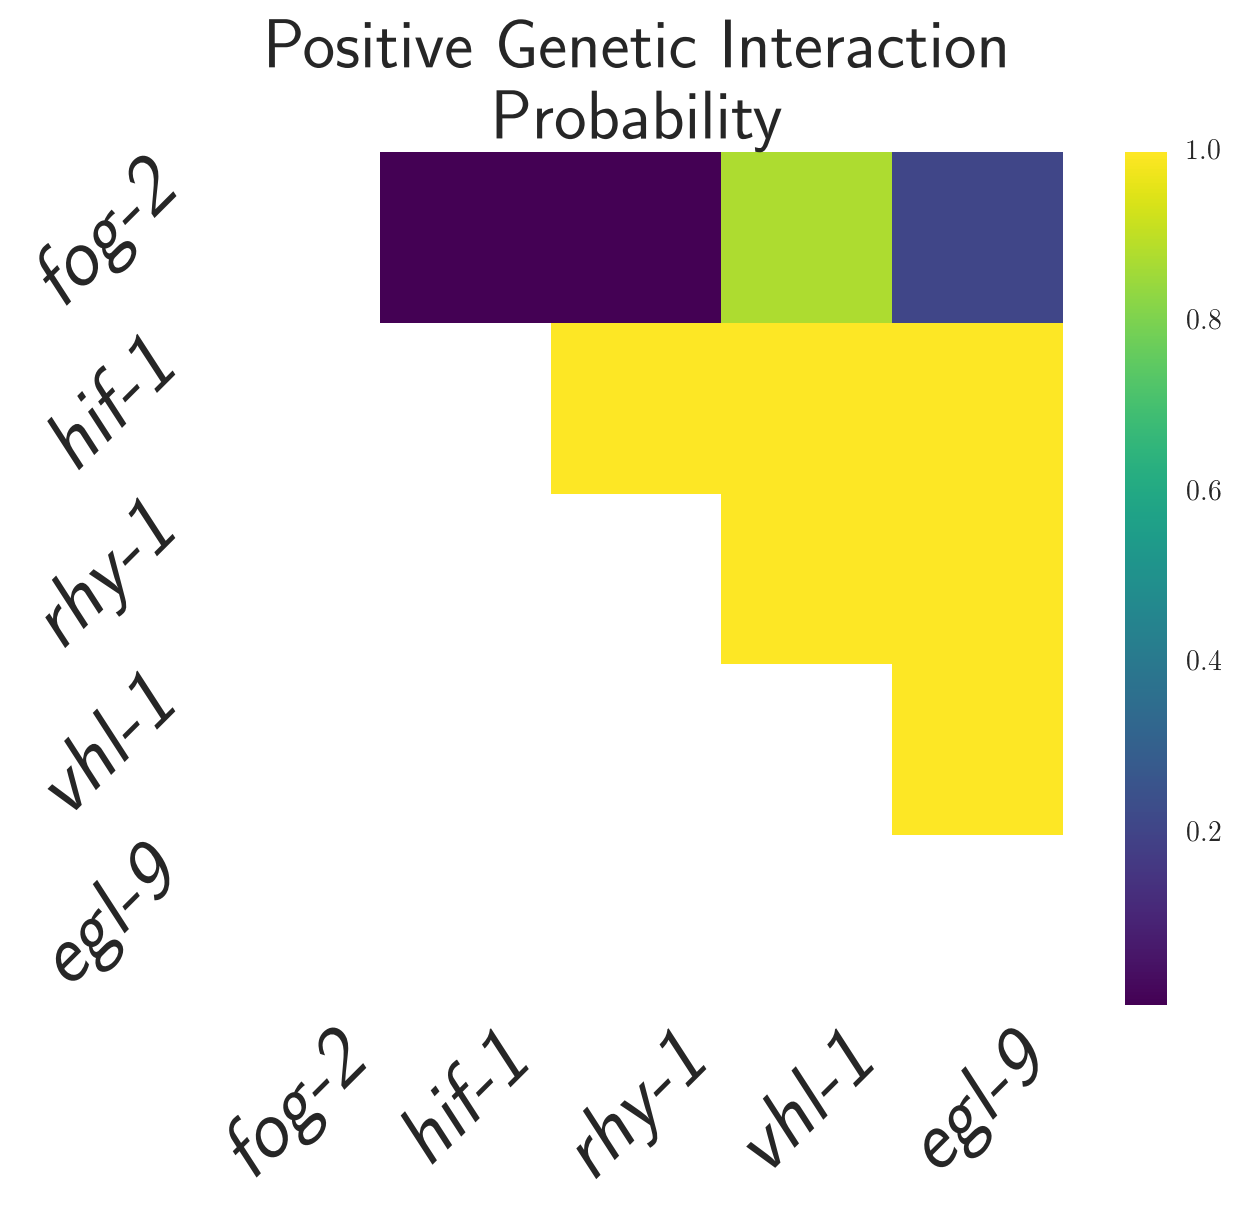

In [16]:
# Perform a test for positive interaction, put them in a matrix
mat = sydney.hyper_plus.as_matrix(columns=thomas.single_mutants)
genes = [genotype_mapping[x] for x in thomas.single_mutants]

# plot the results
tri_plot(mat, genes)
pathify('Positive Genetic Interaction\nProbability', '', '')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

*fog-2* has a weak probability of interacting with any genes in this pathway. It would be most likely that *vhl-1* and *fog-2* share a positive interaction according to this diagram. Moreover, notice that all the hypoxia genes are predicted to interact; however, the saturation makes it hard to gauge exactly what kind of interaction is occurring.

### Probability of Negative Regulatory Interaction

Next, we can repeat our query, but we modify it slightly to ask about the possibility of a negative regulatory interaction:

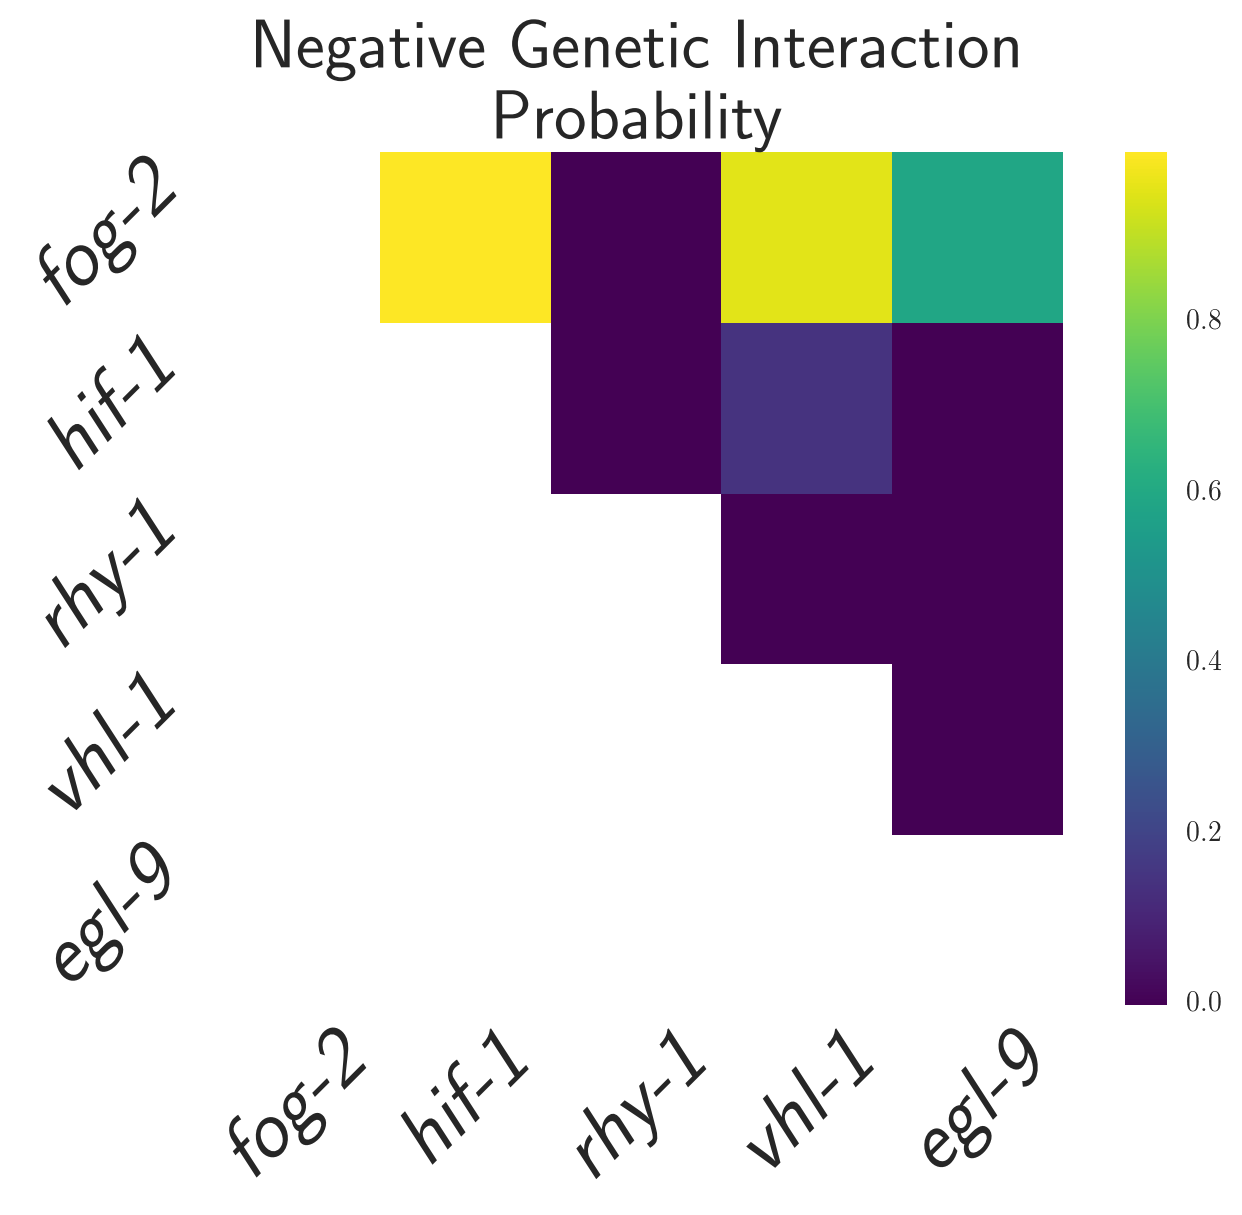

In [17]:
# perform the query, place results in a matrix and plot:
mat = sydney.hyper_minus.as_matrix(columns=thomas.single_mutants)
genes = [genotype_mapping[x] for x in thomas.single_mutants]
tri_plot(mat, genes)
pathify('Negative Genetic Interaction\nProbability', '', '')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.savefig('../output/probability_of_inhibition_single_mutants.pdf',
            bbox_inches='tight')

In [86]:
print('X, Y, -, +')
for key, value in sydney.overlap_ids_minus.items():
    if key[0] == 'g' or key[1] == 'g':
        continue
    print(genotype_mapping[key[0]], genotype_mapping[key[1]],
          len(value), len(sydney.overlap_ids_plus[key]))

X, Y, -, +
\emph{egl-9} \emph{rhy-1} 3 1095
\emph{rhy-1} \emph{egl-9} 3 1095
\emph{egl-9} \emph{vhl-1} 15 447
\emph{vhl-1} \emph{rhy-1} 23 408
\emph{vhl-1} \emph{hif-1} 18 79
\emph{vhl-1} \emph{egl-9} 15 447
\emph{hif-1} \emph{rhy-1} 38 146
\emph{egl-9} \emph{hif-1} 39 126
\emph{hif-1} \emph{egl-9} 39 126
\emph{rhy-1} \emph{hif-1} 38 146
\emph{hif-1} \emph{vhl-1} 18 79
\emph{rhy-1} \emph{vhl-1} 23 408


We see that this time *fog-2* has a real probability of negative interaction with the hypoxia pathway. Interesting. 

Aside from that, there is a small probability (20%) that *hif-1* and *egl-9* are interacting in a negative manner. Incidentally, that is the **correct** mode of interaction, according to the canonical literature. 

# Analysis Using Robust Regression

What I do here is try to identify trends. Namely, for two genotypes X and Y, I fit a line using a Bayesian robust regression (see methods) thru the rank-ordered regression coefficients that are statistically significantly different from 0 and that are present in both X and Y. Next, I use this Bayesian framework to identify any and all outliers to the regression. 

In order to test for alternative modes of interaction in this dataset, I take the outliers and I run the same regression again *on the outliers*. If this second interaction has an opposite sign to the first, then we predict that there are two modes of interaction, subject to the following caveats:

 * Both the primary and secondary regressions yield strong correlations (>0.7)
 * The first regression results in many outliers

Finally, because of the approach I used, I can also predict which genes are under what mode of regulation. Super cool!

In [19]:
barbara = morgan.mcclintock('bayesian', thomas, True)


starting comparison of g, c
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec
starting comparison of g, e
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 sec
starting comparison of g, d
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.5 sec
starting comparison of g, b
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 sec
starting comparison of c, e
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 sec
starting comparison of c, d
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-------------

The simulation has finished, and now I should make the heat map showing the primary correlations.

## Figure 3. Pairwise regression values between all single mutants


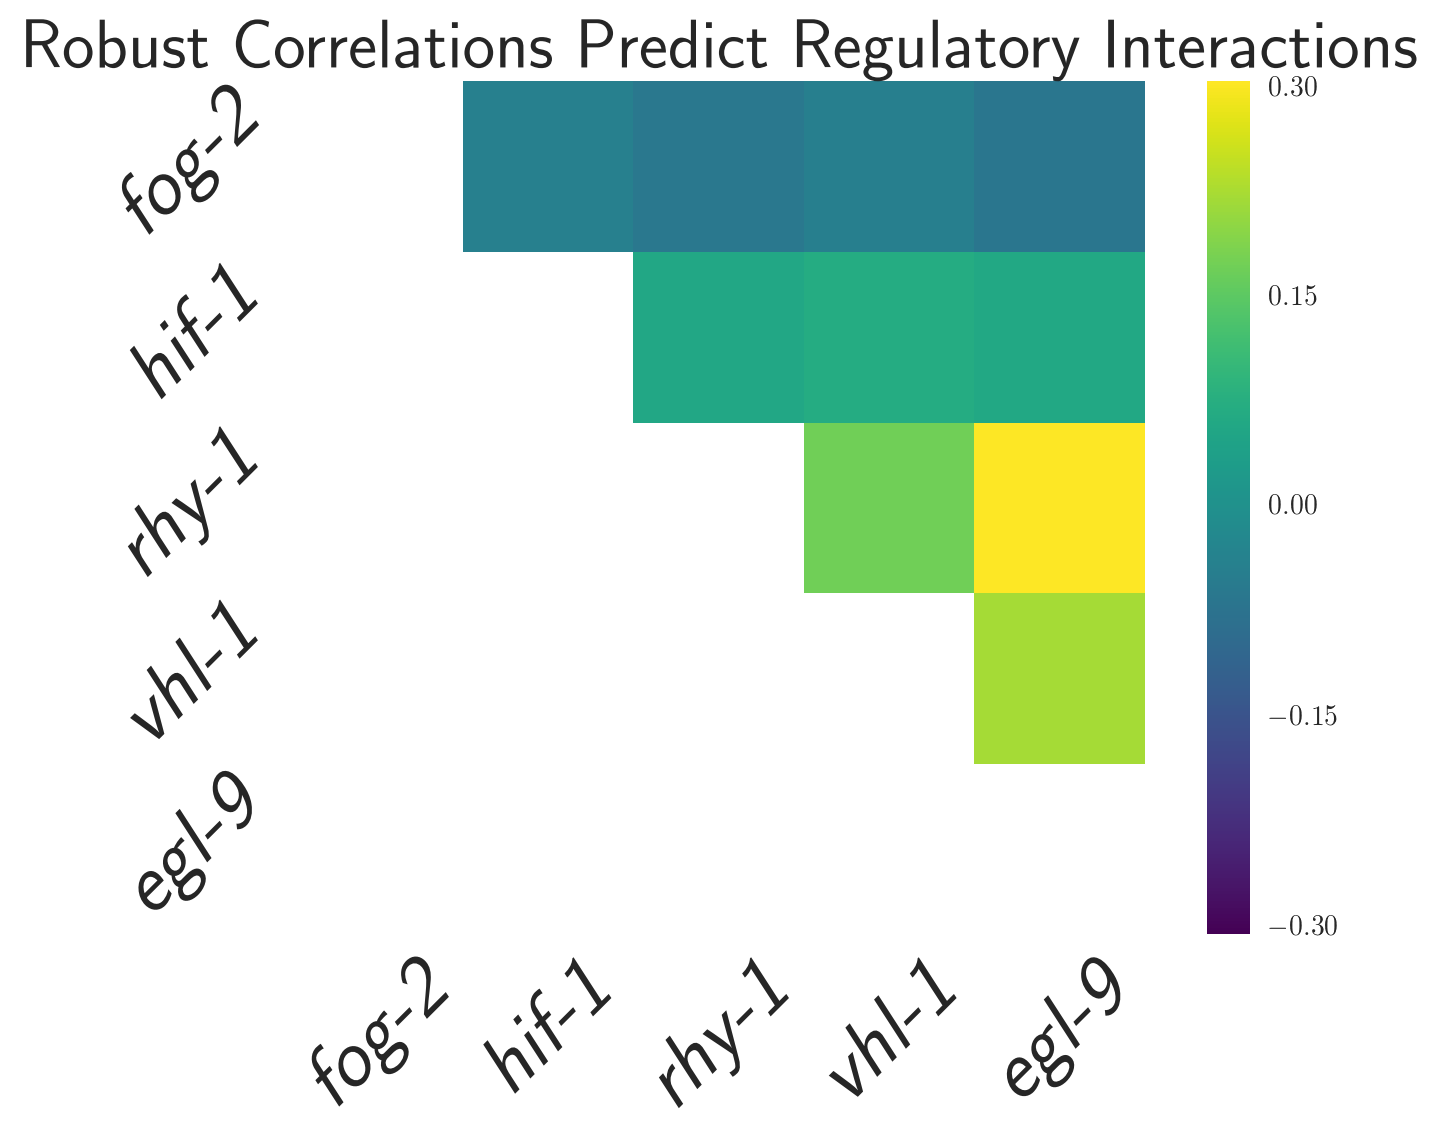

In [20]:
mat = barbara.robust_slope.as_matrix(columns=thomas.single_mutants)
tri_plot(mat, genes)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
pathify('Robust Correlations Predict Regulatory Interactions',
        '', '')
plt.savefig('../output/bayes_primary_single_mutants.pdf',
            bbox_inches='tight')

Notice the correlation values. They are very small, less than 0.30 in magnitude. This is fine though: While you weren't looking, I weighted the correlation by the fraction of DE genes that two mutant transcriptomes share divided by the total number of DE genes in either transcriptome. Since this fraction is usually $<<1$, our correlations have all shifted down, but that's OK! Remember the hypergeometric test suggested that every single on of the hypoxia interactions is non-random (for positive interactions) so we can freely interpret these correlation coefficients. 

We can also plot the secondary correlations and see what comes out of them

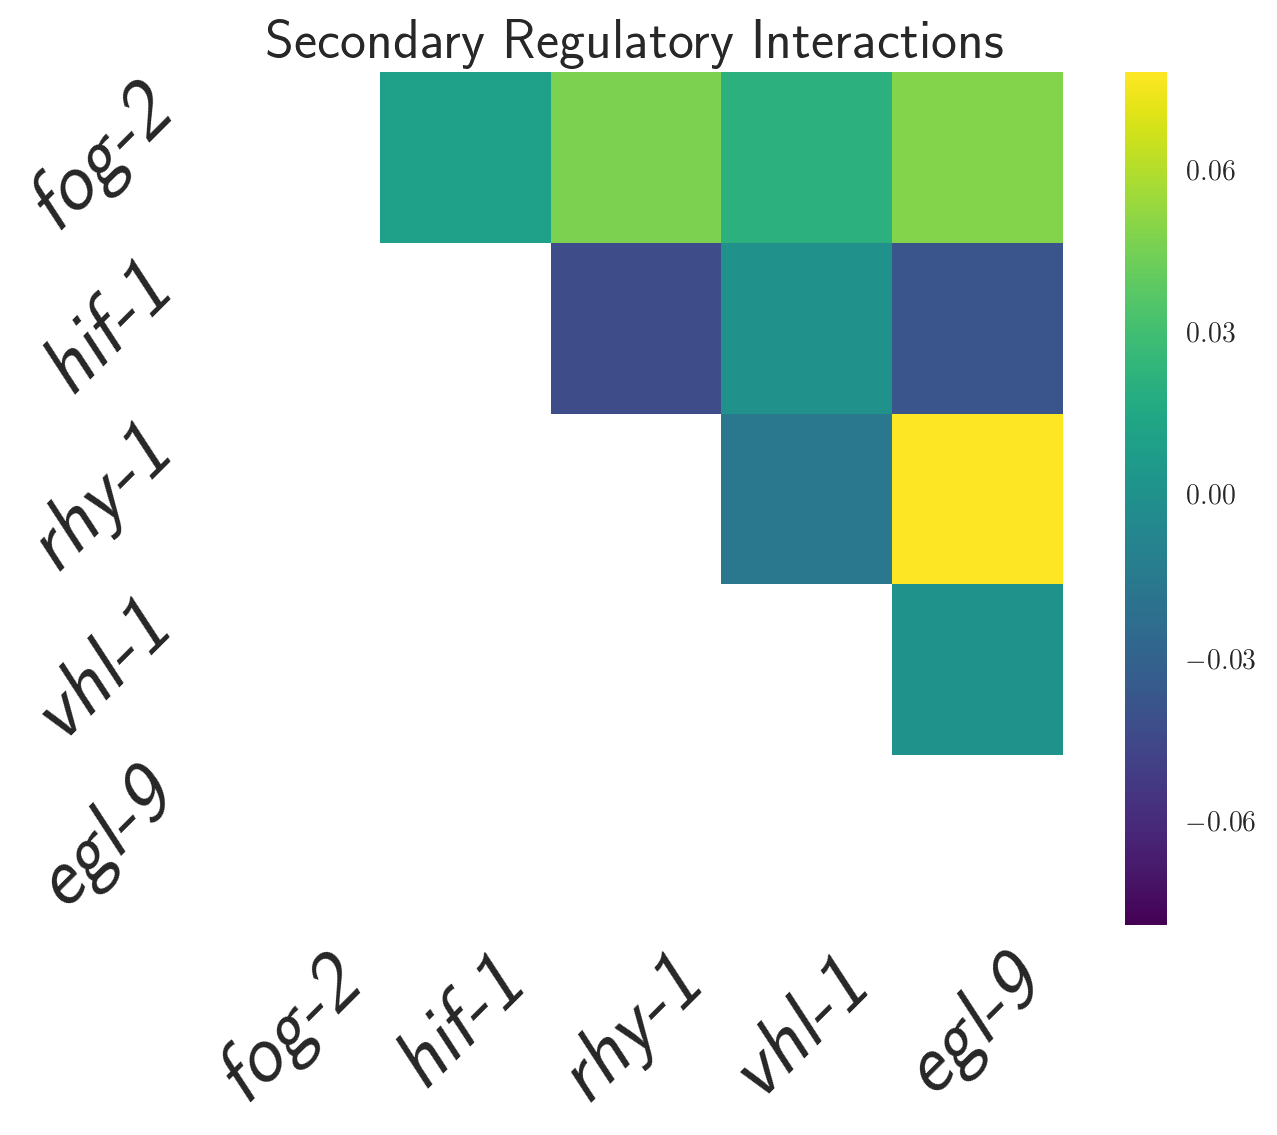

In [21]:
mat = barbara.secondary_slope.as_matrix(columns=thomas.single_mutants)
tri_plot(mat, genes)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Secondary Regulatory Interactions', fontsize=20)

# Why does *hif-1* have a positive relationship with *egl-9*, *rhy-1* and *vhl-1*?

First of all, we need to realize that the positive relationships between *egl-9* and *hif-1* and between *rhy-1* and *hif-1* and between *vhl-1* and *hif-1* are made up of *relatively few genes* ($<150$ for the first two, $<100$ for *vhl-1*), so the overall weight of these correlations is weak, even though the actual correlation coefficient is pretty good. The negative correlations are made up of even less genes ($<40$ genes for *egl-9/hif-1* and *rhy-1/hif-1* and 18 genes for *vhl-1/hif-1*) and they don't strictly show up in the hypergeometric test, which means that drawing statistical inference from these negative correlations is somewhat difficult statistically speaking. 

Before we begin, I'd like to point out that *egl-9* and *rhy-1* act entirely in a linear pathway -- there are no genes that support a negative relationship between either. Moreover, out of the ~1,800 genes that each one activates, they share ~1,100. This leaves 700 genes that may be regulated individually by each or, alternatively, 700 genes that were not captured due to experimental variation. 

The positive correlation between these genes is mildly surprising, but not entirely. First, let me list some facts that are known in the literature:

 * *egl-9* is induced by hypoxia and by *vhl-1* deletions
 * so is *rhy-1*

If *rhy-1* inhibits *hif-1*, and *hif-1* activates *rhy-1*, then we should see two modes of interaction in the *rhy-1*, *hif-1* comparison. We should see that genes that are controlled via *egl-9* will appear to be positively correlated between *hif-1* and *rhy-1* mutants and that the genes that are under control of *hif-1* have a negative relationship between *hif-1* and *rhy-1* mutants. Since *hif-1* is usually OFF in normoxic conditions, we expect to detect few *hif-1* direct targets using this method. Therefore, it makes sense that the negative correlation does not contain the majority of the altered genes. 

It is worth noting that although a *rhy-1*  mutant should lead to increased transcription of *egl-9*, *rhy-1* is controlling *egl-9* at the protein level. **In fact, had previous reports (Ma et al, Cell) not described the mode of control by *rhy-1* on *egl-9, our analysis would have uncovered the two modes of regulation that are happening between these genes**.

We can repeat this analysis for *egl-9*. The *hif-1* mutant and the *egl-9* mutant both have a main positive relationship, indicating that knocking out *egl-9* has the same effect as knocking out *hif-1*, which suggests that *egl-9* is regulated by *hif-1* (or vicersa). Likewise, the weak negative relationship between these two mutants should be the result of *egl-9* inhibition on *hif-1*. 

From this analysis, a clear prediction emerges:
The genes that are positively correlated between *rhy-1* and *hif-1* and between *egl-9* and *hif-1* **should be the same**. Below, I quantitatively measure this similarity. 

Moreover, the genes that appear in the negative correlation should also be the same. In the cell below, I show that this is in fact the case:

In [115]:
# positive overlap:
print('genes found in the positive overlap\n\
      ---------------------')
s = 'Genes coexpressed between {0} and {1}: {2}'

# print the number of genes in either comparison:
print(s.format('hif-1', 'egl-9', len(sydney.overlap_ids_plus[('c', 'b')])))
print(s.format('hif-1', 'rhy-1', len(sydney.overlap_ids_plus[('c', 'e')])))

# get the number of genes in the intersection
tt = len(np.intersect1d(sydney.overlap_ids_plus[('c', 'b')],
                    sydney.overlap_ids_plus[('c', 'e')]))

# and the number of genes found
total_genes = len(list(set(sydney.overlap_ids_plus[('c', 'b')].tolist()
                       + sydney.overlap_ids_plus[('c', 'e')].tolist())))
frac_mess = 'fraction of genes similar between the two comparisons: {0:.2g}'
print(frac_mess.format(tt/total_genes))

# negative overlap:
print('\ngenes found in the negative overlap\n\
      ---------------------')

# print the number of genes in either comparison:
s = 'Genes antiexpressed between {0} and {1}: {2}'
print(s.format('hif-1', 'egl-9', len(sydney.overlap_ids_minus[('c', 'b')])))
print(s.format('hif-1', 'rhy-1', len(sydney.overlap_ids_minus[('c', 'e')])))

# get the number of genes in the intersection
tt = len(np.intersect1d(sydney.overlap_ids_minus[('c', 'b')],
                    sydney.overlap_ids_minus[('c', 'e')]))

# and the number of genes found
total_genes = len(list(set(sydney.overlap_ids_minus[('c', 'b')].tolist()
                       + sydney.overlap_ids_minus[('c', 'e')].tolist())))

print(frac_mess.format(tt/total_genes))

genes found in the positive overlap
      ---------------------
Genes coexpressed between hif-1 and egl-9: 126
Genes coexpressed between hif-1 and rhy-1: 146
fraction of genes similar between the two comparisons: 0.48

genes found in the negative overlap
      ---------------------
Genes antiexpressed between hif-1 and egl-9: 39
Genes antiexpressed between hif-1 and rhy-1: 38
fraction of genes similar between the two comparisons: 0.35


What about *vhl-1*? Let's see whether the positive correlation with *hif-1* is the same as *egl-9* and *rhy-1*.

In [122]:
print('\ngenes coexpressed\n\
      ---------------------')
# print the number of genes in either comparison:
s = 'Genes coexpressed between {0} and {1}: {2}'
print(s.format('hif-1', 'vhl-1', len(sydney.overlap_ids_plus[('c', 'd')])))
print(s.format('hif-1', 'rhy-1', len(sydney.overlap_ids_plus[('c', 'e')])))

# get the number of genes in the intersection
tt = len(np.intersect1d(sydney.overlap_ids_plus[('c', 'd')],
                    sydney.overlap_ids_plus[('c', 'e')]))

# and the number of genes found
total_genes = len(list(set(sydney.overlap_ids_plus[('c', 'd')].tolist()
                       + sydney.overlap_ids_plus[('c', 'e')].tolist())))

print(frac_mess.format(tt/total_genes))

print('\ngenes antiexpressed\n\
      ---------------------')
# print the number of genes in either comparison:
s = 'Genes antiexpressed between {0} and {1}: {2}'
print(s.format('hif-1', 'vhl-1', len(sydney.overlap_ids_minus[('c', 'd')])))
print(s.format('hif-1', 'egl-9', len(sydney.overlap_ids_minus[('c', 'e')])))

# get the number of genes in the intersection
tt = len(np.intersect1d(sydney.overlap_ids_minus[('c', 'd')],
                    sydney.overlap_ids_minus[('c', 'e')]))

# and the number of genes found
total_genes = len(list(set(sydney.overlap_ids_minus[('c', 'd')].tolist()
                       + sydney.overlap_ids_minus[('c', 'e')].tolist())))

print(frac_mess.format(tt/total_genes))


genes coexpressed
      ---------------------
Genes coexpressed between hif-1 and vhl-1: 79
Genes coexpressed between hif-1 and rhy-1: 146
fraction of genes similar between the two comparisons: 0.29

genes antiexpressed
      ---------------------
Genes antiexpressed between hif-1 and vhl-1: 18
Genes antiexpressed between hif-1 and egl-9: 38
fraction of genes similar between the two comparisons: 0.17


These fractions are still pretty high, but the fraction of genes shared is quite a bit lower than the fractions that were shared between *rhy-1* and *egl-9*. Curiously, these numbers look like half of what they were above. Could *vhl-1* be at a branch point on the *hif-1* diagram? 

In [124]:
print('\ngenes coexpressed\n\
      ---------------------')
# print the number of genes in either comparison:
s = 'Genes coexpressed between {0} and {1}: {2}'
print(s.format('egl-9', 'vhl-1', len(sydney.overlap_ids_plus[('b', 'd')])))
print(s.format('rhy-1', 'vhl-1', len(sydney.overlap_ids_plus[('e', 'd')])))

# get the number of genes in the intersection
tt = len(np.intersect1d(sydney.overlap_ids_plus[('b', 'd')],
                    sydney.overlap_ids_plus[('e', 'd')]))

# and the number of genes found
total_genes = len(list(set(sydney.overlap_ids_plus[('b', 'd')].tolist()
                       + sydney.overlap_ids_plus[('e', 'd')].tolist())))

print(frac_mess.format(tt/total_genes))

print('\ngenes antiexpressed\n\
      ---------------------')
# print the number of genes in either comparison:
s = 'Genes antiexpressed between {0} and {1}: {2}'
print(s.format('egl-9', 'vhl-1', len(sydney.overlap_ids_minus[('b', 'd')])))
print(s.format('rhy-1', 'vhl-1', len(sydney.overlap_ids_minus[('e', 'd')])))

# get the number of genes in the intersection
tt = len(np.intersect1d(sydney.overlap_ids_minus[('b', 'd')],
                    sydney.overlap_ids_minus[('e', 'd')]))

# and the number of genes found
total_genes = len(list(set(sydney.overlap_ids_minus[('b', 'd')].tolist()
                       + sydney.overlap_ids_minus[('e', 'd')].tolist())))

print(frac_mess.format(tt/total_genes))


genes coexpressed
      ---------------------
Genes coexpressed between egl-9 and vhl-1: 447
Genes coexpressed between rhy-1 and vhl-1: 408
fraction of genes similar between the two comparisons: 0.72

genes antiexpressed
      ---------------------
Genes antiexpressed between egl-9 and vhl-1: 15
Genes antiexpressed between rhy-1 and vhl-1: 23
fraction of genes similar between the two comparisons: 0.41


We could perform a hypergeometric test for significance, but I guarantee you this overlap is much too high to be coincidence. We are sampling from the same pools. 

## Enumerating the relationships

Therefore, we have the following model:

***rhy-1* and *egl-9* coexpress 1095 genes, antiexpress 3**:
 * *rhy-1* and *egl-9*  share a positive regulatory relationship
 
***egl-9* and *vhl-1* coexpress 447 genes, antiexpress 15 genes**
 * *egl-9* and *vhl-1* share a positive and a negative regulatory relationship

***rhy-1* and *vhl-1* coexpress 408 genes, antiexpress 23 genes**
 * *egl-9* and *vhl-1* share a positive and a negative regulatory relationship

***hif-1* and *egl-9*  coexpress 126 genes, antiexpress 39**
 * *hif-1* and *egl-9* share a positive and a negative regulatory relationship
 
***hif-1* and *rhy-1* coexpress 146, antiexpress 38**
 * *hif-1* and *rhy-1* share a positive and a negative regulatory relationship
 
**hif-1* and *vhl-1* coexpress 79 genes, and antiexpress 18 genes**
 * *hif* and *vhl-1* share positive and negative regulatory relationships. 
 
 
 ## Putting the model together
 
 * The positive *rhy-1* and *egl-9* correlations with *hif-1* are the result of a single pathway (no branchpoints), since the genes in the coexpression sets (*rhy-1/hif-1* and *egl-9/hif-1*) are the same. 
 * The negative correlations *rhy-1/hif-1* and *egl-9/hif-1* are the result of a single pathway, since the genes in the anti-expression sets are the same. 

The dual positive and negative correlations involving these three genes is suggestive of feedback or of tissue-inhomogeneous activity.

 * The *vhl-1* positive correlation with *hif-1* shares a lot of similarity with the *egl-9/hif-1* correlation, but shares a lower fraction of genes than do *rhy-1/hif-1* and *egl-9/hif-1*
 * Similarly with the negative correlations
 
Therefore, two possibilities:
 * *vhl-1* and *egl-9* both activate *hif-1* (or viceversa) at a branch point
 * *vhl-1* activates *egl-9* (or viceversa) and *hif-1* activates one of these two genes or viceversa


Further construction of this pathway will require double mutant analysis

Positive regulatory relationship: Linear pathway, AND-gate, OR-gate
Negative regulatory relationship: Inhibition, Incoherent Control (A --> X |-- B)

In [112]:
print('X, Y, -, +')
for key, value in sydney.overlap_ids_minus.items():
    if key[0] == 'g' or key[1] == 'g':
        continue
    print(genotype_mapping[key[0]], genotype_mapping[key[1]],
          len(value), len(sydney.overlap_ids_plus[key]))

X, Y, -, +
\emph{egl-9} \emph{rhy-1} 3 1095
\emph{rhy-1} \emph{egl-9} 3 1095
\emph{egl-9} \emph{vhl-1} 15 447
\emph{vhl-1} \emph{rhy-1} 23 408
\emph{vhl-1} \emph{hif-1} 18 79
\emph{vhl-1} \emph{egl-9} 15 447
\emph{hif-1} \emph{rhy-1} 38 146
\emph{egl-9} \emph{hif-1} 39 126
\emph{hif-1} \emph{egl-9} 39 126
\emph{rhy-1} \emph{hif-1} 38 146
\emph{hif-1} \emph{vhl-1} 18 79
\emph{rhy-1} \emph{vhl-1} 23 408


# Extracting functional relationships between genes

Another way to plot the results from the regression above is to make scatterplots. For that, it's best to work with tidy dataframes. 
What I will do next is the following:

Take the square correlation matrix I calculated above. Place it in a [tidy dataframe](http://vita.had.co.nz/papers/tidy-data.pdf). Concatenate this dataframe to include both primary and secondary relationships. Add a column that contains an indicator variable specifying whether the primary and the secondary regressions have different sign. If they don't have different signs, then add the correlations together. The reasoning for this is that:

\begin{equation}
w_1\rho + w_2\rho = (w_1+w_2)\rho
\end{equation}

In other words, we expect the correlation coefficient to be the same between the primary and secondary correlation and performing this is heuristically the same as adding the weights together. I know there's a better way to do this, and I am actively working on implementing this is in a proper manner. In the future, the weights will be added, and the secondary regression wil be discarded. 

Finally, I order the pairs of genes to reflect decreasing functional distance and plot. 

## Decorrelation due to branching pathways generates monotonically decreasing plots

If we consider a pathway, A --> B --> C, then we can imagine the following thought process, granted that at each point of the pathway there are branches (i.e., A controls more genes than just B, but B is entirely controlled by A; etc...):
 * The mutant $A^-$ should lose the transcriptomes associated with all proteins, since it is equivalent to $A^-B^-C^-$
 * The mutant $B^-$ is equivalent to losing only $B^-C^-$, since the off-pathway transcriptome associated with A is intact
 * The mutant $C^-$ is equivalent to losing only $C^-$
 
Therefore, if the mutants for A and B ought to share a fraction equal to:

\begin{equation}
\frac{A\cap B}{A\cup B} = \frac{|B^-| + |C^-|}{|A^-| + |B^-| + |C^-|},
\end{equation}

Where $|x|$ signifies 'the number of elements in X'. Moreover, here we consider the set of genes associated with loss of a gene to be only those genes that are differentially expressed relative to wild-type, NOT the entire genome. 

And the mutants for A and C should share a fraction equal to:

\begin{equation}
\frac{A\cap C}{A\cup C} = \frac{|C^-|}{|A^-| + |B^-| + |C^-|}.
\end{equation}

Therefore, it follows that the fraction of genes that A and B share should be larger than the fraction that A and C share. 


Moreover, if we relax the assumption that A, B and C should be entirely under control of this chain, we can imagine that the correlation between a LOF allele of A and a mutant B or C will necessarily be $<1$. We can combine both assumptions by generating a weighted correlation coefficient:

\begin{equation}
\hat{\rho_{i, j}} = \frac{|i\cap j|}{|i\cup j|} \rho_{i, j}
\end{equation}


In [22]:
def tidy_df(df, corr='corr', morgan_obj=thomas):
    """
    A function that returns a tidied up dataframe.
    
    Dataframe provided must be the result of morgan.robust_regression()
    or morgan.robust_regression_secondary()
    
    df - dataframe to tidy up
    corr - a string indicating whether to use 'corr' or 'outliers'
    
    outputs:
    df - a tidied dataframe with columns 'corr_wit', 'variable',
        'fraction' and 'pair'
    """
    # make a copy of the df
    df = df.copy()
    # append a column called corr_with
    if 'corr_with' not in df:
        df['corr_with'] = morgan_obj.single_mutants
    # melt it so that each row has a single correlation
    df = pd.melt(df, id_vars='corr_with')
    # drop any observations where the correlated letters are the same
    df = df[df.corr_with != df.variable]

    def calculate_fraction(x, fraction='corr'):
        """Fraction of genes that participate in a given interaction."""
        if (x.corr_with, x.variable) in barbara.correlated_genes.keys():
            dd = barbara.correlated_genes[(x.corr_with, x.variable)]
            outliers = len(dd['outliers'])
            corr = len(dd['corr'])
            total = outliers + corr
            if fraction == 'corr':
                return corr/total
            else:
                return outliers/total
        else:
            return np.nan
    
    # calculate the fraction of genes participating in any interaction 
    df['fraction'] = df.apply(calculate_fraction, args=(corr,), axis=1)
    # generate a new variable 'pair' that is 
    # the sum of the correlated genotypes (i.e. 'a', 'b' --> 'ab')
    df['pair'] =  df.variable + df.corr_with
    # return the damned thing:
    return df

def different(x, d):
    """
    Returns an indicator variable if the primary regression
    is different in sign from the secondary.
    """
    # extract the pair in question:
    p = x.pair
    # search for the primary interaction in the dataframe
    primary = d[(d.pair == p) & 
                (d.regression == 'primary')].value.values[0]
    # search for the secondary
    secondary = d[(d.pair == p) & 
                  (d.regression == 'secondary')].value.values[0]
    
    # if the interactions are 0, return 0
    if primary == 0 or secondary == 0:
        return 0
    # if they have the same sign, return -1
    elif (primary*secondary > 0):
        return -1
    # otherwise return 1
    else:
        return 1

def special_add(x):
    """
    If the primary and secondary have the same sign,
    returns the addition of both.
    """
    # if the current row is a secondary row
    # and the primary and secondary rows are the same
    # then return np.nan since we will want to ignore 
    # the secondary correlation
    # if they are different in sign, return the current value
    if x.regression == 'secondary':
        if x.different == -1:
            return np.nan
        else:
            return x.value
    
    # if the regression is primary, 
    # then add the values if the correlations have the same sign
    # otherwise just return the current value:
    check = d[(d.regression=='secondary') & \
         (d.pair == x.pair)].different.values
    if check == -1:
        to_add = d[(d.regression=='secondary') & 
                   (d.pair == x.pair)].value.values[0]
        return x.value + to_add
    else:
        return x.value

# tidy up the dataframe w/bayesian primary interactions:
d_pos = tidy_df(barbara.robust_slope)
# add a label specifying these are the primary regressions
d_pos['regression'] = 'primary'
# tidy up the secondary interactions
d_minus = tidy_df(barbara.secondary_slope, corr='outliers')
# add a label specifying these are the secondary regressions
d_minus['regression'] = 'secondary'

# concatenate the dataframes
frames = [d_pos, d_minus]
d = pd.concat(frames)

# identify whether primary and secondary 
# interactions have different signs
d['different'] = d.apply(different, args=(d,), axis=1)
# drop any fractions that are NAN
d.dropna(subset=['fraction'], inplace=True)
# calculate corrected coefficients
d['corrected'] = d.apply(special_add, axis=1)
# drop any NAN corrected columns
d.dropna(subset=['corrected'], inplace=True)

# sort the pairs according to functional distance
d['sort_pairs'] = d.pair.map(sort_pairs)
d.sort('sort_pairs', inplace=True)

# add the labels for plotting:
d['genes'] = d.pair.map(decode_pairs)

In [23]:
# extract the standard error for each correlation
e_plus = tidy_df(barbara.errors_primary)

# add a sort pairs column
e_plus['sort_pairs'] = e_plus.pair.map(sort_pairs)
# decode the gene pairs
e_plus['genes'] = e_plus.pair.map(decode_pairs)
# sort
e_plus.sort('sort_pairs', inplace=True)
# drop nonnumeric values
e_plus.dropna(inplace=True)

# repeat for secondary errors
e_minus = tidy_df(barbara.errors_secondary)
e_minus['sort_pairs'] = e_minus.pair.map(sort_pairs)
e_minus['genes'] = e_minus.pair.map(decode_pairs)
e_minus.sort('sort_pairs', inplace=True)
e_minus.dropna(inplace=True)

## Figure 4. Weighted Correlations Reflect Functional Distance

Now we can plot the weighted correlations, making sure that they are ordered by functional distance.

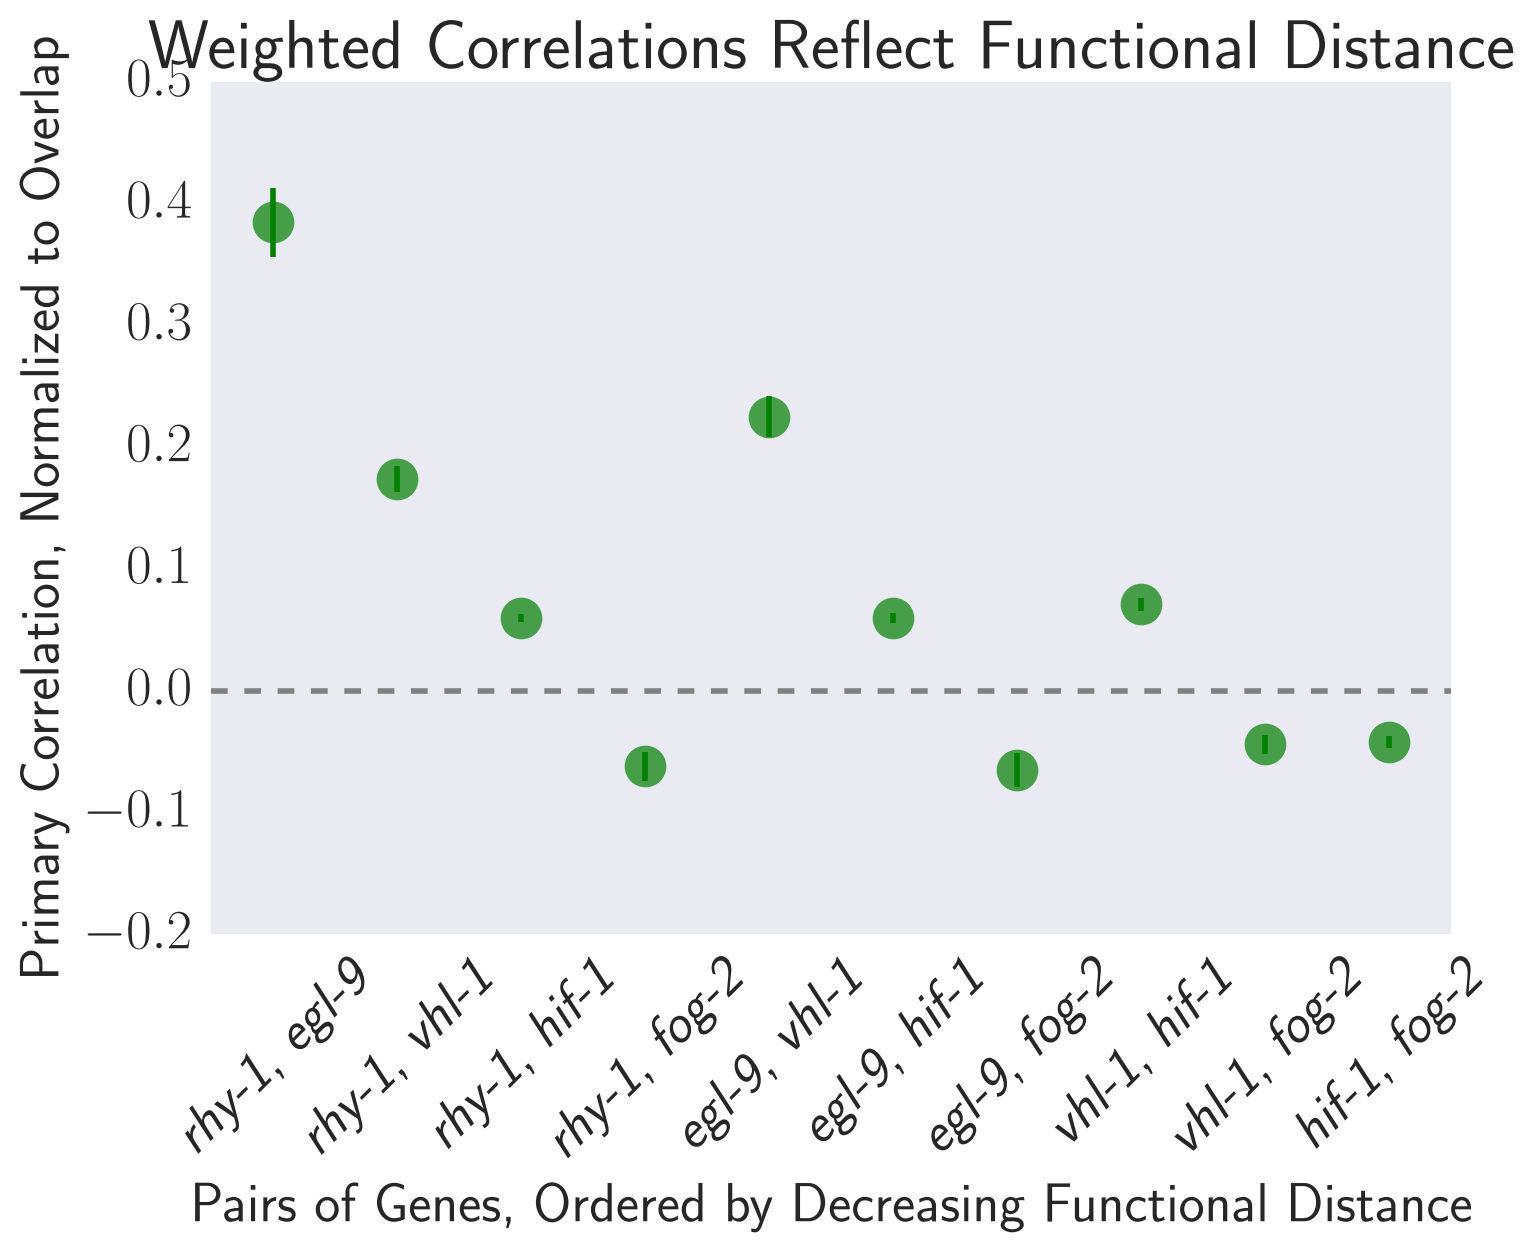

In [24]:
# generate a stripplot with all the 
sns.stripplot(x='genes', y='corrected',
              data=d[d.regression=='primary'], size=15,
              color='g', alpha=0.7)

# add errorbars:
# for each xtick and xticklabel
for x, xlabel in zip(plt.gca().get_xticks(),
                     plt.gca().get_xticklabels()):
    # get the data
    temp = d[d.regression=='primary']
    # get the gene ID
    f = temp.genes == xlabel.get_text() 
    # get the error bar gene ID
    f2 = e_plus.genes == xlabel.get_text() 
    # plot the errorbar
    plt.gca().errorbar(np.ones_like(temp[f].corrected.values)*x, 
                       temp[f].corrected.values,
                       yerr=e_plus[f2].value.values,
                       ls='none', color='g')

# prettify:
plt.xticks(rotation=45, fontsize=20)
# plt.yticks([-0.1, 0, 0.5], fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# pathify
pathify('Weighted Correlations Reflect Functional Distance',
        'Pairs of Genes, Ordered by Decreasing Functional Distance',
       'Primary Correlation, Normalized to Overlap')

# save
plt.savefig('../output/weighted_corr_decreases_w_distance.pdf')

## *hif-1* has negative interactions with *rhy-1*, and *egl-9*

If we look at the secondary, what picture emerges? The most striking picture is that there are two modes of interaction between *rhy-1* and *vhl-1*, *hif-1* and *fog-2*. In every case, the secondary interaction is considerably less than 10% of the total overlap. I will make the claim that these interactions are stronger and more important than we may believe at first sight, but I won't push it. We will wait until we have more datasets to show this. 

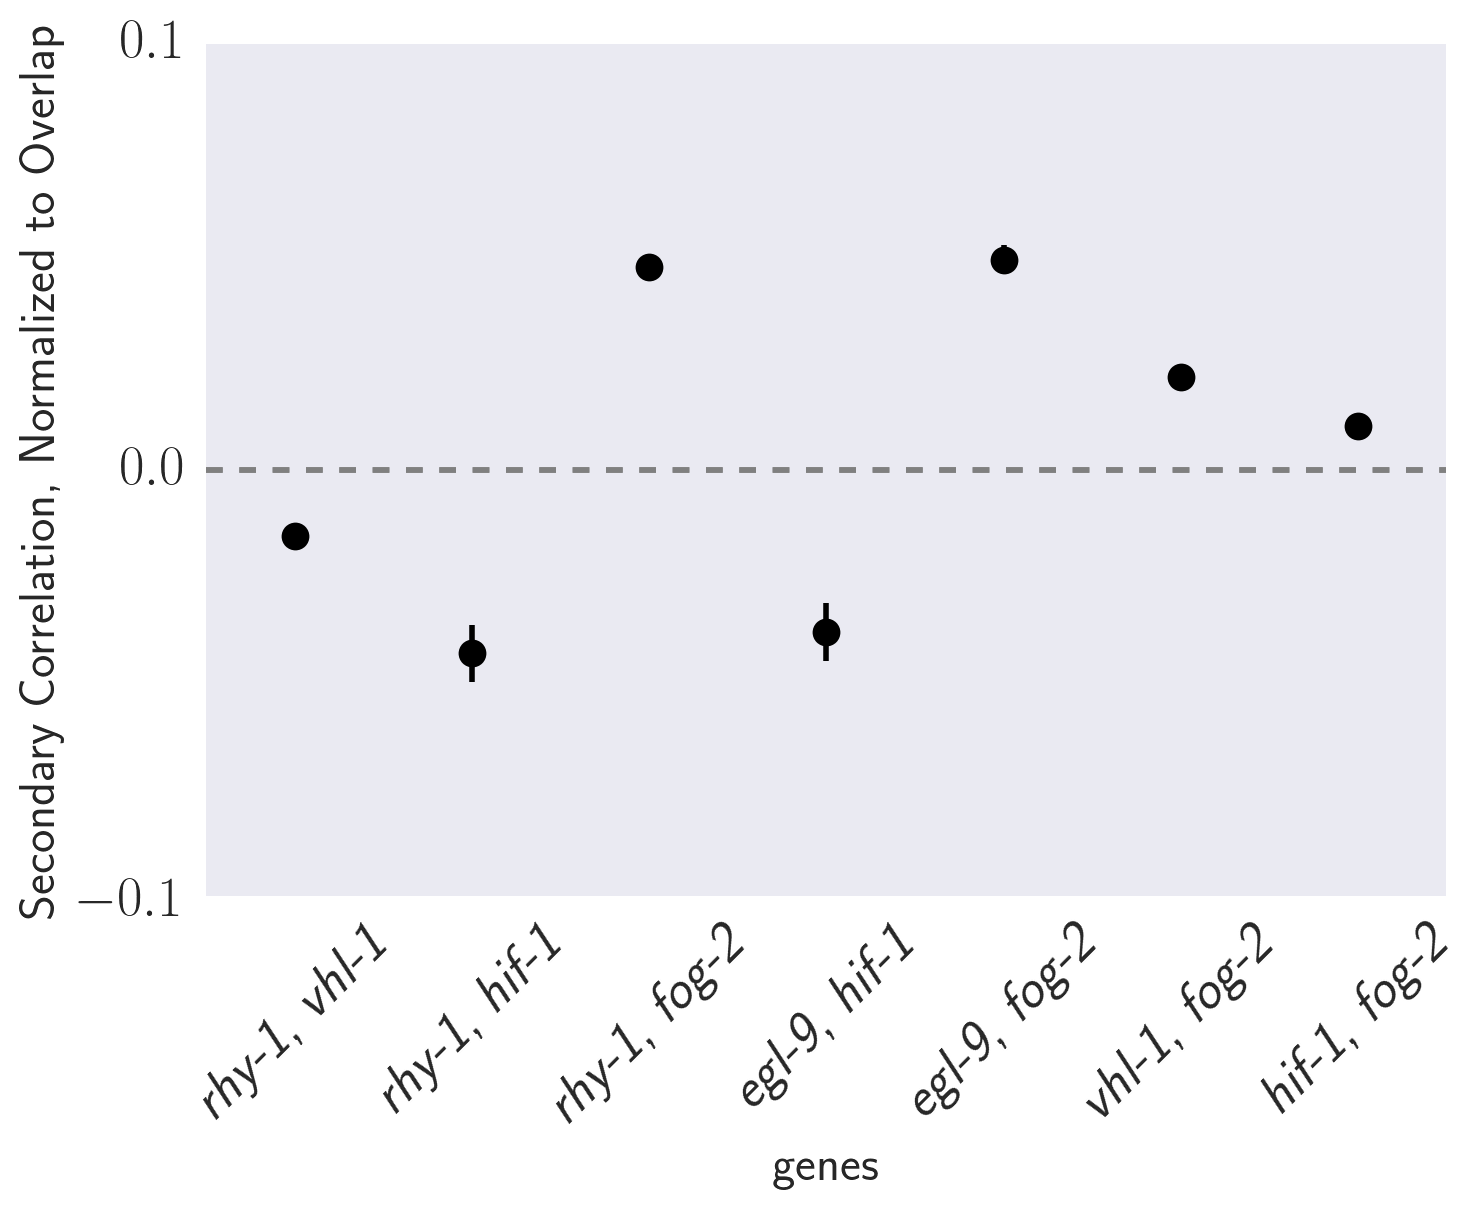

In [26]:
# plot secondary interactions
sns.stripplot(x='genes', y='corrected', 
              data=d[(d.regression=='secondary') &
                     (d.different == 1)],
              size=10, color='k')

# add errorbars:
for x, xlabel in zip(plt.gca().get_xticks(),
                     plt.gca().get_xticklabels()):
    temp = d[d.regression=='secondary']
    f = temp.genes == xlabel.get_text() 
    f2 = e_minus.genes == xlabel.get_text() 
    plt.gca().errorbar(np.ones_like(temp[f].corrected.values)*x, 
                       temp[f].corrected.values,
                       yerr=e_minus[f2].value.values,
                       ls='none', color='k')

# prettify
plt.axhline(0, ls='--', color='0.5')
plt.xticks(rotation=45, fontsize=20)
plt.yticks([-0.1, 0, 0.1], fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
plt.ylabel('Secondary Correlation, Normalized to Overlap')

# Figure 3 (Bottom) Correlation Graph

Now that I have estimated the primary correlation accurately, we can draw a network using these. This code will generate the bottom part of figure 3.

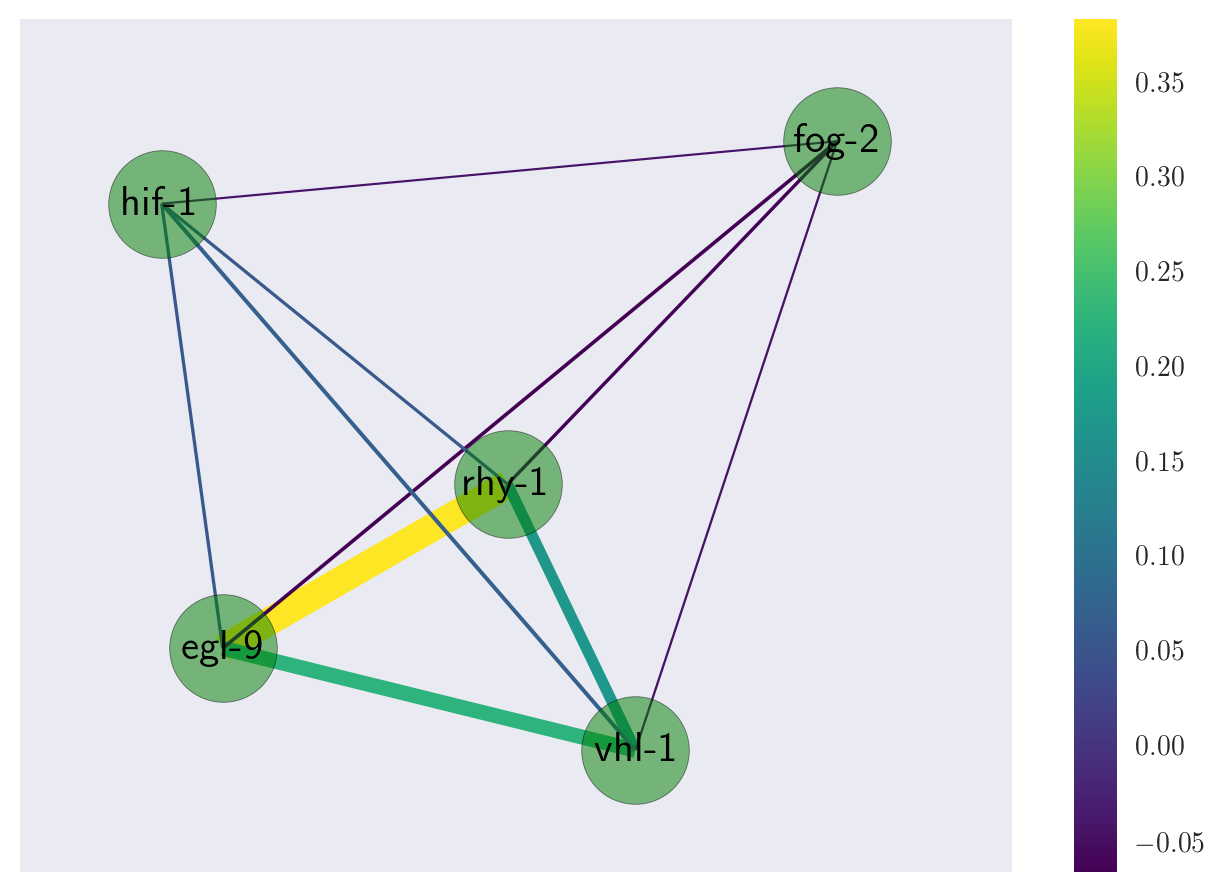

In [27]:
# initialize an empty graph:
G=nx.Graph()

# create a dictionary of labels to translate
mutant_dict = {'b': 'egl-9',
               'c': 'hif-1',
               'e': 'rhy-1',
               'd': 'vhl-1',
               'g': 'fog-2'
              }

# add edges between nodes
# go through each mutant:
for i, key in enumerate(thomas.single_mutants):
    # and through each mutant:
    for j, key2 in enumerate(thomas.single_mutants):
        # extract the correlation coefficient
        r = d[(d.variable == key) & (d.corr_with == key2) &
              (d.regression == 'primary')].corrected.values
        # only add an edge if a correlation coefficient exists:
        if r:
            # add the edge
            G.add_edge(mutant_dict[key],
                       mutant_dict[key2], weight=r[0])

# parameterize the edge and width and color of the graphs
# extract the edges:
elarge=[(u,v) for (u,v,d) in G.edges(data=True)]
# set the width -- I will use a slightly supra-linear function to 
# make the widths easier to discern to human eyes:
width=[30*np.abs(d['weight'])**1.15
       for (u,v,d) in G.edges(data=True)]
# extract the weights (keep these exact!)
weights=[d['weight'] for (u,v,d) in G.edges(data=True)]

# paint the canvas:
fig, ax = plt.subplots()
pos=nx.spring_layout(G)  # positions for all nodes

# draw the nodes:
nx.draw_networkx_nodes(G, pos, node_size=1500,
                       node_color='g', alpha=.5)

# draw the edges:
edges = nx.draw_networkx_edges(G, pos, edgelist=elarge,
                               width=width, edge_color=weights,
                               edge_cmap=plt.cm.viridis)

# add the labels:
nx.draw_networkx_labels(G, pos, font_size=15,
                        font_family='sans-serif')

# add a colorbar:
fig.colorbar(edges)

# de-tick and save
plt.xticks([])
plt.yticks([])
plt.savefig("../output/weighted_graph.pdf") # save as png
plt.show() # display

# Double Mutant Analysis

With double mutants, the analysis gets slightly more complicated. Now we're getting into full pathways!


Most importantly, however, we need to check the predictions from the model we built from the single mutants. 



## Primary Epistasis Analysis

In [28]:
# initialize the epistasis analysis object
alfred = morgan.sturtevant('epistasis analysis')
# perform primary epistasis analysis
alfred.epistasis_analysis(thomas)
# perform secondary epistasis analysis
alfred.epistasis_secondary(thomas, True)

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.6 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.4 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.5 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.3 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in

([<matplotlib.axis.YTick at 0x1ce2e8be0>,
 <a list of 3 Text yticklabel objects>)

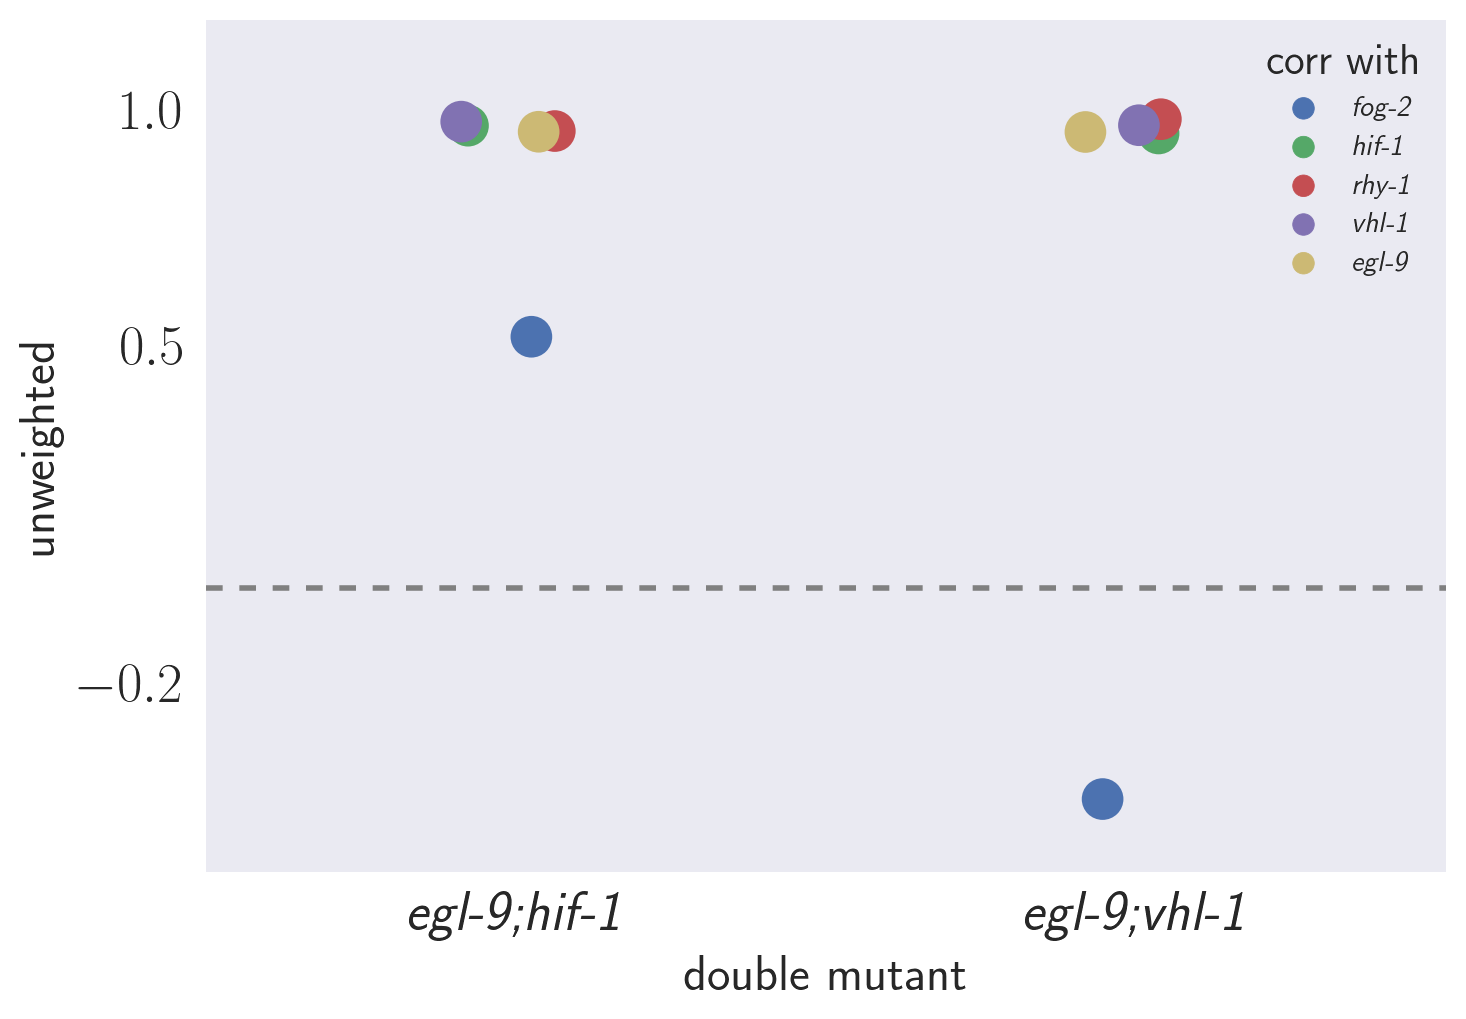

In [29]:
# plot the unweighted correlations

# back-calculate the unweighted correlations
t = alfred.epistasis
alfred.epistasis['unweighted'] = t.correlation/t.weights

# map the double mutant into its real name
alfred.epistasis['double mutant'] = t.double_mutant.map(genotype_mapping)

# get the name of the second gene the DM was correlated with
alfred.epistasis['corr with'] = t.corr_with.map(genotype_mapping)

# plot
sns.stripplot(x='double mutant', y='unweighted',
              hue='corr with', data=t,
              size=15, jitter=True)

# prettify
plt.xticks(fontsize=20)
plt.axhline(0, ls='--', color='0.5')
plt.yticks([-0.2, 0.5, 1], fontsize=20)

([<matplotlib.axis.YTick at 0x1ce4e4940>,
 <a list of 3 Text yticklabel objects>)

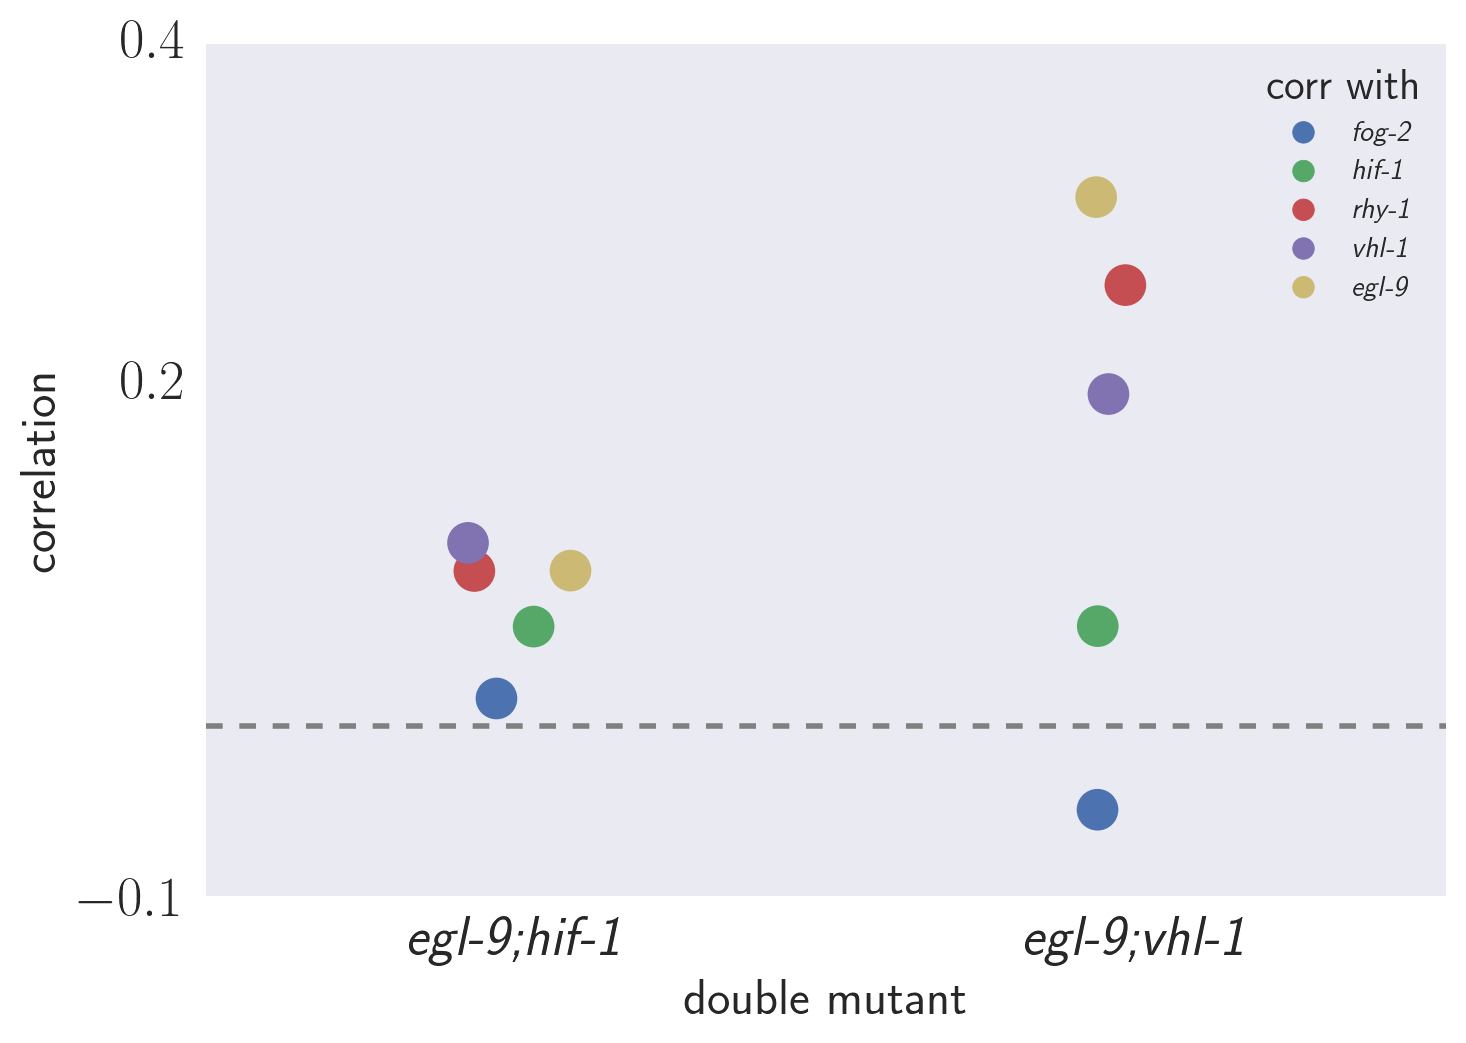

In [30]:
# plot the weighted correlation
sns.stripplot(x='double mutant', y='correlation',
              hue='corr with', data=t,
              size=15, jitter=True)
plt.xticks(fontsize=20)
plt.axhline(0, ls='--', color='0.5')
plt.yticks([-0.1, 0.2, 0.4], fontsize=20)

## Secondary Epistasis Analysis

(array([0, 1]), <a list of 2 Text xticklabel objects>)

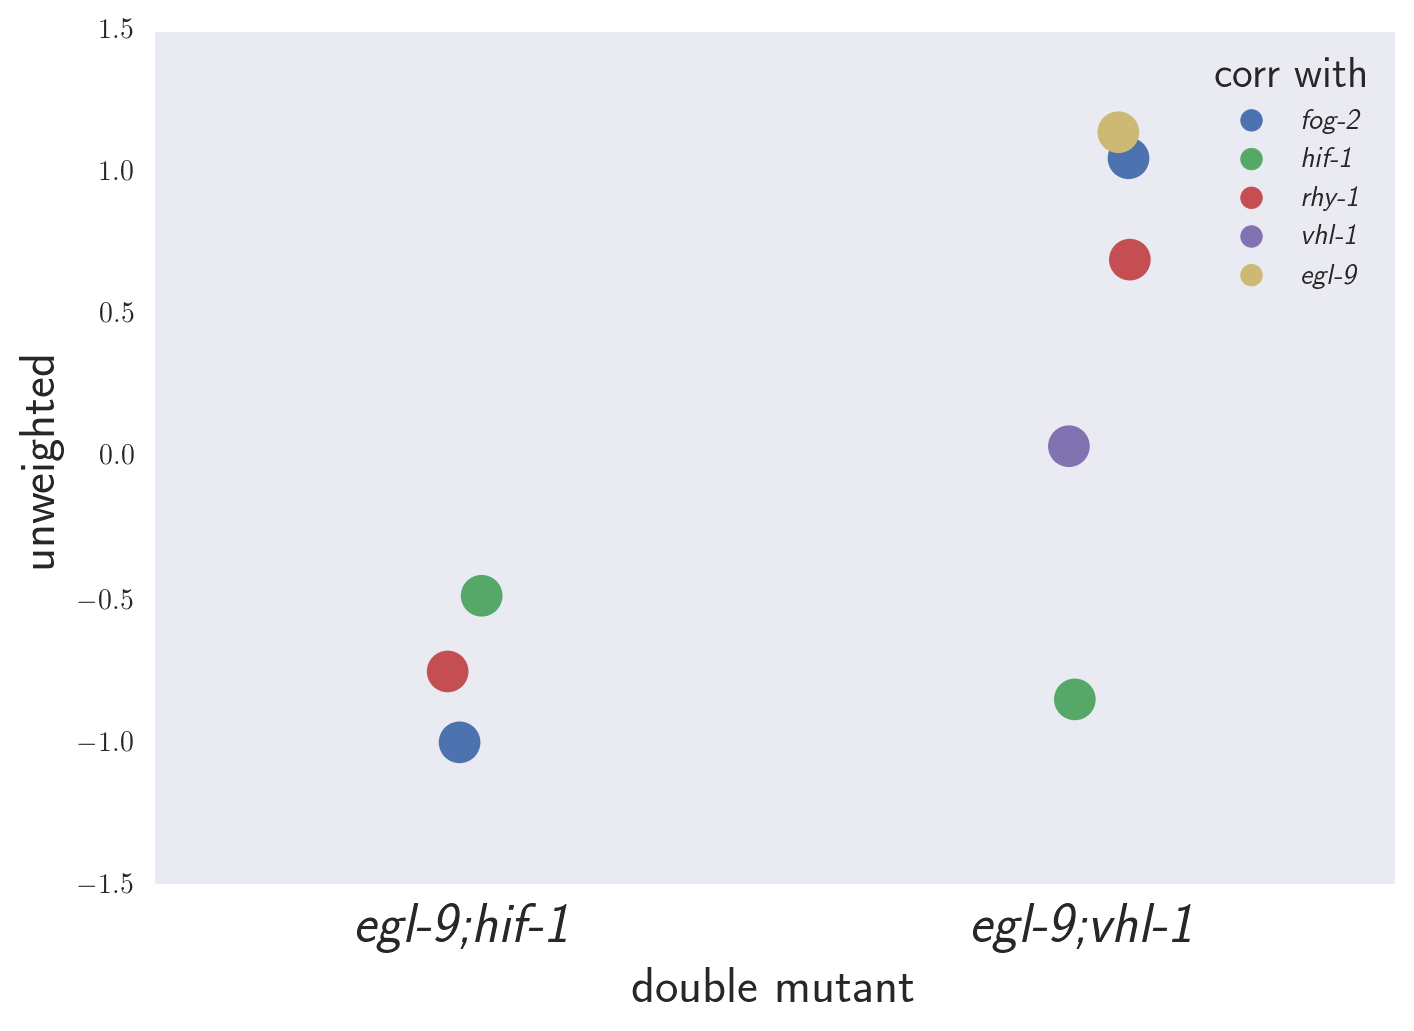

In [31]:
# analyze the secondary correlations between the double mutant and the singles:
t = alfred.epistasis_secondary
alfred.epistasis_secondary['unweighted'] = t.correlation/t.weights
alfred.epistasis_secondary['fractional corr'] = t.correlation/t.correlation.abs()

alfred.epistasis_secondary['double mutant'] = t.double_mutant.map(genotype_mapping)
alfred.epistasis_secondary['corr with'] = t.corr_with.map(genotype_mapping)

sns.stripplot(x='double mutant', y='unweighted',
              hue='corr with', data=t,
              size=15, jitter=True)
plt.xticks(fontsize=20)
# plt.ylim(-1.1, 1.1)
# plt.axhline(0, ls='--', color='0.5')
# plt.yticks([-1, 0, 1], fontsize=20)

# Table 1. Epistasis Can Be Quantified Via Linear Regression Models

Previously we have observed that correlations between double and single mutants might be informative. However, raw correlations alone are not the most informative in this situation. The reason is that the robust comparison (ranked genes) between single mutants and double mutants is not likely to be highly variable between single and double mutants under an additive model or even certain epistatic models. 

However, it is illustrative to look at a double mutant under an additive model. Consider that a double mutant ought to have extensive overlap with both single mutants that make it up. If the individual genes are interacting, then it makes sense that the double mutant should exhibit a perturbation proportional to the kind of relationship these genes share. Specifically, the genes that are involved in *both* genes will be the ones that will exhibit the expected perturbation. 

Therefore, the plan of attack should be as follows:
 * Identify the genes that appear in each single mutant and the double mutant
 * Run a linear regression on the regression coefficients between the single and the double mutant (these are two correlations).

If the mutants are additive, as would be expected if they both interact via a branched third party (i.e. *A* -> X; *B* -> X; X -> Output), then the double mutant should show worsening (a linear regression with slope $>1$). If they are interacting via a linear pathway, then the double mutant should have a linear slope with value of unity. If they share an inhibitory relationship, then the double mutant ought to have a slope $<1$. 

In the next steps, I will calculate these linear regressions. However, I will plot something slightly different. I will plot $\Delta$ versus the single mutant, where $\Delta = \beta_\mathrm{Double} - \beta_\mathrm{Single}$, and run the regression on the resulting values. The slopes that I will obtain will be trivially related to the ones I have described above by a scalar.

First, I will define a few functions, then plot the results.

In [129]:
def quadrature(x):
    """Variance of sums is sum of the variances."""
    def square(x):
        return x**2
    return np.sqrt(np.sum(x.apply(square)))

def identify(pair, df0, df1, double):
    """
    identify the genes that are altered
    in all of these mutant dataframes
    
    Params:
    pair = 
    """
    # predictions, single mutants
    df_pred0 = df0.copy()
    df_pred1 = df1.copy()
    
    # identify single mutants DE genes
    df_pred0 = df_pred0[df_pred0.qval < thomas.q]
    df_pred1 = df_pred1[df_pred1.qval < thomas.q]
    
    # find the predicted genes
    ind = df_pred0.target_id.isin(df_pred1.target_id)
    pred_genes = df_pred0[ind].target_id
    
    # get the double mutant
    df_test = thomas.beta[double]
    
    # find the predicted genes that show up in the double,
    # these constitute the final overlap
    df_test = df_test[df_test.target_id.isin(pred_genes) &
                      (df_test.qval< 0.1)].copy()
    
    # select only the overlapping genes
    df_pred0 = df_pred0[df_pred0.target_id.isin(df_test.target_id)]
    df_pred1 = df_pred1[df_pred1.target_id.isin(df_test.target_id)]
    
    # drop anything that is NA... hopefully that means dropping nothing... 
    df_pred0 = df_pred0.dropna(subset=['b'])
    df_pred1 = df_pred1.dropna(subset=['b'])
    df_test = df_test.dropna(subset=['b'])
    
    # return the damned thing
    return df_pred0, df_pred1, df_test

def plot_delta(prediction, test, fmt, label):
    """
    Given a prediction, calculates the delta between
    the prediction and the test, and plots the result.
    """
    # variance of the sum is sum of the variances:
    yerr = np.sqrt(test.se_b.values**2 +
                   prediction.se_b.values**2)
    # calculate the delta
    delta = test.b.values - prediction.b.values
    # plot the errorbar
    plt.errorbar(prediction.b.values, delta,
                 xerr=prediction.se_b.values,
                 yerr=yerr, fmt=fmt,
                 alpha=0.2, ms=4,
                 label=label)
    plt.legend()


def weighted_regression_delta(prediction, test):
    """
    Given a prediction and a test,
    find the weighted least squares regression between them.
    """
    # fit a WLS
    wls = stm.WLS(test.b.values - prediction.b.values, 
                  prediction.b.values,
                 weights=1./prediction.se_b.values**2)
    res_wls = wls.fit()
    return res_wls


def plot_epistasis_regression(prediction0, prediction1,
                              double, slope0, slope1):
    """Plot the WLS line."""
    # find the xmin and xmax:
    xmin = np.min([prediction0.b.min(),
                   prediction1.b.min()])
    xmax = np.max([prediction0.b.max(),
                   prediction1.b.max()])
    
    # make a linear array for x
    x = np.linspace(xmin - 0.1, xmax + 0.1, 1000)
    
    # make the models
    y0 = x*slope0
    y1 = x*slope1
    
    # plot the models
    plt.plot(x, y0, 'g-', lw=2)
    plt.plot(x, y1, 'b-', lw=2)


def print_WLS_summary(pair, slopes, res0, res1):
    """Print a string with the WLS results."""
    string = """mutant {0} slope: {1:.2g} +/- {2:.2g}, pvalue={3:.2g}"""
    print(string.format(pair[0], slopes[0],
                        res0.bse[0], res0.pvalues[0]))
    print(string.format(pair[1], slopes[1],
                        res1.bse[0], res1.pvalues[0]))

## Double Mutant *hif-1; egl-9* WLS epistatic analysis

mutant b slope: -0.85 +/- 0.074, pvalue=1e-13
mutant c slope: -0.18 +/- 0.1, pvalue=0.097

\emph{egl-9}: mean b = 1.5 +/- 0.41
\emph{hif-1}: mean b = 0.95 +/- 0.32
\emph{egl-9}, \emph{hif-1}: mean b = 1 +/- 0.36



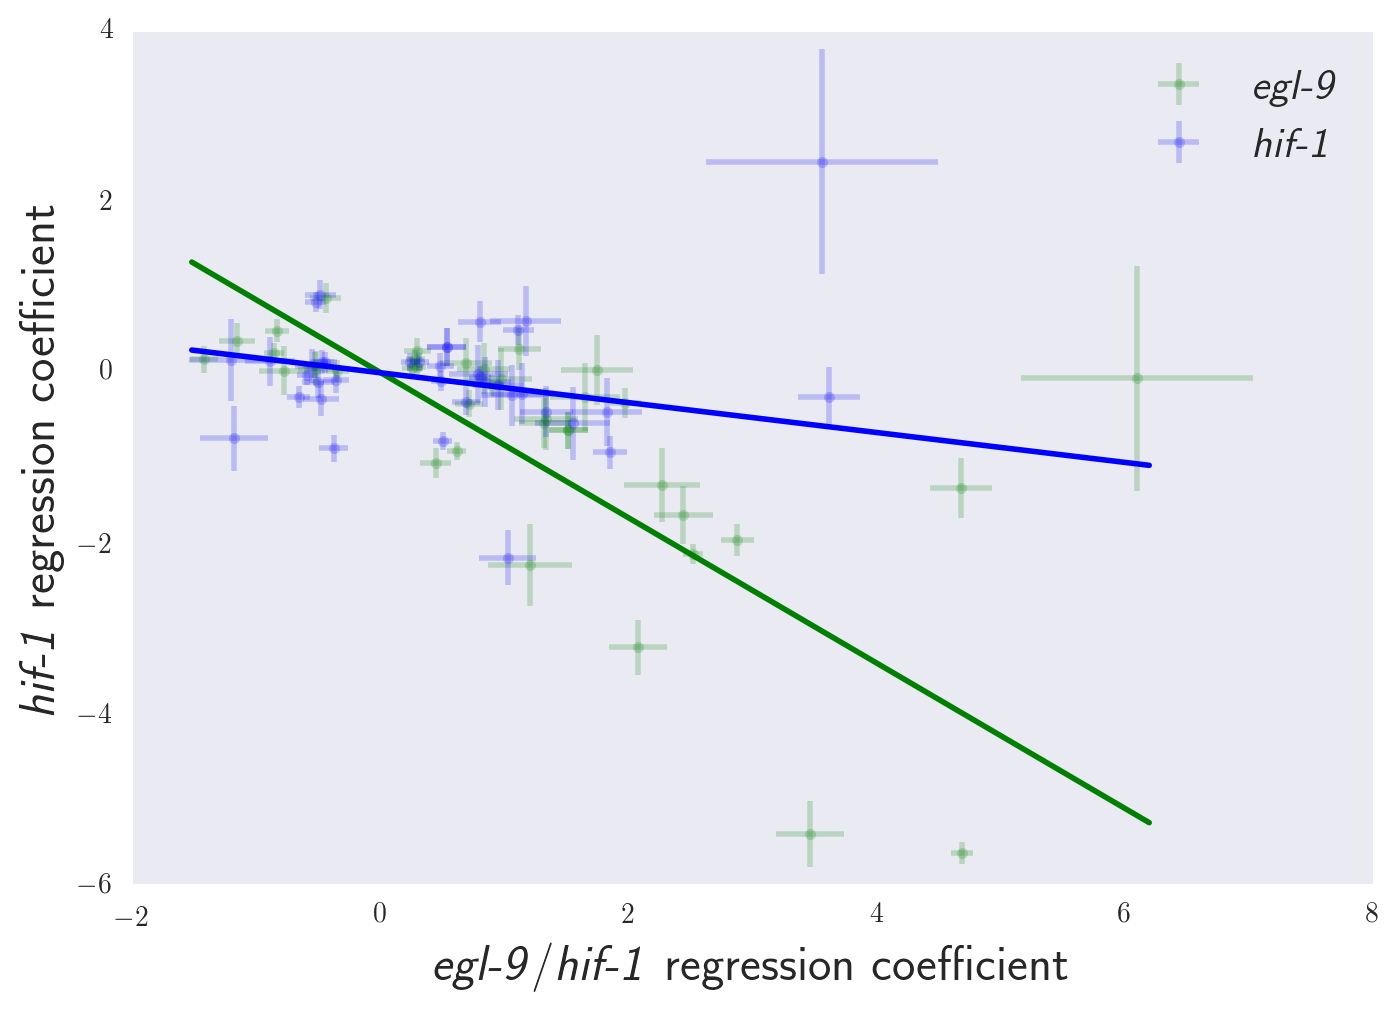

In [130]:
# specify which double to plot:
double = 'f'
# get the makeup of this mutant:
pair = thomas.double_muts[double]

# identify the relevant genes to study (see above)
results = identify(pair, thomas.beta_filtered[pair[0]],
                   thomas.beta_filtered[pair[1]], double)
df_pred0, df_pred1, df_test = results

# plot the prediction versus the delta:
plot_delta(df_pred0, df_test, 'go', genotype_mapping[pair[0]])
plot_delta(df_pred1, df_test, 'bo', genotype_mapping[pair[1]])

# perform the WLS
res_wls0 = weighted_regression_delta(df_pred0, df_test)
res_wls1 = weighted_regression_delta(df_pred1, df_test)

# get the slopes out:
egl_eglhif = res_wls0.params[0]
hif_eglhif = res_wls1.params[0]

# print a summary of the results
print_WLS_summary(pair, [egl_eglhif, hif_eglhif],
                  res_wls0, res_wls1)

# plot
plot_epistasis_regression(df_pred0, df_pred1,
                          df_test, egl_eglhif, hif_eglhif)

# prettify
xlab = '{0}/{1} regression coefficient'.format(genotype_mapping[pair[0]],
                                              genotype_mapping[pair[1]])
plt.xlabel(xlab)
ylab = '{0} regression coefficient'.format(genotype_mapping[pair[1]])
plt.ylabel(ylab)
plt.legend(fontsize=15)

# print out basic stats about the 'fold change'
# which should agree with WLS
def print_b_summary(pair, p1, p2, test):
    """A function to print out effect summaries."""
    adj_p1 = np.sqrt(quadrature(p1.se_b))
    adj_p2 = np.sqrt(quadrature(p2.se_b))
    adj_test = np.sqrt(quadrature(test.se_b))

    string = """
{0}: mean b = {3:.2g} +/- {6:.2g}
{1}: mean b = {4:.2g} +/- {7:.2g}
{2}: mean b = {5:.2g} +/- {8:.2g}
"""
    print(string.format(genotype_mapping[pair[0]],
                        genotype_mapping[pair[1]], 
                        decode_pairs[pair],
          p1.b.abs().mean(),
          p2.b.abs().mean(),
          test.b.abs().mean(),
          (p1.b.abs().std() + adj_p1)/np.sqrt(len(p1)),
          (p2.b.abs().std() + adj_p2)/np.sqrt(len(p2)),
          (test.b.abs().std() + adj_test)/np.sqrt(len(test)),
              )
          )

# print a summary of effects
print_b_summary(pair, df_pred0, df_pred1, df_test)


## Double Mutant *egl-9; vhl-1* WLS epistatic analysis

mutant b slope: 0.0023 +/- 0.0098, pvalue=0.81
mutant d slope: 0.28 +/- 0.033, pvalue=3.7e-16

\emph{egl-9}: mean b = 1.2 +/- 0.16
\emph{vhl-1}: mean b = 0.9 +/- 0.15
\emph{egl-9}, \emph{vhl-1}: mean b = 1.2 +/- 0.16



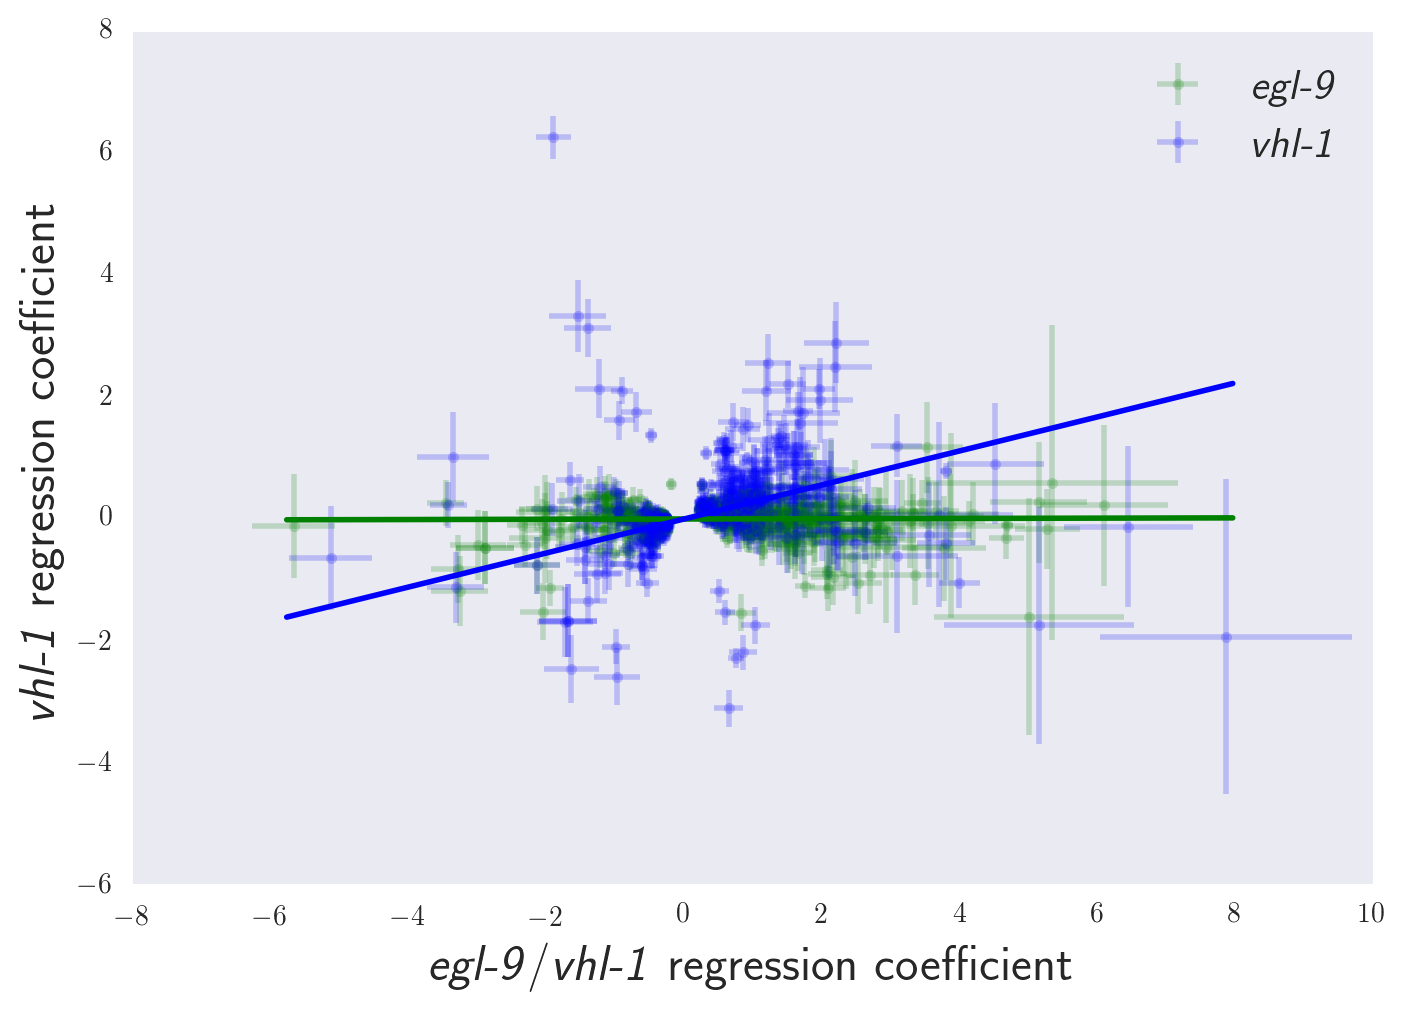

In [131]:
# specify which double to plot:
double = 'a'
# get the makeup of this mutant:
pair = thomas.double_muts[double]

# identify the relevant genes to study (see above)
results = identify(pair, thomas.beta_filtered[pair[0]],
                   thomas.beta_filtered[pair[1]], double)
df_pred0, df_pred1, df_test = results

# plot the prediction versus the delta:
plot_delta(df_pred0, df_test, 'go', genotype_mapping[pair[0]])
plot_delta(df_pred1, df_test, 'bo', genotype_mapping[pair[1]])

# perform the WLS
res_wls0 = weighted_regression_delta(df_pred0, df_test)
res_wls1 = weighted_regression_delta(df_pred1, df_test)

# get the slopes out:
egl_eglhif = res_wls0.params[0]
hif_eglhif = res_wls1.params[0]

# print a summary of the results
print_WLS_summary(pair, [egl_eglhif, hif_eglhif],
                  res_wls0, res_wls1)

# plot
plot_epistasis_regression(df_pred0, df_pred1,
                          df_test, egl_eglhif, hif_eglhif)

xlab = '{0}/{1} regression coefficient'.format(genotype_mapping[pair[0]],
                                              genotype_mapping[pair[1]])
plt.xlabel(xlab)
ylab = '{0} regression coefficient'.format(genotype_mapping[pair[1]])
plt.ylabel(ylab)
plt.legend(fontsize=15)

# print a summary of effects
print_b_summary(pair, df_pred0, df_pred1, df_test)


## *vhl-1* is epistatic to *egl-9*

The above graphs show that *vhl-1* is epistatic to *egl-9*. Tentative conclusions from the single mutants suggested that *vhl-1* either acted in a linear pathway with *egl-9*; or *egl-9* and *vhl-1* were branchpoints from or to *hif-1*.

Our epistatic analysis rules out the possibility that *egl-9* and *vhl-1* are downstream from *hif-1*. At this point, I can't yet explain whether the positive relationship is a linear pathway or an AND-gate. However, the fact that the *egl-9* phenotype is quantitatively worse than the *vhl-1* mutant, along with the fact that the double mutant has exactly the same *egl-9* phenotype suggests that *egl-9* has a secondary mode of inhibition with *hif-1*. 

## *egl-9* is suppressed by *hif-1*

This epistatic relationship suggests *hif-1* is inhibited by *egl-9*. 
 
Previously, our single mutant analysis suggested that *hif-1* and *egl-9* shared both positive and negative relationships. The double mutant shows that *egl-9* inhibits *hif-1* - this explains (at least partially) the negative relationship we observed in the single mutants.

Therefore, it follows that the positive relationship we observed in the single-mutants is the result of a feedback loop that activates *egl-9*. Moreover, this positive loop involves *rhy-1* (from the single mutant analysis). 

### The positive loop between *egl-9* and *hif-1*  makes it unlikely *vhl-1* participates linearly in this cycle

From the single mutant analysis, we saw that the coexpression overlaps between *vhl-1/hif-1* and *egl-9/hif-1*, and *vhl-1/hif-1* and *rhy-1/hif-1* was weaker than the coexpression overlap between *egl-9/hif-1* and *rhy-1/hif-1* suggests that *vhl-1* is excluded from this loop. Certainly it cannot act in between *rhy-1* and *egl-9* (it might act on either side). More thorough analysis will eventually point unequivocally to an AND-gate (see hand-written notes). 


# Double Mutants exhibit more than additive perturbations

In [66]:
# a short hack to show how little we understand about double mutants
for key, value in thomas.double_muts.items():
    # extract the double mutant
    x = thomas.beta_filtered[key]
    # extract the single mutants
    y = thomas.beta_filtered[value[0]]
    z = thomas.beta_filtered[value[1]]
    
    # identify DE genes
    x = x[x.qval < thomas.q]
    y = y[y.qval < thomas.q]
    z = z[z.qval < thomas.q]
    
    # no. genes that are DE in both single mutants
    yANDz = len(y[y.target_id.isin(z)])
    # no. genes that are DE in either
    yz = len(y) + len(z)
    # expected number of DE genes in DM
    expected = yz - yANDz
    
    # find the genes from SM_z in the double
    pred1 = x[(x.target_id.isin(z.target_id))]
    # find the genes from SM_y in the double
    pred2 = x[x.target_id.isin(y.target_id)]
    
    # find the non-redundant list of genes from
    # either mutant that appear in the DM
    pred = len(list(set(pred1.target_id.tolist()
                        + pred2.target_id.tolist())))
    
    # print out the results
    print(decode_pairs[value])
    print('Number of genes expected: ', expected)
    print('Number of genes observed: ', len(x))
    print('Number of genes successfully predicted: ', pred)
    print('Deviation from perturbation magnitude: {0:.2g}'.format(len(x)/expected))
    print('Predicted/Expected: {0:.2g}'.format(pred/expected))
    print('Fraction of genes explained by single mutants: {0:.2g}\n'.format(pred/len(x)))

\emph{egl-9}, \emph{hif-1}
Number of genes expected:  2095
Number of genes observed:  368
Number of genes successfully predicted:  217
Deviation from perturbation magnitude: 0.18
Predicted/Expected: 0.1
Fraction of genes explained by single mutants: 0.59

\emph{egl-9}, \emph{vhl-1}
Number of genes expected:  2221
Number of genes observed:  2129
Number of genes successfully predicted:  1269
Deviation from perturbation magnitude: 0.96
Predicted/Expected: 0.57
Fraction of genes explained by single mutants: 0.6



# Double Mutants Exhibit Complex Interactions

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.5 sec

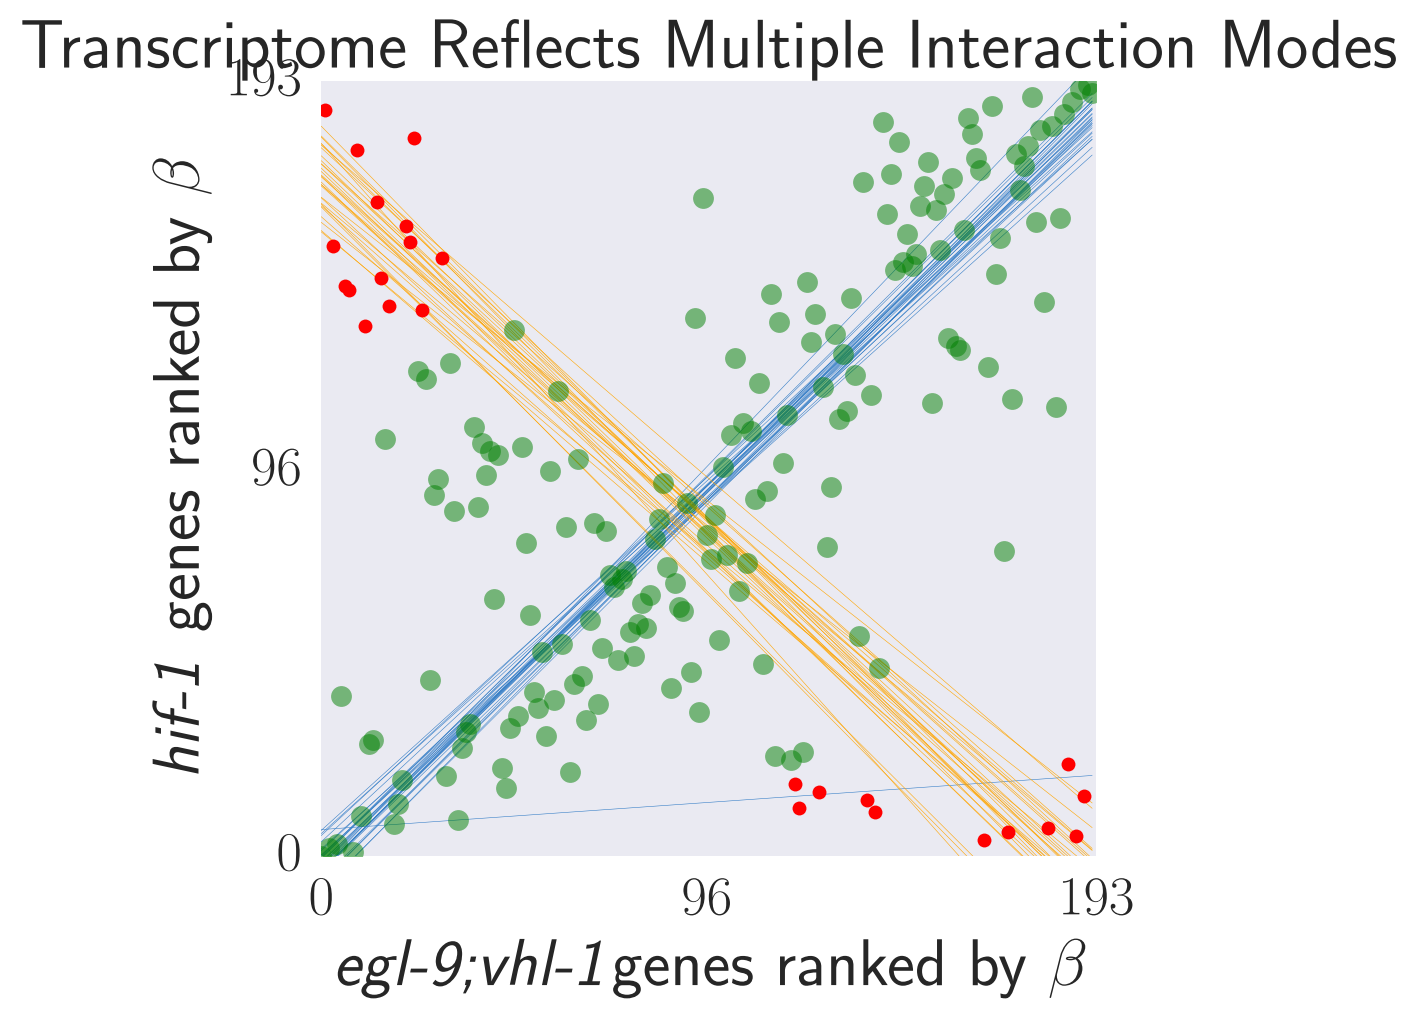

In [71]:
genes = 'target_id'
letters = ['a', 'c']

# datasets
x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

# overlap
ovx = x[lind(x)]
ovy = y[lind(y) & y[genes].isin(ovx[genes])].copy()
ovx = x[lind(x) & x[genes].isin(ovy[genes])].copy()

# find rank
ovx = find_rank(ovx)
ovy = find_rank(ovy)

# Take the data and place it
# into a dictionary to feed into the robust regression
data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())

# perform the simulation
trace_robust = robust_regress(data)

# draw a figure
plt.figure(figsize=(5, 5))

# some statistics.
# normalize everything so that all points are centered around 0
# by taking the y-coordinates and subtracting
# the value of the model at the point we calculated
intercept = trace_robust.Intercept.mean()
slope = trace_robust.x.mean()
distribution = ovy.r - intercept - ovx.r*slope
# find the mean and stdev of the distribution
# (even though mean should be 0 now)
mean = distribution.mean()
std = distribution.std()

# call the function
results = find_inliers(distribution, mean, trace_robust)
distribution_inliers, distribution_outliers, outliers = results
# run a secondary regression on the outliers
data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r,
             y=ovy[ovy.target_id.isin(outliers)].r)

# run the second trace
trace_robust2 = robust_regress(data2)

# get the y-coordinate of the inliers and outliers
yri = distribution_inliers + intercept + ovx.r*slope
yro = distribution_outliers + intercept + ovx.r*slope

# plot the regression lines
label = 'posterior predictive regression lines'
pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label=label,
                                 color='#357EC7')
pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
                                 label=label,
                                 color='#FFA500')

# plot the data. Inliers are plotted as 
#large green dots, outliers as small red dots
plt.plot(ovx.r, yri, 'go', ms = 7.5, alpha=0.5)
plt.plot(ovx[yro > 0].r, yro[yro > 0], 'ro', ms = 5)

# prettify plot
plt.xlim(0, len(ovx))
plt.ylim(0, len(ovy))
plt.yticks([0, np.floor(len(ovx)/2), len(ovx)], fontsize=20)
plt.xticks([0, np.floor(len(ovx)/2), len(ovx)], fontsize=20)
pathify('Transcriptome Reflects Multiple Interaction Modes', 
        genotype_mapping[letters[0]] + r'genes ranked by $\beta$', 
        genotype_mapping[letters[1]] + r' genes ranked by $\beta$',
        labelsize=24)
comp = letters[0] + letters[1]
plt.savefig('../output/multiple_modes_{0}.pdf'.format(comp))

# Quality Control

Load up the hypoxia gold standard Carmie gave me. These genes are expected to go up in everything except in Hif-1. 

By this point, I have solved the network, I guessed which gene was Hif-1 and I have been told the identities of the genes. 

C = Hif-1  
B = egl-9  
D = vhl-1  
E = rhy-1  

nhr-57 is an important gene for hypoxia. WBID is WBGene00003647

In [52]:
# Figure out how many hits we get and if the pvalue is significant!
for sm in thomas.single_mutants:
    df = thomas.beta_filtered[sm]
    ind = (genpy.find(df, hypoxia_gold.WBIDS,
                      col='ens_gene'))
    found = df[ind & (df.qval < 0.1)]
    sig = df[df.qval < 0.1]
    pval = sts.hypergeom.sf(len(found),
                            len(df),
                            len(hypoxia_gold),
                            len(sig))
    print('genotype: ', sm)
    print('found: ', len(found), 
          '  Mean b: {0:.2g}'.format(found.b.mean()))
    print('pval: {0:.2g}'.format(pval))
    
    
    print('Maximum change was:')
    print(found[found.b == found.b.max()].ext_gene.values[0])
    print(np.exp(found[found.b == found.b.max()].b.values)[0],
          ' fold change')
    if 'WBGene00003647' in found.ens_gene.values:
        ind = found.ens_gene == 'WBGene00003647'
        nhr57 = np.exp(found[ind].b.values[0])
        print('nhr-57 is in', sm,
              'and its fold change was {0:.2g}'.format(nhr57))

    print('----------')

genotype:  g
found:  4   Mean b: -1.4
pval: 0.22
Maximum change was:
nhr-57
0.534489095703  fold change
nhr-57 is in g and its fold change was 0.53
----------
genotype:  d
found:  7   Mean b: 2.2
pval: 2.7e-06
Maximum change was:
dod-3
44.7574873949  fold change
nhr-57 is in d and its fold change was 7.1
----------
genotype:  b
found:  9   Mean b: 2.6
pval: 5.7e-05
Maximum change was:
oac-54
66.7297848473  fold change
nhr-57 is in b and its fold change was 63
----------
genotype:  e
found:  10   Mean b: 2.4
pval: 4.7e-05
Maximum change was:
nhr-57
45.6749505822  fold change
nhr-57 is in e and its fold change was 46
----------
genotype:  c
found:  1   Mean b: 0.49
pval: 0.19
Maximum change was:
rhy-1
1.62443595728  fold change
----------


# An *in silico* qPCR experiment:

qPCR is a powerful technique for establishing genetic pathways. In fact, this pathway was originally mapped using qPCR. 

Here, I can perform an *in silico* version of this technique by individually exploring the genes in question (after all, their mRNA levels are measured and in our database). In order to establish the veracity of this tool, I will show a positive reporter for the hypoxia pathway, *nhr-57*, which has been used in multiple previous publications. I also show a negative control, *lam-3*, which is not known to interact in the hypoxia pathway or with the *fog-2* genotype. 

The results will help me cement the final network.

In [72]:
sorter = {'a': 6,
          'f': 7,
          'b': 2,
          'c': 4,
          'd':3,
          'e': 1,
          'g': 5
         }

x = ['WBGene00001851',
     'WBGene00012324',
     'WBGene00001178',
     'WBGene00006922',
     'WBGene00003647',
     'WBGene00002248'
    ]

# run the experiment!
def qPCR_prep(morgan, genelist):
    g = []
    data = np.array([])
    i = 0
    for genotype, df in thomas.beta.items():
        for j, xi in enumerate(genelist):
            geno = genotype_mapping[genotype]
            cols = ['ens_gene', 'ext_gene','b', 'se_b', 'qval']
            y = df[(df.ens_gene == xi)][cols]
#             print(y, geno)
            if len(y) == 0:
                continue
            # hif has two isoforms, so take F38A6.3c
            if y.shape[0] > 1:
                y = y[y.qval == y.qval.min()]
            if len(data) == 0:
                data = y.values
            else:
                data = np.vstack((data, y.values))
            g += [genotype]
        i += 1

    d = pd.DataFrame(data, columns=cols)
    d['code'] = g
    d['genotype'] = d.code.map(genotype_mapping)
    d['order'] = d.code.map(sorter)
    d.sort_values('order', inplace=True)
    d.reset_index(inplace=True)  
    return d

d = qPCR_prep(thomas, x)

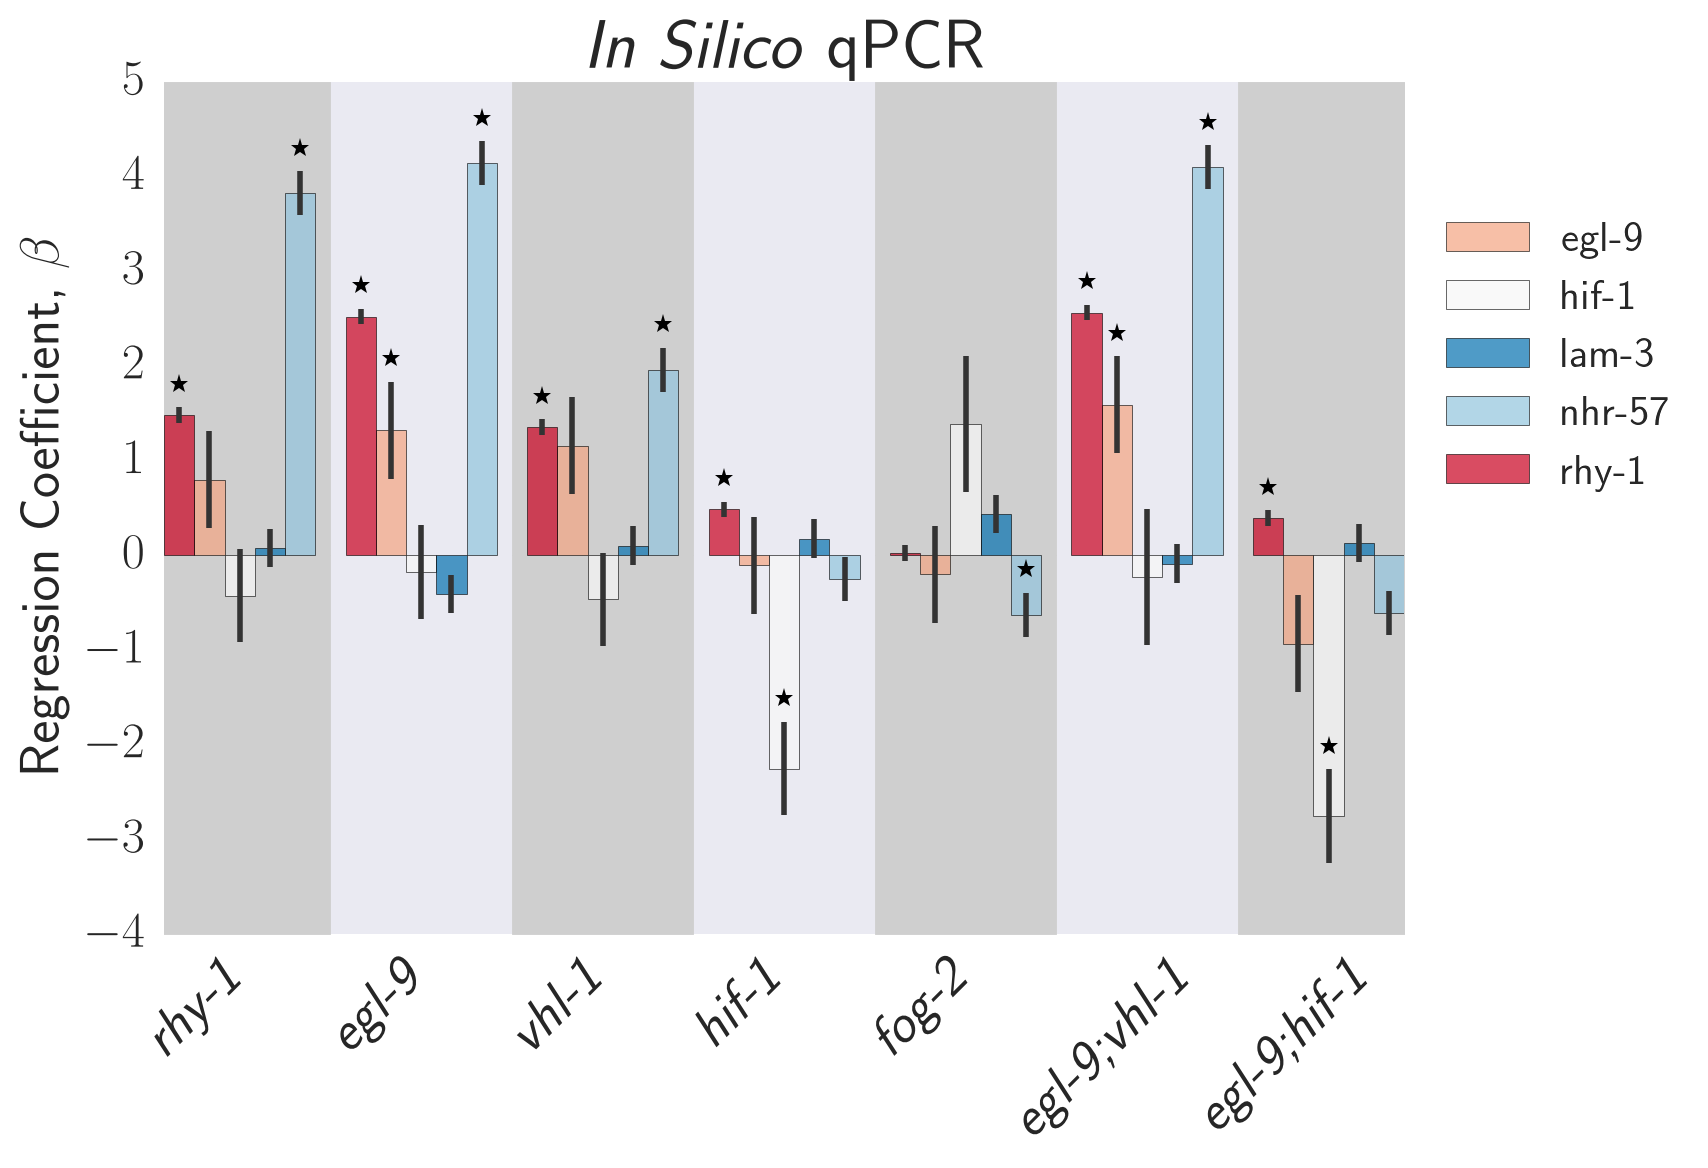

In [77]:
# a qPCR barplot
temp = d
index = np.linspace(0, temp.genotype.unique().shape[0]-1,
                    temp.genotype.unique().shape[0])
alpha = 0.7
error_config = {'ecolor': '0.2'}

plotting = {'rhy-1': 0,
            'egl-9': 1,
            'hif-1': 2,
            }

color = {'rhy-1': "#ca0020",
         'egl-9': '#f4a582',
         'hif-1': '#f7f7f7',
         'nhr-57':'#92c5de',
         'lam-3': '#0571b0'
        }

grouped = temp.groupby('ext_gene')

bar_width = 1/(len(grouped)+1)

for name, group in grouped:
    if name not in plotting.keys():
        where = max(plotting.keys(),
                    key=lambda k: plotting[k])
        val = plotting[where]
        plotting[name] = val + 1
    
    add = plotting[name]*bar_width
    if name in color.keys():
        barlist = plt.bar(index + add, group.b.values,
                          bar_width, alpha=alpha,
                          yerr=group.se_b.values,
                          error_kw=error_config, label=name,
                          color=color[name])
    else:
        barlist = plt.bar(index + add, group.b.values,
                          bar_width, alpha=alpha,
                          yerr=group.se_b.values,
                          error_kw=error_config, label=name)
    sig = group.qval < 0.1
    k = group[sig].order -1 
    plt.plot(k + add + bar_width/2,
             group[sig].b.values + group[sig].se_b.values + 0.25,
             r'*', color='k')

grouped2 = temp.groupby('genotype')
k = 0
col = '#CFCFCF'
for name, group in grouped2:
    if k % 2 == 0:
        xmin = k - bar_width*0.5
        xmax = k + bar_width*(len(grouped) + 0.5)
        ymin, ymax = plt.gca().get_ylim()
        plt.fill_between([xmin, xmax], ymax, color=col)
        plt.fill_between([xmin, xmax], ymin, color=col)
    k += 1

plt.xlim(0, plt.gca().get_xlim()[1] - bar_width)
plt.tick_params(axis='y',
                which='major', labelsize=18)
plt.xticks(index + bar_width,
           temp.genotype.unique(), rotation=45, fontsize=20)
pathify(r'\emph{In Silico} qPCR', '',
        r'Regression Coefficient, $\beta$', )
plt.legend(loc=(1.02, 0.5),fontsize=15)
plt.savefig('../output/pathwaygenes_qPCR.pdf',
            bbox_inches='tight')

From the qPCR, I can see that *nhr-57* is induced by the *egl-9* knockout, and is suppressed in the *hif-1;egl-9* mutant, supporting the previous epistatic analysis showing that *egl-9* inhibits *hif-1*. *nhr-57* is also induced in *rhy-1* and *vhl-1* knockouts, supporting our hypothesis that *vhl-1* and *rhy-1* both inhibit *hif-1* also. Notice that *nhr-57* is more strongly induced in *egl-9* than in *vhl-1*, and that the double mutant exhibits the same level of *nhr-57* as the *egl-9* mutant, supporting the idea that *egl-9* exerts greater control over *hi-1* than *vhl-1*.

We have shown that *in silico* qPCR is a useful tool and we also have established the veracity of our dataset.

Proceeding to a network analysis, we can see that *rhy-1* is induced by *hif-1* activation, and this activation is induced in the *egl-9;vhl-1* double mutant. It is also possible that *egl-9* is induced by *hif-1* activation: In all cases when *hif-1* is induced, *egl-9* increases, although only in the *egl-9* mutants does *egl-9* mRNA increase beyond statistical significance. At most, we can state that *egl-9* is self-inhibiting (correlating with *hif-1* induction) and we can speculate that this self-inhibition is mediated by *hif-1*. 

We can also observe that *rhy-1* is induced by the loss of *hif-1*. This suggests that *rhy-1* is under both positive and negative regulation by *hif-1*! 

Finally, we can observe that *hif-1* levels decrease in the *hif-1* mutants. This raises the possibility that *hif-1* is autoactivating. However, we cannot rule out that this decrease is due to increased instability of the mRNA as well as the decreased mass of mRNA due to the size of the deletion. Thus, we suggest, but cannot conclude that *hif-1* is autoactivating.

The *in silico* qPCR suggests that the hypoxia circuit exihibits extensive feedback in many directions. Moreover, the different transcriptomic phenotypes strongly suggest that this circuit exhibits different levels of control, both transcriptional and (post-)translational.


# Searching for a TF that has positive regulatory relationships with both *egl-9* and *hif-1*

This would be an interesting and cool transcription factor, if it exists! 

In [85]:
# Figure out how many hits we get and if the pvalue is significant!
tfs = {}
for sm in thomas.single_mutants:
    df = thomas.beta_filtered[sm]
    # find all transcription factors in this df
    ind = (genpy.find(df, tf_df.target_id,
                      col='target_id'))
    # extract the TFs
    found = df[ind & (df.qval < 0.1)]
    sig = df[df.qval < 0.1]
    # calculate the pvalue
    pval = sts.hypergeom.sf(len(found),
                            len(df),
                            len(hypoxia_gold),
                            len(sig))
    # print message
    print('genotype: ', genotype_mapping[sm])
    print('found: ', len(found),
          '   Mean b: {0:.2g}'.format(found.b.mean()))
    print('pval: {0:.2g}'.format(pval))
    tfs[sm] = found.copy()
        
    print('----------')

genotype:  \emph{fog-2}
found:  44    Mean b: 0.15
pval: 0
----------
genotype:  \emph{hif-1}
found:  15    Mean b: 0.19
pval: 2.3e-19
----------
genotype:  \emph{rhy-1}
found:  31    Mean b: 0.49
pval: 0
----------
genotype:  \emph{vhl-1}
found:  10    Mean b: 0.64
pval: 5.4e-10
----------
genotype:  \emph{egl-9}
found:  21    Mean b: 0.6
pval: 0
----------


In [56]:
def add_b(x):
    vals = tfs['c'][tfs['c'].target_id == x]
    if len(vals):
        return vals.b.values[0]
    else:
        return np.nan

temp = tfs['b']
temp['b_c'] = temp.target_id.apply(add_b)

In [57]:
temp[(temp.b_c < 0) &
     (temp.b < 0)][['ext_gene','b_c','b', 'qval']]

ext_gene      b_c         b      qval
5522    mxl-3 -0.89506 -0.781183  0.002857

In [58]:
# mxl-3 should be down in the egl, hif double:
temp = thomas.beta_filtered['f']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

ext_gene         b      qval
5522    mxl-3 -0.757522  0.020871

In [59]:
temp = thomas.beta_filtered['a']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

ext_gene         b      qval
5522    mxl-3 -0.319002  0.404185

In [60]:
temp = thomas.beta_filtered['e']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

ext_gene         b      qval
5522    mxl-3 -0.343135  0.388758

In [61]:
temp = thomas.beta_filtered['d']
temp[(temp.ext_gene == 'mxl-3')][['ext_gene', 'b', 'qval']]

ext_gene         b      qval
5522    mxl-3 -0.383277  0.465043

# Distribution of effect sizes in different mutants

In [81]:
# make arrays of b and q values for each dataframe
for key in thomas.beta.keys():
    df = thomas.beta_filtered[key]
    if len(bs) == 0:
        bs = df.b.values
        qs = df.qval.values
    else:
        bs = np.vstack((bs, df.b.values))
        qs = np.vstack((qs, df.qval.values))

In [82]:
# place those values into neat dataframes:
b_df = pd.DataFrame(np.transpose(bs),
                    columns = thomas.beta.keys())
q_df = pd.DataFrame(np.transpose(qs),
                    columns = thomas.beta.keys())
b_df = pd.melt(b_df, var_name='genotype',
               value_name='b')
q_df = pd.melt(q_df, var_name='genotype',
               value_name='q')

# add some useful plotting columns
b_df['abs b'] = b_df.b.abs()
b_df['sorter'] = b_df.genotype.map(sorter)
q_df['sorter'] = q_df.genotype.map(sorter)
b_df.sort_values('sorter', inplace=True)
q_df.sort_values('sorter', inplace=True)
b_df['names'] = b_df.genotype.map(genotype_mapping)

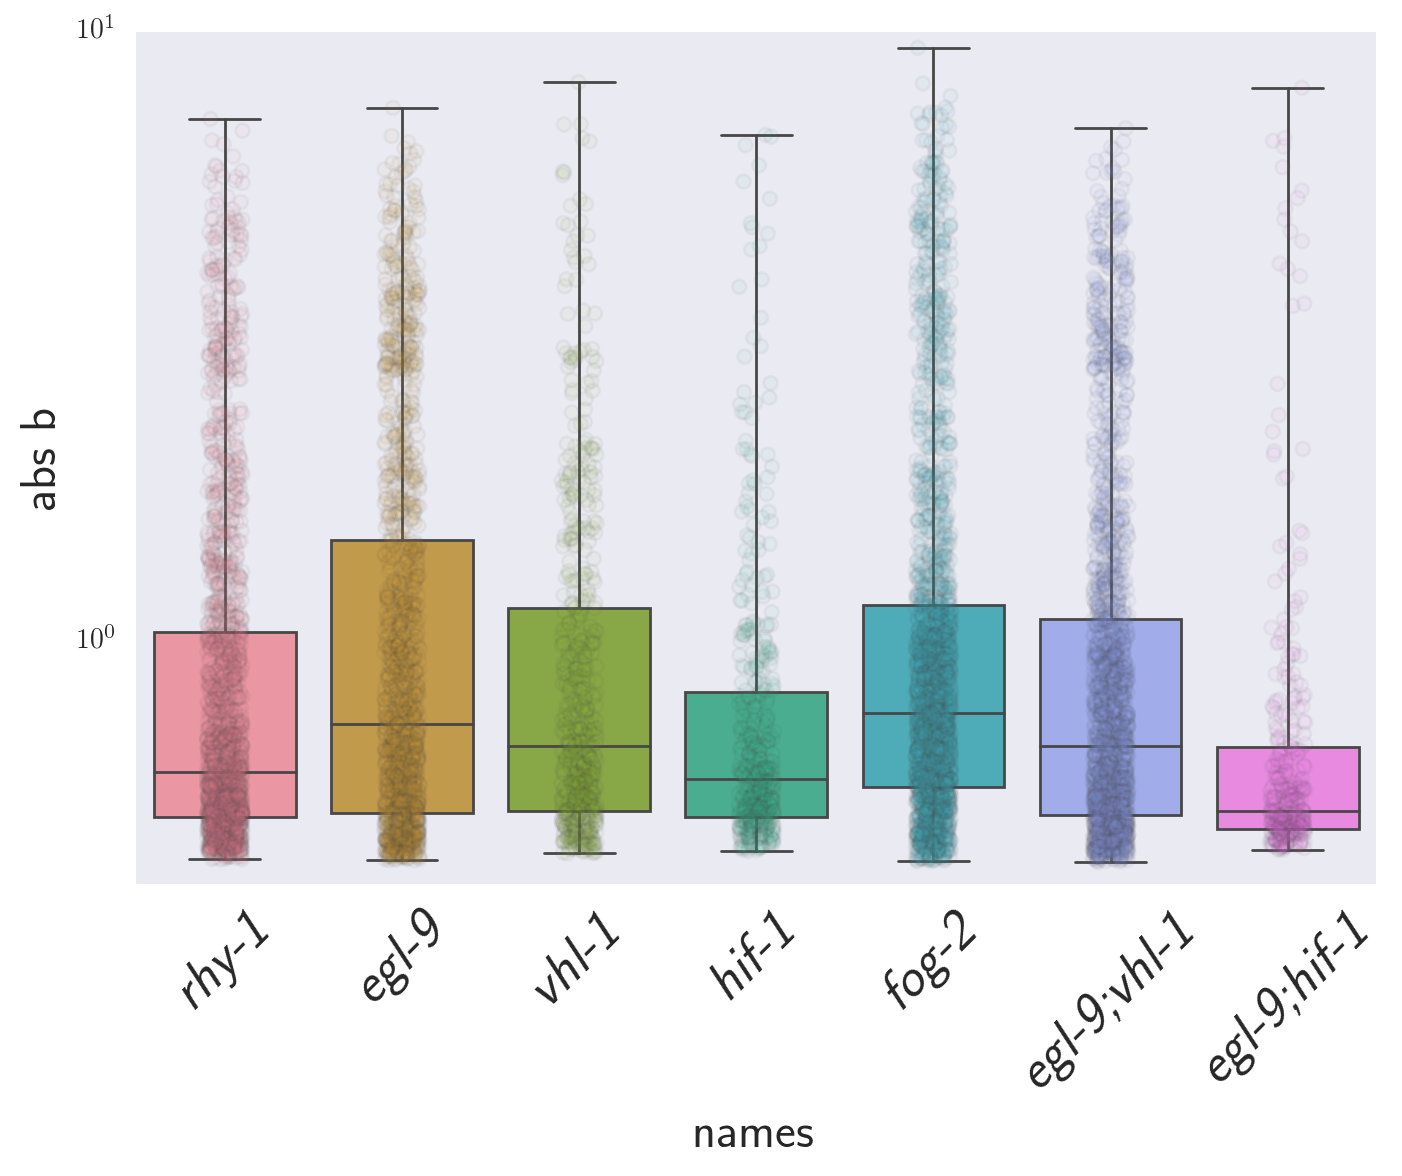

In [83]:
# plot boxplots
sns.boxplot(x="names", y="abs b",
            data=b_df[q_df.q < 0.1],
            whis=np.inf, linewidth=1)
# add stripplot
sns.stripplot('names', 'abs b',
              data=b_df[q_df.q < 0.1],
              linewidth=1, jitter=True,
              alpha=0.05)
# prettify
plt.xticks(fontsize=20, rotation=45)
plt.ylim(10**-1, 10)
plt.yscale('symlog')

# Finding direct targets of *hif-1*, *vhl-1*, *egl-9* and *rhy-1*

## Hydroxylated *hif-1* direct targets
Knocking out *hif-1* should decrease levels of hydroxylated and non-hydroxylated *hif-1*

Knocking out *vhl-1* should increase levels of both forms. 

Knocking out *egl-9* or *rhy-1* should decrease the hydroxylated form and increase the non-hydroxylated form. 

Knocking out *egl-9;hif-1* should decrease levels of hydroxylated and non-hydroxylated *hif-1*

Therefore:
Overlap *hif-1*, *egl-9* and *rhy-1* mutants with coexpression and find only targets that go DOWN. Next, overlap *vhl-1* with anti-expression. These are the hydroxylated targets of *hif-1* and possibly some other stuff

In [169]:
df1 = thomas.beta['f'].copy()
df2 = thomas.beta['c']
df3 = thomas.beta['e']
df4 = thomas.beta['b']
df5 = thomas.beta['a'] 
df6 = thomas.beta['d']

df1['b_c'] = df2.b
df1['b_e'] = df3.b
df1['b_b'] = df4.b
df1['b_a'] = df5.b
df1['b_d'] = df6.b

df1['se_b_c'] = df2.se_b
df1['se_b_e'] = df3.se_b
df1['se_b_b'] = df4.se_b
df1['se_b_a'] = df5.se_b
df1['se_b_d'] = df6.se_b

df1['q_c'] = df2.qval
df1['q_e'] = df3.qval
df1['q_b'] = df4.qval
df1['q_a'] = df5.qval
df1['q_d'] = df6.qval

ind = (df1.qval < 0.1) & (df1.q_c < 0.1) & (df1.q_e < 0.1) &\
      (df1.q_b < 0.1) & (df1.q_a < 0.1) & (df1.q_d < 0.1)

ind2 = (df1.b < 0) & (df1.b_c < 0) & \
       (df1.b_e < 0) & (df1.b_b < 0) & (df1.b_a < 0)
ind3 = (df1.b_d > 0)

df1[ind & ind2 & ind3][['ext_gene', 'b_d', 'q_d']]


ext_gene       b_d           q_d
9850   F20D6.11  0.589394  3.392273e-03
11479     cat-4  0.751071  1.325726e-08

We find two genes. . It's possible that we just couldn't measure the hydroxylated *hif-1* targets properly because 
A less stringent filter would be to just anti-overlap the *vhl-1* with the (*egl-9* and *rhy-1*) mutants and see what comes up. This means we are no longer measuring *hif-1* directly, rather, we are inferring it and hoping that the noise from other stuff that these genes have in common gets drowned out. 

In [148]:
# significant in all relevant depts.
ind = (df1.q_e < 0.1) & (df1.q_b < 0.1) &\
      (df1.q_a < 0.1) & (df1.q_d < 0.1) 
# loss of egl causes hif-OH to go down
ind2 = (df1.b_e < 0) & (df1.b_b < 0) & (df1.b_a < 0) 
ind3 = (df1.b_d > 0) # vhl causes hif-OH to go UP
hydroxylated_hif = df1[ind & ind2 & ind3]
cols = ['ext_gene', 'b_d', 'q_d', 'b_e']
hydroxylated_hif[cols].sort_values('q_d').head()

ext_gene       b_d           q_d       b_e
11479     cat-4  0.751071  1.325726e-08 -0.763864
15045  F55G11.2  0.854800  1.708696e-03 -0.587116
9850   F20D6.11  0.589394  3.392273e-03 -0.554782
15953     asp-8  0.646281  6.687030e-02 -1.769170

Nope! It looks that even our less stringen filter yields quite the small list of targets!

## Non-hydroxylated *hif-1* targets

Let's find the genes associated with non-hydroxylated hypoxia factor next. 

Knocking out *hif-1* should decrease levels of hydroxylated and non-hydroxylated *hif-1*

Knocking out *vhl-1* should increase levels of both forms. 

Knocking out *egl-9* or *rhy-1* should decrease the hydroxylated form and increase the non-hydroxylated form. 

Knocking out *egl-9;hif-1* should decrease levels of hydroxylated and non-hydroxylated *hif-1*

Therefore:
Overlap *vhl-1*, *egl-9* and *rhy-1* mutants with coexpression and find only targets that go UP. Next, overlap *hif-1* with anti-expression. These are  targets of non-hydroxylated *hif-1* and possibly some other stuff

In [149]:
ind = ((df1.qval < 0.1) & (df1.q_c < 0.1) &
       (df1.q_e < 0.1) & (df1.q_b < 0.1) &
       (df1.q_a < 0.1) & (df1.q_d < 0.1))
ind2 = ((df1.b_e > 0) & (df1.b_b > 0) &
        (df1.b_a > 0) & (df1.b_d > 0))
ind3 = (df1.b < 0) & (df1.b_c < 0)

df1[ind & ind2 & ind3][['ext_gene', 'b_e', 'q_e']].sort_values('q_e')

ext_gene       b_e           q_e
19626  R08E5.3  4.577666  0.000000e+00
31611    nit-1  3.369282  4.598481e-32

Again, we observe only very few genes. Let's try to remove the *hif-1;egl-9* double mutant to increase our sample size:

In [150]:
ind = ((df1.q_c < 0.1) & (df1.q_e < 0.1) &
       (df1.q_b < 0.1) & (df1.q_a < 0.1) &
       (df1.q_d < 0.1))
ind2 = ((df1.b_e > 0) & (df1.b_b > 0) &
        (df1.b_a > 0) & (df1.b_d > 0))
ind3 = (df1.b_c < 0)
df1[ind & ind2 & ind3][['ext_gene', 'b_e', 'q_e']].sort_values('q_e')

ext_gene       b_e           q_e
19626   R08E5.3  4.577666  0.000000e+00
26372  Y37A1B.5  2.590956  1.489199e-70
31611     nit-1  3.369282  4.598481e-32
20101  R12C12.5  0.488469  3.239911e-06
12288  hsp-12.3  1.473647  2.173847e-05

We can definitely say that these are the best candidates for direct control by *hif-1*. However, the list could probably still be larger. 

Let's weaken the conditions a little bit. Now, we will only require that whatever our candidate genes are, they should not be **significantly upregulated in response to loss of hif-1**.

In [151]:
ind =  ((df1.q_e < 0.1) & (df1.q_b < 0.1) &
        (df1.q_a < 0.1) & (df1.q_d < 0.1))
ind2 = ((df1.b_e > 0) & (df1.b_b > 0) &
        (df1.b_a > 0) & (df1.b_d > 0))
ind3 = (~((df1.q_c < 0.1) & (df1.b_c > 0)) &
        ~((df1.qval < 0.1) & (df1.b > 0)))
hypoxia_direct_targets = df1[ind & ind2 & ind3]
print(hypoxia_direct_targets.shape[0])
hypoxia_direct_targets[['ext_gene', 'b_e', 'q_e']].sort_values('q_e').head()


133


ext_gene       b_e           q_e
19626   R08E5.3  4.577666  0.000000e+00
4509    C31C9.2  2.469312  1.688359e-99
10774   F26H9.5  1.599513  9.709034e-91
26372  Y37A1B.5  2.590956  1.489199e-70
21073    nhr-57  3.821550  1.190906e-57

Now we're talking! We can definitely say that these are the best candidates for direct control by *hif-1*.

If we are willing to let go of the difference between hydroxylated and non-hydroxylated *hif-1*, we could remove the *hif-1* filters entirely. However, I think these 167 genes are probably enough for now. Let's take a moment now to verify that this result matches what is known in the literature:

In [152]:
ids = hypoxia_direct_targets.ens_gene.unique()
_ = tea.enrichment_analysis(ids, tissue_df, show=True)
_ = tea.enrichment_analysis(ids, phenotype_df, show=True)
_ = tea.enrichment_analysis(ids, go_df, show=False)
_[0].head()

Executing script

Analysis returned no enriched tissues.
Executing script

Analysis returned no enriched tissues.
Executing script



Tissue  Expected  Observed  \
56                           cell division GO:0051301  6.305256        29   
52  S-adenosylmethionine-dependent methyltransfera...  6.076788        27   
85  cellular modified amino acid metabolic process...  0.356141         8   
50        regulation of hydrolase activity GO:0051336  0.552130         8   
23                             nucleoplasm GO:0005654  0.073916         4   

    Enrichment Fold Change       P value       Q value  
56                4.599338  1.711157e-13  1.132786e-10  
52                4.443137  3.100307e-12  1.026202e-09  
85               22.463041  1.106555e-10  2.441799e-08  
50               14.489345  5.091683e-09  8.426735e-07  
23               54.115508  1.324114e-08  1.753127e-06

## Quality control on identified genes:

Before we call these *hif-1* targets, we should make sure that at least some known targets are contained in this set. In order to do this, we have curated a list of 20 or so genes that have been published before as *hif-1* targets.

That being said though, we need to be aware of 1 major issue with this dataset. 

*hif-1* and *rhy-1* form an incredibly tight loop. There is a LOT of feedback between *hif-1* and *rhy-1*. Given the kind of logic we are using, we are probably excluding a number of targets as a result. In fact, the logic we have used to develop this list excludes *rhy-1* itself, a known *hif-1* target! I could do better, but not without a lot more lines of code, and it just doesn't seem reasonable to do this. 

In [153]:
ind = hypoxia_direct_targets.ens_gene.isin(hypoxia_gold.WBIDS)
found = hypoxia_direct_targets[ind].ens_gene.unique()
sig = len(hypoxia_direct_targets)
pval = sts.hypergeom.sf(len(found),
                        len(thomas.beta_filtered['a']),
                        len(hypoxia_gold), sig)    

if pval < 10**-3:
    print('This result is statistically significant \
with a p-value of {0:.2g} using a hypergeometric test.\
You found {1} gold standard genes!'.format(pval, len(found)))

This result is statistically significant with a p-value of 4.2e-08 using a hypergeometric test.You found 5 gold standard genes!


Very nice! We are actually sampling from the hif-1 pool! Fantastic! 

## Identifying *rhy-1* targets

Next, let's identify rhy-1 associated genes. We will also insist that rhy-1 genes NOT be associated with hif-1 (they really shouldn't be, the logic between these two sets is mutually exclusive, I think, but it's best to make sure; let's hit stuff with a hammer):

In [154]:
ind =  ((df1.q_e < 0.1) & (df1.q_b < 0.1) &
        (df1.q_a < 0.1) & (df1.q_c < 0.1))
ind2 = ((df1.b_e*df1.b_b > 0) & (df1.b_e*df1.b_a > 0) &
        (df1.b_c*df1.b_e > 0) & (df1.b_c*df1.b_b > 0))
ind3 = (~df1.target_id.isin(hypoxia_direct_targets.target_id))
rhy1_targets = df1[ind & ind2 & ind3]
print(rhy1_targets.shape)
rhy1_targets[['ext_gene', 'b_e', 'q_e']].sort_values('q_e').head()

(74, 31)


ext_gene       b_e           q_e
24825     rhy-1  1.482076  9.672920e-71
31240   ZC317.7  2.144840  9.204531e-63
3949    C26B9.3  2.686908  2.936705e-40
20836  T04A11.1  2.014769  5.957883e-35
20843  T04A11.4  2.014769  5.957883e-35

In [155]:
ids = rhy1_targets.ens_gene.unique()
_ = tea.enrichment_analysis(ids, tissue_df, show=True)
_ = tea.enrichment_analysis(ids, phenotype_df, show=True)
_ = tea.enrichment_analysis(ids, go_df, show=False)
_[0].head()

Executing script

Analysis returned no enriched tissues.
Executing script

Analysis returned no enriched tissues.
Executing script



Tissue  Expected  Observed  \
92   S-adenosylmethionine-dependent methyltransfera...  4.503972        31   
102                           cell division GO:0051301  4.673307        31   
83         regulation of hydrolase activity GO:0051336  0.409226        11   
25   regulatory region nucleic acid binding GO:0001067  0.751215        13   
87                  intracellular organelle GO:0043229  1.792126        17   

     Enrichment Fold Change       P value       Q value  
92                 6.882813  1.996962e-20  1.321989e-17  
102                6.633418  5.984858e-20  1.980988e-17  
83                26.880035  9.763471e-15  2.154473e-12  
25                17.305288  2.317441e-14  3.835364e-12  
87                 9.485939  1.063831e-13  1.408512e-11

## Identifying *egl-9* targets
OK! We found 'em. Let's find the *egl-9* related genes next.

In [156]:
ind =  ((df1.q_e < 0.1) & (df1.q_b < 0.1) &
        (df1.q_a < 0.1) & (df1.q_d > 0.1) &
        (df1.q_c > 0.1))
ind2 = ((df1.b_e*df1.b_b > 0) &
        (df1.b_e*df1.b_a > 0) &
        (df1.b_b*df1.b_a > 0))
#         & (df1.b_c*df1.b_e < 0) & (df1.b_c*df1.b_b < 0)\
#         & (df1.b_b*df1.b_d > 0) & (df1.b_e*df1.b_d > 0)
ind3 = True
# remember ids contains the hypoxia_direct_targets
ind4 = (~df1.target_id.isin(ids))
egl_targets = df1[ind & ind2 & ind3  & ind4]
print(egl_targets.ens_gene.unique().shape[0])
egl_targets[['ext_gene', 'b_b', 'q_b']].sort_values('q_b').head(5)

464


ext_gene       b_b           q_b
3558    C18H9.6 -3.021398  1.269703e-72
17056    nas-33  3.102550  4.313509e-38
25104  W10G11.3 -2.330393  8.491660e-34
9265      far-3  4.401688  3.042296e-33
15295     cdo-1  2.171999  6.303173e-32

In [157]:
egl_ids = egl_targets.ens_gene.unique()
_ = tea.enrichment_analysis(egl_ids,
                            tissue_df, show=True)
_ = tea.enrichment_analysis(egl_ids,
                            phenotype_df, show=False)
print(_[0].head())
_ = tea.enrichment_analysis(egl_ids,
                            go_df, show=False)
_[0].head(10)

Executing script

                               Tissue   Expected  Observed  \
0  anal depressor muscle WBbt:0004292  13.798814        30   

   Enrichment Fold Change   P value   Q value  
0                  2.1741  0.000011  0.002962  
Executing script

                                               Tissue   Expected  Observed  \
57          male mating defective WBPhenotype:0001414  12.377006        56   
8   hermaphrodite reproductive system morphology v...  29.285639        87   
13  cell component morphology variant WBPhenotype:...  15.662436        62   
67  organism region behavior variant WBPhenotype:0...   7.732089        44   
32       tail development variant WBPhenotype:0000805  12.575265        55   

    Enrichment Fold Change       P value       Q value  
57                4.524519  3.640752e-23  8.919842e-21  
8                 2.970739  1.114116e-22  1.364793e-20  
13                3.958516  2.052098e-22  1.405689e-20  
67                5.690571  1.721252e-22  1.40

Tissue   Expected  Observed  \
138                           cell division GO:0051301  28.707459       172   
126  S-adenosylmethionine-dependent methyltransfera...  27.667260       168   
114                 organic anion transport GO:0015711  16.016009       127   
198  hydrolase activity, acting on glycosyl bonds G...  16.694178       128   
28                     spliceosomal complex GO:0005681  11.829717       104   
108   monocarboxylic acid catabolic process GO:0072329  39.991581       145   
132                             neuron part GO:0097458   3.360251        46   
152  negative regulation of nucleic acid-templated ...   9.499466        67   
41         positive regulation of transport GO:0051050   3.824262        47   
174     aromatic compound catabolic process GO:0019439   2.457726        39   

     Enrichment Fold Change       P value       Q value  
138                5.991474  5.381701e-90  3.562686e-87  
126                6.072159  1.919953e-88  6.355045e-86  
114                7.929566  4.360124e-78  9.621340e-76  
198                7.667344  5.344039e-77  8.844385e-75  
28                 8.791419  1.781499e-67  2.358704e-65  
108                3.625763  2.580694e-46  2.847366e-44  
132               13.689452  1.463189e-38  1.383759e-36  
152                7.053028  3.722303e-37  2.891873e-35  
41                12.289953  3.494711e-37  2.891873e-35  
174               15.868330  1.675292e-35  1.109043e-33

## Identifying *vhl-1* targets
Next, let's find the vhl-related genes.

In [158]:
ind =  (df1.q_a < 0.1) & (df1.q_d < 0.1)
ind2 = (df1.b_d > 0) & (df1.b_a > 0)
ind4 = ((df1.q_e > 0.1) & (df1.q_b > 0.1) &
        (df1.q_b > 0.1))

vhl_targets = df1[ind & ind2 & ind4]
print(vhl_targets.shape[0])
vhl_targets[['ext_gene', 'b_d', 'q_d', 'b_b', 'b_e']].sort_values('q_d').head(10)

30


ext_gene       b_d           q_d       b_b       b_e
11227  F31C3.4  0.556422  1.653782e-08 -0.039171  0.069805
11226  F31C3.3  0.509236  5.936751e-07  0.108664  0.062222
24756    hgo-1  0.500935  3.375891e-06  0.099012 -0.092270
6937    mboa-3  0.506001  3.954259e-03  0.164309 -0.127737
11228    psf-2  0.592778  4.516616e-03  0.224087  0.094825
5991   C46C2.2  0.455548  4.771579e-03  0.255569 -0.016089
11606  F33H2.6  0.390757  6.374993e-03 -0.127979 -0.199501
31155   duxl-1  0.382592  6.407984e-03  0.136819  0.063909
11229  F31C3.6  0.576217  7.482708e-03  0.005797  0.059090
1132     cam-1  0.393836  1.444158e-02  0.201850  0.268705

In [159]:
vhl_ids = vhl_targets.ens_gene.unique()
_ = tea.enrichment_analysis(vhl_ids,
                            tissue_df, show=True)
_ = tea.enrichment_analysis(vhl_ids,
                            phenotype_df, show=True)
_ = tea.enrichment_analysis(vhl_ids,
                            go_df, show=False)
_[0].head(10)

Executing script

             Tissue  Expected  Observed  Enrichment Fold Change   P value  \
0  ADE WBbt:0005415  0.084783         2               23.589744  0.000069   

    Q value  
0  0.017912  
Executing script

Analysis returned no enriched tissues.
Executing script



Tissue  Expected  Observed  \
65  negative regulation of nucleic acid-templated ...  0.540021         7   
60                           cell division GO:0051301  1.631949        10   
50                             ion binding GO:0043167  0.488135         6   
42             cellular component assembly GO:0022607  0.016233         2   
54  S-adenosylmethionine-dependent methyltransfera...  1.572816         9   
2             divalent metal ion transport GO:0070838  0.193631         4   
58                      organelle assembly GO:0070925  0.377406         5   
49                 organic anion transport GO:0015711  0.910471         7   
6                                   growth GO:0040007  0.471903         5   
64                 protein oligomerization GO:0051259  0.290156         4   

    Enrichment Fold Change       P value   Q value  
65               12.962451  3.055214e-08  0.000020  
60                6.127644  1.209910e-07  0.000040  
50               12.291676  3.329950e-07  0.000073  
42              123.209416  5.800782e-07  0.000096  
54                5.722221  1.003315e-06  0.000133  
2                20.657866  1.210482e-06  0.000134  
58               13.248324  1.485861e-06  0.000141  
49                7.688330  1.619081e-06  0.000141  
6                10.595404  5.362519e-06  0.000394  
64               13.785669  8.635508e-06  0.000572

# Identifying New Biology - understanding the role of *rhy-1* and *egl-9* in the *hif-1* dependent response

The extensive feedback loops suggest that there should be a subset of genes that are coexpressed in every single mutant studied here. Moreover, there should be some genes that go up in every single mutant and down in every single mutant. Because these genes are probably very tightly linked, and have been measured 6x3 times, they would constitute high-confidence genes. Studying these genes will hopefully clarify the epistasis relationships by removing noise and finding genes that are only associated with the core circuit we have selected; identify genes that are tightly linked and crucial for the stress response; and make for very nice interactive graphics.

In [160]:
# select all the genes that are stat. sig. with the exception
# of the egl-9;hif-1 suppressor
ind = ((df1.q_c < 0.1) & (df1.q_e < 0.1) &
      (df1.q_b < 0.1) & (df1.q_a < 0.1) &
       (df1.q_d < 0.1))
y = df1[ind].copy()
y.shape

(55, 31)

## Genes that go down in all hypoxia mutants

In [176]:
y_bs = df1[ind][['ens_gene', 'b_e', 'b_b', 'b_d', 'b_c', 'b', 'b_a']]
all_down = y_bs[y_bs<0].dropna().index
s = 'Number of genes that go down: {0}'
message = s.format(y_bs.shape[0])
print(message)

Number of genes that go down: 22


In [70]:
cols = ['ext_gene', 'ens_gene', 
        'b_e', 'b_b', 'b_d', 'b_c', 'b_a',
        'q_e', 'q_b', 'q_d', 'q_c', 'q_a']
sel = df1.index.isin(y_bs[y_bs<0].index)
all_down = df1[sel][cols].sort_values('q_a')
all_down.to_csv('../output/all_down.csv', index=False)
ids = all_down.ens_gene.unique()
_ = tea.enrichment_analysis(ids,
                            tissue_df, show=True)
_ = tea.enrichment_analysis(ids,
                            phenotype_df, show=True)
_ = tea.enrichment_analysis(ids,
                            go_df, show=False)
_[0].head()

Executing script

Analysis returned no enriched tissues.
Executing script

                                              Tissue  Expected  Observed  \
0  postembryonic cell lineage variant WBPhenotype...  0.503514         4   
1  cell cycle timing defective early emb WBPhenot...  0.292038         3   

   Enrichment Fold Change   P value   Q value  
0                7.944167  0.000129  0.031593  
1               10.272629  0.000191  0.031593  
Executing script



Tissue  Expected  Observed  \
66  S-adenosylmethionine-dependent methyltransfera...  3.288615        21   
10                           cell division GO:0051301  3.412256        21   
50                             ion binding GO:0043167  1.020646        12   
12  regulatory region nucleic acid binding GO:0001067  0.548507         9   
7                  organic anion transport GO:0015711  1.903712        14   

    Enrichment Fold Change       P value       Q value  
66                6.385667  8.694608e-14  5.755830e-11  
10                6.154286  1.835900e-13  6.076829e-11  
50               11.757255  1.555222e-11  3.431856e-09  
12               16.408191  1.530384e-10  2.532786e-08  
7                 7.354055  2.622568e-10  3.472279e-08

## Genes up in all hypoxia mutants

In [175]:
all_up = y_bs[y_bs>0].dropna().index
s = 'Number of genes that go down: {0}'
message = s.format(y_bs.shape[0])
print(message)

cols = ['ext_gene', 'ens_gene', 
        'b_e', 'b_b', 'b_d', 'b_c', 'b_a',
        'q_e', 'q_b', 'q_d', 'q_c', 'q_a']
all_up = df1[df1.index.isin(all_up)][cols].sort_values('q_a')
all_up.to_csv('../output/all_up.csv', index=False)
ids = all_up.ens_gene.unique()
_ = tea.enrichment_analysis(ids,
                            tissue_df, show=True)
_ = tea.enrichment_analysis(ids,
                            phenotype_df, show=True)
_ = tea.enrichment_analysis(ids,
                            go_df, show=False)
_[0].head()

Number of genes that go down: 22
Executing script

Analysis returned no enriched tissues.
Executing script

                                              Tissue  Expected  Observed  \
0  ciliated neuron morphology variant WBPhenotype...  3.267807         4   
1                     aneuploidy WBPhenotype:0001882  0.433861         3   

   Enrichment Fold Change   P value   Q value  
0                1.224063  0.000000  0.000000  
1                6.914652  0.000138  0.016867  
Executing script



Tissue  Expected  Observed  \
13                 protein complex binding GO:0032403  0.002899         1   
21           regulation of eating behavior GO:1903998  0.003030         1   
24                      protein lipidation GO:0006497  0.088541         2   
23  monovalent inorganic cation homeostasis GO:005...  0.018973         1   
20       intracellular signal transduction GO:0035556  0.016997         1   

    Enrichment Fold Change   P value   Q value  
13              344.986364  0.000004  0.002386  
21              329.986957  0.000004  0.002386  
24               22.588393  0.000079  0.012063  
23               52.706250  0.000159  0.012063  
20               58.834884  0.000128  0.012063

# Bokeh Epistasis Plots

In [290]:
def bokeh_plot_epistasis(df, gx, gy, qx, qy, se_gx, se_gy,
                         tooltips, title, xlabel):
    """A function to plot the bokeh epistasis."""
    # Make the hover tool
    hover = bokeh.models.HoverTool(tooltips=tooltips,
                                   names=['circles'])

    # Create figure
    p = bokeh.plotting.figure(title=title, plot_width=650, 
                              plot_height=450)

    p.xgrid.grid_line_color = 'white'
    p.ygrid.grid_line_color = 'white'
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = r'Delta'

    # Add the hover tool
    p.add_tools(hover)

    # Define colors in a dictionary to access them with
    # the key from the pandas groupby funciton.
    source1 = bokeh.models.ColumnDataSource(df)

    transformed_q = np.sqrt(-df[qx].apply(np.log))
    transformed_q[transformed_q > 15] = 15
    cols = [
        "#%02x%02x%02x" % (int(r), 
        int(g), int(b)) for r, g, b, _ in
        255*mpl.cm.viridis(mpl.colors.Normalize()(
                           transformed_q))
            ]

    # Specify data source
    p.circle(x=gx, y=df[gy] - df[gx], size=7,
             alpha=0.4, source=source1,
             color=cols, name='circles')
    p.circle(x=gx, y=df[gy] - df[gx], size=7,
             alpha=1, fill_color=None,
             color='black', source=source1)
    
    def bokeh_errorbars():
        # create the coordinates for the errorbars

        def zipper(which='x'):
            err_xs = []
            err_ys = []
            if which == 'x':
                for x, z, xerr in zip(df[gx],
                                      df[gy] - df[gx],
                                      df[se_gx]):
                    err_xs.append((x - xerr, x + xerr))
                    err_ys.append((z, z))
            else:

                yerr = np.sqrt(df[se_gy]**2 + df[se_gx]**2)
                for x, y, yerror in zip(df[gx],
                                     df[gy] - df[gx],
                                     yerr):
                    err_xs.append((x, x))
                    y_tuple = (y - yerror, y + yerror)
                    err_ys.append(y_tuple)

            return err_xs, err_ys
        
        errx_xs, errx_ys = zipper('x')
        erry_xs, erry_ys = zipper('y')
        
        return errx_xs, errx_ys, erry_xs, erry_ys
    
    errx_xs, errx_ys, erry_xs, erry_ys = bokeh_errorbars()
    # plot them
    p.multi_line(errx_xs, errx_ys, color=cols, alpha=0.4)
    p.multi_line(erry_xs, erry_ys, color=cols, alpha=0.4)

    p.background_fill_color = "#DFDFE5"
    p.background_fill_alpha = 0.5
    
    return p

In [364]:
def plot_significance(df, gx, gy, se_gx, se_gy, p):
    """A function to circle in red any points that have a delta > 0."""
    x = np.where(sts.norm(df[gx]-df[gy], 
                          np.sqrt(df[se_gx]**2 +
                          df[se_gy]**2)).cdf(0) < 0.05)
    p.circle(df.iloc[x][gx], df.iloc[x][gy] - df.iloc[x][gx],
             size=10, fill_color=None, color='red')
    x = np.where(sts.norm(df[gx]-df[gy],
                          np.sqrt(df[se_gx]**2 +
                          df[se_gy]**2)).cdf(0) > 0.95)
    p.circle(df.iloc[x][gx], df.iloc[x][gy] - df.iloc[x][gx],
             size=10, fill_color=None, color='red')

In [388]:
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_b', '@b_d'),
            ('egl_qval', '@q_b'),
            ('vhl_qval', '@q_d'),
            ('DM_qval', '@q_a')]

p = bokeh_plot_epistasis(y, 'b_b', 'b_a', 'q_b', 'q_a', 'se_b_b',
                         'se_b_a', tooltips, title='egl9 vs egl9vhl1',
                        xlabel='egl-9')
p.line([-10, 10], [0, 0], line_width=1, color='black')

plot_significance(y, 'b_b', 'b_a', 'se_b_b', 'se_b_a', p)


html = file_html(p, CDN, "my plot")
HTML(html)

# save to file
with open('../output/egl9_egl9vhl1_highconf.html', 'w') as f:
    f.write(html)

In [389]:
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('vhl_qval', '@q_d'),
            ('DM_qval', '@q_a')]

p = bokeh_plot_epistasis(y, 'b_d', 'b_a', 'q_d', 'q_a', 'se_b_d',
                         'se_b_a', tooltips, title='vhl-1 vs egl-9;vhl-1',
                        xlabel='vhl-1')
p.line([-10, 10], [0, 0], line_width=1, color='black')
p.line([-10, 10], [-10*vhl_eglvhl, 10*vhl_eglvhl],
       line_width=1, line_dash=(4, 4), color='red')

plot_significance(y, 'b_d', 'b_a', 'se_b_d', 'se_b_a', p)

html = file_html(p, CDN, "my plot")
HTML(html)

# save to file
with open('../output/vhl1_egl9vhl1_highconf.html', 'w') as f:
    f.write(html)

In [385]:
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('hif_qval', '@q_c'),
            ('DM_qval', '@qval')]

p = bokeh_plot_epistasis(y, 'b_b', 'b', 'q_b', 
                         'qval', 'se_b_b', 'se_b', 
                         tooltips, title='egl-9 vs egl-9;hif-1',
                         xlabel='egl-9')
p.line([-10, 10], [0, 0], line_width=1, color='black')
p.line([-10, 10], [-10*egl_eglhif, 10*egl_eglhif],
       line_width=1, line_dash=(4, 4), color='red')

plot_significance(y, 'b_b', 'b', 'se_b_b', 'se_b', p)

html = file_html(p, CDN, "my plot")
HTML(html)

# # save to file
# with open('../output/egl9_egl9hif1_highconf.html', 'w') as f:
#     f.write(html)
    

In [382]:
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('hif_qval', '@q_c'),
            ('DM_qval', '@qval')]

p = bokeh_plot_epistasis(y, 'b_c', 'b', 'q_c',
                         'qval', 'se_b_c', 'se_b',
                         tooltips, title='hif-1 vs egl-9;hif-1',
                         xlabel='hif-1')
p.line([-10, 10], [0, 0], line_width=1, color='black')

plot_significance(y, 'b_c', 'b', 'se_b_c', 'se_b', p)

html = file_html(p, CDN, "my plot")
HTML(html)

# save to file
with open('../output/hif1_egl9hif1_highconf.html', 'w') as f:
    f.write(html)

## Overlap between just two things

In [383]:
overlap = sydney.overlap(thomas.beta['a'], thomas.beta['b'],
                         thomas)

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_b', '@b_d'),
            ('egl_qval', '@q_b'),
            ('vhl_qval', '@q_d'),
            ('DM_qval', '@q_a')]

p = bokeh_plot_epistasis(temp, 'b_b', 'b_a', 'q_b', 'q_a', 'se_b_b',
                     'se_b_a', tooltips, title='egl9 vs egl9vhl1', 
                        xlabel='egl-9')
p.line([-10, 10], [0, 0], line_width=1, color='black')
p.line([-10, 10], [-10*egl_eglvhl, 10*egl_eglvhl],
       line_width=1, color='black', line_dash=(2, 2))
plot_significance(temp, 'b_b', 'b_a', 'se_b_b', 'se_b_a', p)

html = file_html(p, CDN, "my plot")
HTML(html)

# # save to file
# with open('../output/egl9_double.html', 'w') as f:
#     f.write(html)


In [367]:
overlap = sydney.overlap(thomas.beta['a'], thomas.beta['d'],
                         thomas)
temp = df1[df1.target_id.isin(overlap)]

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('vhl_qval', '@q_d'),
            ('DM_qval', '@q_a')]

p = bokeh_plot_epistasis(temp, 'b_d', 'b_a', 'q_d',
                         'q_a', 'se_b_d', 'se_b_a',
                         tooltips, title='vhl1 vs egl9vhl1',
                         xlabel='vhl-1')
p.line([-10, 10], [0, 0], line_width=1, color='black')
p.line([-10, 10], [-10*vhl_eglvhl, 10*vhl_eglvhl],
       line_width=1, line_dash=(4, 4), color='red')

plot_significance(temp, 'b_d', 'b_a', 'se_b_d', 'se_b_a', p)


html = file_html(p, CDN, "my plot")
HTML(html)

In [366]:
overlap = sydney.overlap(thomas.beta['f'], thomas.beta['b'],
                         thomas)
temp = df1[df1.target_id.isin(overlap)]

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('hif_qval', '@q_c'),
            ('DM_qval', '@q_a')]

p = bokeh_plot_epistasis(temp, 'b_b', 'b', 'q_b', 'qval', 
                         'se_b_b', 'se_b', tooltips, 
                         title='egl9 vs egl9hif1', xlabel='egl9')
p.line([-10, 10], [0, 0], line_width=1, color='black')
p.line([-10, 10], [-10*egl_eglhif, 10*egl_eglhif], 
       line_width=1, color='black', line_dash=(2, 2))

plot_significance(temp, 'b_b', 'b', 'se_b_b', 'se_b', p)


html = file_html(p, CDN, "my plot")
HTML(html)

In [365]:
overlap = sydney.overlap(thomas.beta['f'], thomas.beta['c'],
                         thomas)
temp = df1[df1.target_id.isin(overlap)]

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('hif_qval', '@q_c'),
            ('DM_qval', '@qval')]

p = bokeh_plot_epistasis(temp, 'b_c', 'b', 'q_c', 'qval', 
                         'se_b_c', 'se_b', tooltips,
                         title='hif1 vs egl9hif1', xlabel='hif-1')

p.line([-10, 10], [0, 0], line_width=1, color='black')

plot_significance(temp, 'b_c', 'b', 'se_b_c', 'se_b', p)

html = file_html(p, CDN, "my plot")
HTML(html)

## Identifying all genes associated with the hypoxia response

In [140]:
for key, df in thomas.beta.items():
    thomas.beta[key]['genotype'] = key
frame = [thomas.beta[key] for key in thomas.beta.keys()]

In [141]:
tidy_df = pd.concat(frame)

In [142]:
ind = (tidy_df.qval < 0.01) & (tidy_df.genotype != 'g')
tidy_df[ind].ens_gene.unique().shape

(1723,)

In [143]:
ids = tidy_df[ind].ens_gene.unique()
_ = tea.enrichment_analysis(ids,
                            tissue_df, show=True)
_ = tea.enrichment_analysis(ids,
                            phenotype_df, show=False)
print(_[0].head())
_ = tea.enrichment_analysis(ids,
                            go_df, show=False)
_[0].head()

Executing script

                               Tissue    Expected  Observed  \
1             hypodermis WBbt:0005733  176.086957       226   
0  anal depressor muscle WBbt:0004292   50.595652        76   

   Enrichment Fold Change   P value   Q value  
1                1.283457  0.000001  0.000293  
0                1.502105  0.000060  0.007809  
Executing script

                                               Tissue    Expected  Observed  \
15  cell component morphology variant WBPhenotype:...   56.790832       134   
76  organism region behavior variant WBPhenotype:0...   28.035980        85   
12  postembryonic cell lineage variant WBPhenotype...   15.404385        60   
38  somatic gonad morphology variant WBPhenotype:0...   47.342809       117   
33  organism stress response variant WBPhenotype:0...  215.866779       339   

    Enrichment Fold Change       P value       Q value  
15                2.359536  3.263232e-23  7.994919e-21  
76                3.031818  1.096060e-22 

Tissue    Expected  Observed  \
189  S-adenosylmethionine-dependent methyltransfera...   99.730819       625   
207                           cell division GO:0051301  103.480375       645   
35   hydrolase activity, acting on glycosyl bonds G...   60.176687       446   
170                 organic anion transport GO:0015711   57.732124       401   
38                     spliceosomal complex GO:0005681   42.642002       323   

     Enrichment Fold Change        P value        Q value  
189                6.266869   0.000000e+00   0.000000e+00  
207                6.233066   0.000000e+00   0.000000e+00  
35                 7.411508  1.084996e-261  2.394225e-259  
170                6.945873  9.186926e-222  1.520436e-219  
38                 7.574691  3.191497e-187  4.225542e-185

# Single Mutant Comparison Interactive Plots

In [393]:
def bokeh_plot_expression(df, gx, gy, qx, qy, se_gx,
                          se_gy, tooltips, title,
                          xlabel, ylabel):
    """A function to plot the bokeh single mutant comparisons."""
    # Make the hover tool
    hover = bokeh.models.HoverTool(tooltips=tooltips,
                                   names=['circles'])

    # Create figure
    p = bokeh.plotting.figure(title=title, plot_width=650, 
                              plot_height=450)

    p.xgrid.grid_line_color = 'white'
    p.ygrid.grid_line_color = 'white'
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel

    # Add the hover tool
    p.add_tools(hover)

    # Define colors in a dictionary to access them with
    # the key from the pandas groupby funciton.
    source1 = bokeh.models.ColumnDataSource(df)

    transformed_q = np.sqrt(-df[qx].apply(np.log))
    transformed_q[transformed_q > 15] = 15
    cols = [
        "#%02x%02x%02x" % (int(r), 
        int(g), int(b)) for r, g, b, _ in
        255*mpl.cm.viridis(mpl.colors.Normalize()(
                           transformed_q))
            ]

    # Specify data source
    p.circle(x=gx, y=gy, size=7,
             alpha=0.4, source=source1,
             color=cols, name='circles')
    p.circle(x=gx, y=gy, size=7,
             alpha=1, fill_color=None,
             color='black', source=source1)
    
    def bokeh_errorbars():
        # create the coordinates for the errorbars

        def zipper(which='x'):
            err_xs = []
            err_ys = []
            if which == 'x':
                for x, z, xerr in zip(df[gx],
                                      df[gy],
                                      df[se_gx]):
                    err_xs.append((x - xerr, x + xerr))
                    err_ys.append((z, z))
            else:

                yerr = df[se_gy]
                for x, y, yerror in zip(df[gx],
                                     df[gy],
                                     yerr):
                    err_xs.append((x, x))
                    y_tuple = (y - yerror, y + yerror)
                    err_ys.append(y_tuple)

            return err_xs, err_ys
        
        errx_xs, errx_ys = zipper('x')
        erry_xs, erry_ys = zipper('y')
        
        return errx_xs, errx_ys, erry_xs, erry_ys
    
    errx_xs, errx_ys, erry_xs, erry_ys = bokeh_errorbars()
    # plot them
    p.multi_line(errx_xs, errx_ys, color=cols, alpha=0.4)
    p.multi_line(erry_xs, erry_ys, color=cols, alpha=0.4)

    p.background_fill_color = "#DFDFE5"
    p.background_fill_alpha = 0.5
    
    return p

In [407]:
overlap = sydney.overlap(thomas.beta['c'], thomas.beta['b'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('hif_qval', '@q_c'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_c', 'b_b', 
                      'q_c', 'q_b', 'se_b_c', 'se_b_b',
                      tooltips, title='hif1 vs egl9',
                      xlabel='hif-1', ylabel='egl-9')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)

In [403]:
overlap = sydney.overlap(thomas.beta['c'], thomas.beta['e'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('rhy_qval', '@q_e'),
            ('hif_qval', '@q_c'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_c', 'b_e', 
                      'q_c', 'q_e', 'se_b_c', 'se_b_e',
                      tooltips, title='rhy-1 vs hif-1',
                      xlabel='hif-1', ylabel='rhy-1')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)

In [409]:
overlap = sydney.overlap(thomas.beta['c'], thomas.beta['d'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_qval', '@q_d'),
            ('hif_qval', '@q_c'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_c', 'b_d', 
                      'q_c', 'q_d', 'se_b_c', 'se_b_d', tooltips,
                      title='vhl-1 vs hif-1', xlabel='hif-1',
                      ylabel='vhl-1')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)

In [405]:
overlap = sydney.overlap(thomas.beta['b'], thomas.beta['d'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_qval', '@q_d'),
            ('egl_qval', '@q_b'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_b', 'b_d', 
                      'q_b', 'q_d', 'se_b_b', 'se_b_d',
                      tooltips, title='egl-9 vs vhl-1',
                      xlabel='egl-9', ylabel='vhl-1')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)

In [406]:
overlap = sydney.overlap(thomas.beta['e'], thomas.beta['d'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_qval', '@q_d'),
            ('rhy_qval', '@q_e'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_e', 'b_d', 
                      'q_e', 'q_d', 'se_b_e', 'se_b_d',
                      tooltips, title='rhy-1 vs vhl-1',
                          xlabel='rhy-1', ylabel='vhl-1')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)

In [408]:
overlap = sydney.overlap(thomas.beta['e'], thomas.beta['b'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_qval', '@q_d'),
            ('rhy_qval', '@q_e'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_e', 'b_b', 
                      'q_e', 'q_b', 'se_b_e', 'se_b_b',
                      tooltips, title='rhy-1 vs egl-9',
                          xlabel='rhy-1', ylabel='egl-9')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)